<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [ ]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

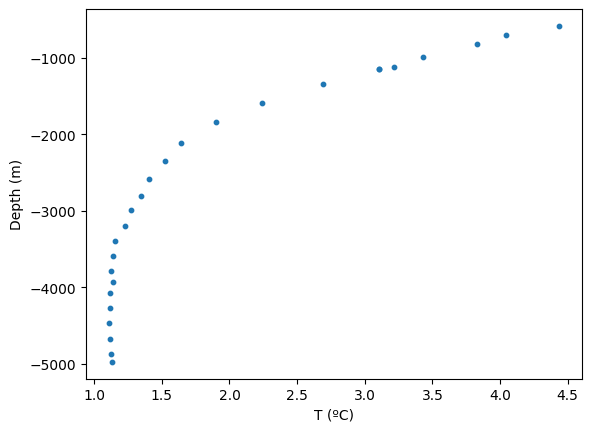

In [ ]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-12-27 06:38:20,140 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


Text(0, 0.5, 'Depth (m)')

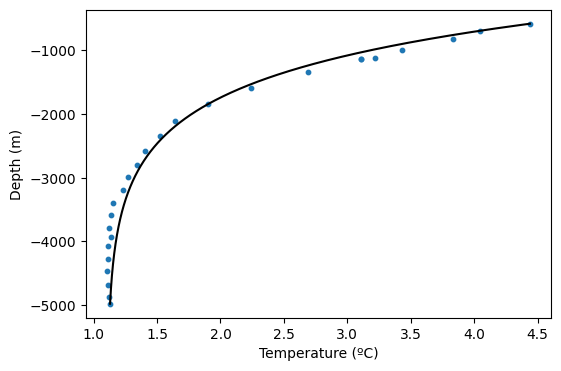

In [ ]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=8.8e-5 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

After experimenting with different values, I observed that the curve becomes smoother as $\kappa$ increases. The curve appears to fit well when $\kappa$ is within the range $[7.8 \times 10^{-5}, 1.1 \times 10^{-4}]$. When $\kappa$ increases beyond this range, the curve no longer fits the data.

Finally, I chose $\kappa = 8.8 \times 10^{-5}$ as it provided the best fit. There is likely an optimal value of $\kappa$ that minimizes the error and achieves the best fit for the data.

The steady advection/diffusion model demonstrates a reasonable ability to fit the measured temperature profile, particularly when $\kappa = 8.8 \times 10^{-5}$. This value of $\kappa$ achieves a good balance between smoothness and precise to the data. The model accurately captures the general trend of temperature variation with depth, especially near the surface and bottom boundaries where the boundary conditions are directly applied.

However, the model's assumptions, such as constant diffusivity and steady-state conditions, may limit its ability to capture finer details or transient effects in the temperature profile. Additionally, introducing depth-dependent $\kappa$ or considering time-dependent terms could further refine the model and improve its fit to the data.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-27 06:38:22,361 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


Text(0, 0.5, 'Depth (m)')

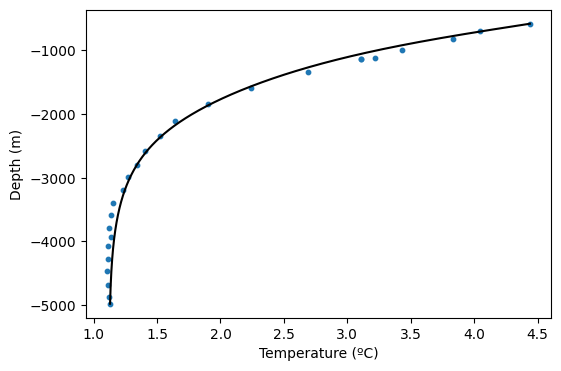

In [ ]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 8e-9  # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667) # m^2/s kappa['g'] = 1e-5 + (8.6e-4 - 1e-5) * np.exp((-5e3 - z) / 667) # m^2/s


# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

When $w = 0$, the model is below the dataset and it is not a good fit. This indicates that there should exist vertical velocity (so the turbulence should be circulation).

I found $w = 8 \times 10^{-9}$ fits well with the data.

When increasing $\kappa_{bg}$, the curve is fitted below the dataset. In contrast, when decreasing $\kappa_{bg}$, the curve is fitted above the dataset (kept the rest of the values the same and $w = 8 \times 10^{-9}$). This shows the optimal $w$ is quite sensitive to the value $\kappa_{bg}$.

Then I changed the value $\kappa_0$ while initialise the other values, and the model is not very sensitive to $\kappa_0$ value.

Finally, I played with the value $l$ and kept the rest of the values unchanged. Increasing or decreasing $l$ does not show a noticeable influence on the graph (I tried a few numbers $l \in [300, 1000]$).

If $\kappa(z)$ varies significantly between smooth and rough topography, it indicates that ocean interior circulation is strongly influenced by local topographic features. In rough topography regions, higher $\kappa(z)$ enhances turbulent mixing, promoting upward movement of dense, cold water and contributing to overturning circulation. In smooth topography regions, lower $\kappa(z)$ results in weaker mixing, with vertical motion (e.g., upwelling or downwelling) being less prominent and more dependent on boundary-layer processes along slopes. The sensitivity of the model to $\kappa_{bg}$ suggests that circulation is highly dependent on spatial variability in diffusivity, with different $\kappa(z)$ regions creating differential vertical velocities that impact local and regional heat and density distribution. Rough topography acts as a “hotspot” for mixing and vertical motion, playing a critical role in balancing global overturning circulation.

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [ ]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-27 06:37:51,167 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:__main__:Starting main loop


2024-12-27 06:37:51,179 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-27 06:37:51,869 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-27 06:37:51,905 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-27 06:37:51,938 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-27 06:37:51,971 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-27 06:37:52,003 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-27 06:37:52,033 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-27 06:37:52,063 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-27 06:37:52,094 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-27 06:37:52,126 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-27 06:37:52,158 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-27 06:37:52,189 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-27 06:37:52,219 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-27 06:37:52,248 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-27 06:37:52,277 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-27 06:37:52,307 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-27 06:37:52,338 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-27 06:37:52,369 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-27 06:37:52,400 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-27 06:37:52,432 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-27 06:37:52,464 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-27 06:37:52,494 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-27 06:37:52,526 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-27 06:37:52,565 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-27 06:37:52,594 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-27 06:37:52,628 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-27 06:37:52,658 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-27 06:37:52,687 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-27 06:37:52,716 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-27 06:37:52,748 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-27 06:37:52,781 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-27 06:37:52,823 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-27 06:37:52,862 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-27 06:37:52,898 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-27 06:37:52,933 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-27 06:37:52,971 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-27 06:37:53,006 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-27 06:37:53,042 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-27 06:37:53,082 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-27 06:37:53,121 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-27 06:37:53,161 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-27 06:37:53,218 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-27 06:37:53,274 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-27 06:37:53,321 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-27 06:37:53,368 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-27 06:37:53,411 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-27 06:37:53,459 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-27 06:37:53,502 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-27 06:37:53,547 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-27 06:37:53,600 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-27 06:37:53,641 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-27 06:37:53,684 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-27 06:37:53,732 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-27 06:37:53,774 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-27 06:37:53,820 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-27 06:37:53,869 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-27 06:37:53,928 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-27 06:37:53,980 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-27 06:37:54,032 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-27 06:37:54,085 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-27 06:37:54,135 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-27 06:37:54,189 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-27 06:37:54,230 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-27 06:37:54,270 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-27 06:37:54,311 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-27 06:37:54,351 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-27 06:37:54,395 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-27 06:37:54,435 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-27 06:37:54,480 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-27 06:37:54,525 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-27 06:37:54,573 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-27 06:37:54,634 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-27 06:37:54,694 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-27 06:37:54,737 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-27 06:37:54,786 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-27 06:37:54,856 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-27 06:37:54,930 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-27 06:37:54,987 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-27 06:37:55,024 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-27 06:37:55,032 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-27 06:37:55,040 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 1.073 sec


2024-12-27 06:37:55,042 solvers 0/1 INFO :: Setup time (init - iter 0): 1.073 sec


INFO:solvers:Warmup time (iter 0-10): 0.06713 sec


2024-12-27 06:37:55,044 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06713 sec


INFO:solvers:Run time (iter 10-end): 3.129 sec


2024-12-27 06:37:55,051 solvers 0/1 INFO :: Run time (iter 10-end): 3.129 sec


INFO:solvers:CPU time (iter 10-end): 0.0008692 cpu-hr


2024-12-27 06:37:55,053 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0008692 cpu-hr


INFO:solvers:Speed: 4.2e+06 mode-stages/cpu-sec


2024-12-27 06:37:55,055 solvers 0/1 INFO :: Speed: 4.2e+06 mode-stages/cpu-sec


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-27 06:37:55,418 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp4m1ifo3t/temp.m4v


2024-12-27 06:37:55,424 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp4m1ifo3t/temp.m4v


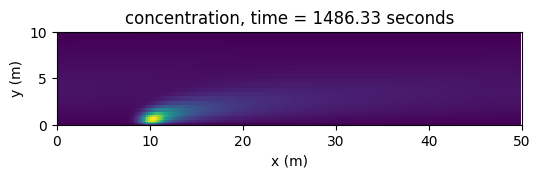

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

For the pollution to travel to the opposite side of the river, diffusion is the only mechanism driving this process. From the diffusion equation, we have:

$$\frac{C}{T} \sim \frac{\kappa C}{L_y^2}$$

Hence, the time for pollution to travel to the opposite side of the river is:

$$T \sim \frac{L_y^2}{\kappa} = \frac{10^2}{0.01} = 10000 \, \text{s}$$

In the horizontal direction, the flow is laminar. Dimensional analysis for

$$\frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y)$$

gives:

$$
\frac{C}{T} \sim \frac{U_0 C}{L_x} \sim \frac{\kappa C}{L_x^2}
$$

$$\implies T \sim \frac{L_x}{U_0} \text{; } T \sim \frac{L_x^2}{\kappa}$$

Thus, the Péclet number is:

$$\frac{L_x U_0}{\kappa} = \frac{10 \times 0.1}{0.01} = 100 \gg 1$$

This indicates that in the horizontal direction, the advection term is dominant.

For the horizontal transport, we expect the length scale to be:

$$L_x \sim U_0 T_y \implies L_x = 0.1 \times 10000 = 1000 \, \text{m}$$

Therefore, 1000 meters downstream of the source is where the pollution is expected to reach.


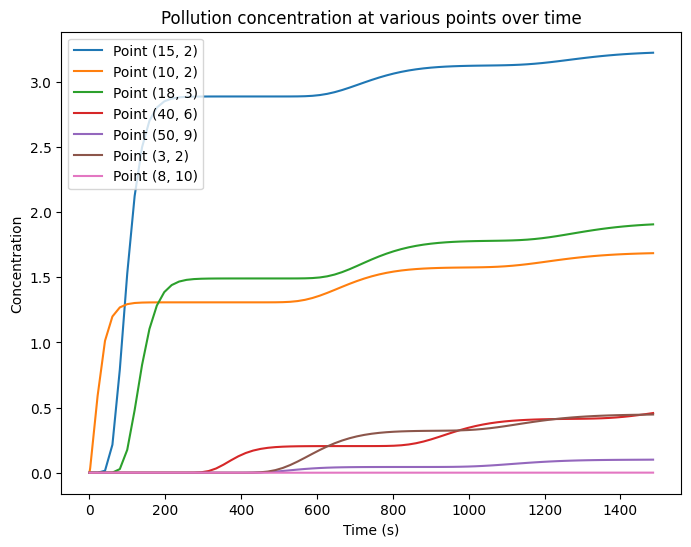

In [ ]:
# Example points to monitor concentration changes
points = [(15, 2),(10,2),(18,3), (40,6),(50,9), (3,2),(8,10)]  # (x, y) coordinates

plt.figure(figsize=(8, 6))
for (px, py) in points:
    i, j = np.argmin(np.abs(x - px)), np.argmin(np.abs(y - py))
    concentration_time_series = [c[i, j] for c in c_save]
    plt.plot(t_save, concentration_time_series, label=f'Point ({px}, {py})')

plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()
plt.title('Pollution concentration at various points over time')
plt.show()

In this plot, I analyzed pollution concentration at several downstream points and two upstream points. For the downstream points, there is a noticeable sharp increase in concentration at different times. This "sudden jump" marks the arrival of the pollution front at each respective location. After this initial rise, the concentration at each point stabilizes, reaching a steady state where no significant gain or loss occurs over time.

Approximately 400 seconds after stabilization, a second increase in concentration is observed. This second jump is smaller in magnitude but has a longer transient period, often failing to fully stabilize before a third jump occurs. This pattern suggests that the model includes a circulation flow, causing pollution to recirculate and re-enter the observed points multiple times, leading to repeated rises in concentration.

In contrast, the upstream points ($x=3$ and $x = 8$) show a delayed and gradual increase in concentration. This occurs only after the pollution has flowed back upstream from downstream regions, likely due to diffusion or recirculation. However, the concentration increase upstream is much smaller compared to the downstream points, highlighting the dominant role of advection in transporting pollution downstream.

Notably, there is a clear spatial gradient in concentration across the river’s width. Points closer to the riverbank exhibit consistently lower concentrations compared to those near the center. This trend reflects the parabolic velocity profile of the flow, where pollution is transported more efficiently in the faster central region and diffuses less effectively toward the slower-moving edges.TThe timescale observed in the plot does not match the theoretical scaling timescale. From the plot, it can be seen that pollutants reach the point near the opposite bank at approximately 500 seconds. This is significantly different from the predicted timescale based on the theoretical scaling, indicating a potential discrepancy between the theoretical model and the actual transport dynamics observed in the simulation.


This visualization underscores the interplay between advection and diffusion, the influence of flow velocity profiles, and the temporal dynamics of pollution transport in the river system.

### Investigation of How the Pollution Level Depends on Flow Speed

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s


2024-12-27 06:40:07,999 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s


INFO:__main__:Starting main loop


2024-12-27 06:40:08,007 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.906250e-01, dt=3.906250e-01


2024-12-27 06:40:08,046 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e-01, dt=3.906250e-01


INFO:__main__:Iteration=11, Time=4.296875e+00, dt=3.906250e-01


2024-12-27 06:40:08,077 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+00, dt=3.906250e-01


INFO:__main__:Iteration=21, Time=8.203125e+00, dt=3.906250e-01


2024-12-27 06:40:08,109 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+00, dt=3.906250e-01


INFO:__main__:Iteration=31, Time=1.210938e+01, dt=3.906250e-01


2024-12-27 06:40:08,139 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+01, dt=3.906250e-01


INFO:__main__:Iteration=41, Time=1.601562e+01, dt=3.906250e-01


2024-12-27 06:40:08,169 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+01, dt=3.906250e-01


INFO:__main__:Iteration=51, Time=1.992188e+01, dt=3.906250e-01


2024-12-27 06:40:08,199 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+01, dt=3.906250e-01


INFO:__main__:Iteration=61, Time=2.382812e+01, dt=3.906250e-01


2024-12-27 06:40:08,230 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+01, dt=3.906250e-01


INFO:__main__:Iteration=71, Time=2.773438e+01, dt=3.906250e-01


2024-12-27 06:40:08,263 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+01, dt=3.906250e-01


INFO:__main__:Iteration=81, Time=3.164062e+01, dt=3.906250e-01


2024-12-27 06:40:08,292 __main__ 0/1 INFO :: Iteration=81, Time=3.164062e+01, dt=3.906250e-01


INFO:__main__:Iteration=91, Time=3.554688e+01, dt=3.906250e-01


2024-12-27 06:40:08,322 __main__ 0/1 INFO :: Iteration=91, Time=3.554688e+01, dt=3.906250e-01


INFO:__main__:Iteration=101, Time=3.945312e+01, dt=3.906250e-01


2024-12-27 06:40:08,354 __main__ 0/1 INFO :: Iteration=101, Time=3.945312e+01, dt=3.906250e-01


INFO:__main__:Iteration=111, Time=4.335938e+01, dt=3.906250e-01


2024-12-27 06:40:08,384 __main__ 0/1 INFO :: Iteration=111, Time=4.335938e+01, dt=3.906250e-01


INFO:__main__:Iteration=121, Time=4.726562e+01, dt=3.906250e-01


2024-12-27 06:40:08,414 __main__ 0/1 INFO :: Iteration=121, Time=4.726562e+01, dt=3.906250e-01


INFO:__main__:Iteration=131, Time=5.117188e+01, dt=3.906250e-01


2024-12-27 06:40:08,444 __main__ 0/1 INFO :: Iteration=131, Time=5.117188e+01, dt=3.906250e-01


INFO:__main__:Iteration=141, Time=5.507812e+01, dt=3.906250e-01


2024-12-27 06:40:08,477 __main__ 0/1 INFO :: Iteration=141, Time=5.507812e+01, dt=3.906250e-01


INFO:__main__:Iteration=151, Time=5.898438e+01, dt=3.906250e-01


2024-12-27 06:40:08,507 __main__ 0/1 INFO :: Iteration=151, Time=5.898438e+01, dt=3.906250e-01


INFO:__main__:Iteration=161, Time=6.289062e+01, dt=3.906250e-01


2024-12-27 06:40:08,539 __main__ 0/1 INFO :: Iteration=161, Time=6.289062e+01, dt=3.906250e-01


INFO:__main__:Iteration=171, Time=6.679688e+01, dt=3.906250e-01


2024-12-27 06:40:08,573 __main__ 0/1 INFO :: Iteration=171, Time=6.679688e+01, dt=3.906250e-01


INFO:__main__:Iteration=181, Time=7.070312e+01, dt=3.906250e-01


2024-12-27 06:40:08,604 __main__ 0/1 INFO :: Iteration=181, Time=7.070312e+01, dt=3.906250e-01


INFO:__main__:Iteration=191, Time=7.460938e+01, dt=3.906250e-01


2024-12-27 06:40:08,635 __main__ 0/1 INFO :: Iteration=191, Time=7.460938e+01, dt=3.906250e-01


INFO:__main__:Iteration=201, Time=7.851562e+01, dt=3.906250e-01


2024-12-27 06:40:08,670 __main__ 0/1 INFO :: Iteration=201, Time=7.851562e+01, dt=3.906250e-01


INFO:__main__:Iteration=211, Time=8.242188e+01, dt=3.906250e-01


2024-12-27 06:40:08,701 __main__ 0/1 INFO :: Iteration=211, Time=8.242188e+01, dt=3.906250e-01


INFO:__main__:Iteration=221, Time=8.632812e+01, dt=3.906250e-01


2024-12-27 06:40:08,733 __main__ 0/1 INFO :: Iteration=221, Time=8.632812e+01, dt=3.906250e-01


INFO:__main__:Iteration=231, Time=9.023438e+01, dt=3.906250e-01


2024-12-27 06:40:08,764 __main__ 0/1 INFO :: Iteration=231, Time=9.023438e+01, dt=3.906250e-01


INFO:__main__:Iteration=241, Time=9.414062e+01, dt=3.906250e-01


2024-12-27 06:40:08,802 __main__ 0/1 INFO :: Iteration=241, Time=9.414062e+01, dt=3.906250e-01


INFO:__main__:Iteration=251, Time=9.804688e+01, dt=3.906250e-01


2024-12-27 06:40:08,841 __main__ 0/1 INFO :: Iteration=251, Time=9.804688e+01, dt=3.906250e-01


INFO:__main__:Iteration=261, Time=1.019531e+02, dt=3.906250e-01


2024-12-27 06:40:08,876 __main__ 0/1 INFO :: Iteration=261, Time=1.019531e+02, dt=3.906250e-01


INFO:__main__:Iteration=271, Time=1.058594e+02, dt=3.906250e-01


2024-12-27 06:40:08,913 __main__ 0/1 INFO :: Iteration=271, Time=1.058594e+02, dt=3.906250e-01


INFO:__main__:Iteration=281, Time=1.097656e+02, dt=3.906250e-01


2024-12-27 06:40:08,969 __main__ 0/1 INFO :: Iteration=281, Time=1.097656e+02, dt=3.906250e-01


INFO:__main__:Iteration=291, Time=1.136719e+02, dt=3.906250e-01


2024-12-27 06:40:09,021 __main__ 0/1 INFO :: Iteration=291, Time=1.136719e+02, dt=3.906250e-01


INFO:__main__:Iteration=301, Time=1.175781e+02, dt=3.906250e-01


2024-12-27 06:40:09,085 __main__ 0/1 INFO :: Iteration=301, Time=1.175781e+02, dt=3.906250e-01


INFO:__main__:Iteration=311, Time=1.214844e+02, dt=3.906250e-01


2024-12-27 06:40:09,132 __main__ 0/1 INFO :: Iteration=311, Time=1.214844e+02, dt=3.906250e-01


INFO:__main__:Iteration=321, Time=1.253906e+02, dt=3.906250e-01


2024-12-27 06:40:09,179 __main__ 0/1 INFO :: Iteration=321, Time=1.253906e+02, dt=3.906250e-01


INFO:__main__:Iteration=331, Time=1.292969e+02, dt=3.906250e-01


2024-12-27 06:40:09,235 __main__ 0/1 INFO :: Iteration=331, Time=1.292969e+02, dt=3.906250e-01


INFO:__main__:Iteration=341, Time=1.332031e+02, dt=3.906250e-01


2024-12-27 06:40:09,281 __main__ 0/1 INFO :: Iteration=341, Time=1.332031e+02, dt=3.906250e-01


INFO:__main__:Iteration=351, Time=1.371094e+02, dt=3.906250e-01


2024-12-27 06:40:09,324 __main__ 0/1 INFO :: Iteration=351, Time=1.371094e+02, dt=3.906250e-01


INFO:__main__:Iteration=361, Time=1.410156e+02, dt=3.906250e-01


2024-12-27 06:40:09,371 __main__ 0/1 INFO :: Iteration=361, Time=1.410156e+02, dt=3.906250e-01


INFO:__main__:Iteration=371, Time=1.449219e+02, dt=3.906250e-01


2024-12-27 06:40:09,430 __main__ 0/1 INFO :: Iteration=371, Time=1.449219e+02, dt=3.906250e-01


INFO:__main__:Iteration=381, Time=1.488281e+02, dt=3.906250e-01


2024-12-27 06:40:09,476 __main__ 0/1 INFO :: Iteration=381, Time=1.488281e+02, dt=3.906250e-01


INFO:__main__:Iteration=391, Time=1.527344e+02, dt=3.906250e-01


2024-12-27 06:40:09,522 __main__ 0/1 INFO :: Iteration=391, Time=1.527344e+02, dt=3.906250e-01


INFO:__main__:Iteration=401, Time=1.566406e+02, dt=3.906250e-01


2024-12-27 06:40:09,565 __main__ 0/1 INFO :: Iteration=401, Time=1.566406e+02, dt=3.906250e-01


INFO:__main__:Iteration=411, Time=1.605469e+02, dt=3.906250e-01


2024-12-27 06:40:09,611 __main__ 0/1 INFO :: Iteration=411, Time=1.605469e+02, dt=3.906250e-01


INFO:__main__:Iteration=421, Time=1.644531e+02, dt=3.906250e-01


2024-12-27 06:40:09,652 __main__ 0/1 INFO :: Iteration=421, Time=1.644531e+02, dt=3.906250e-01


INFO:__main__:Iteration=431, Time=1.683594e+02, dt=3.906250e-01


2024-12-27 06:40:09,691 __main__ 0/1 INFO :: Iteration=431, Time=1.683594e+02, dt=3.906250e-01


INFO:__main__:Iteration=441, Time=1.722656e+02, dt=3.906250e-01


2024-12-27 06:40:09,730 __main__ 0/1 INFO :: Iteration=441, Time=1.722656e+02, dt=3.906250e-01


INFO:__main__:Iteration=451, Time=1.761719e+02, dt=3.906250e-01


2024-12-27 06:40:09,772 __main__ 0/1 INFO :: Iteration=451, Time=1.761719e+02, dt=3.906250e-01


INFO:__main__:Iteration=461, Time=1.800781e+02, dt=3.906250e-01


2024-12-27 06:40:09,825 __main__ 0/1 INFO :: Iteration=461, Time=1.800781e+02, dt=3.906250e-01


INFO:__main__:Iteration=471, Time=1.839844e+02, dt=3.906250e-01


2024-12-27 06:40:09,890 __main__ 0/1 INFO :: Iteration=471, Time=1.839844e+02, dt=3.906250e-01


INFO:__main__:Iteration=481, Time=1.878906e+02, dt=3.906250e-01


2024-12-27 06:40:09,945 __main__ 0/1 INFO :: Iteration=481, Time=1.878906e+02, dt=3.906250e-01


INFO:__main__:Iteration=491, Time=1.917969e+02, dt=3.906250e-01


2024-12-27 06:40:09,993 __main__ 0/1 INFO :: Iteration=491, Time=1.917969e+02, dt=3.906250e-01


INFO:__main__:Iteration=501, Time=1.957031e+02, dt=3.906250e-01


2024-12-27 06:40:10,045 __main__ 0/1 INFO :: Iteration=501, Time=1.957031e+02, dt=3.906250e-01


INFO:__main__:Iteration=511, Time=1.996094e+02, dt=3.906250e-01


2024-12-27 06:40:10,105 __main__ 0/1 INFO :: Iteration=511, Time=1.996094e+02, dt=3.906250e-01


INFO:__main__:Iteration=521, Time=2.035156e+02, dt=3.906250e-01


2024-12-27 06:40:10,148 __main__ 0/1 INFO :: Iteration=521, Time=2.035156e+02, dt=3.906250e-01


INFO:__main__:Iteration=531, Time=2.074219e+02, dt=3.906250e-01


2024-12-27 06:40:10,197 __main__ 0/1 INFO :: Iteration=531, Time=2.074219e+02, dt=3.906250e-01


INFO:__main__:Iteration=541, Time=2.113281e+02, dt=3.906250e-01


2024-12-27 06:40:10,250 __main__ 0/1 INFO :: Iteration=541, Time=2.113281e+02, dt=3.906250e-01


INFO:__main__:Iteration=551, Time=2.152344e+02, dt=3.906250e-01


2024-12-27 06:40:10,294 __main__ 0/1 INFO :: Iteration=551, Time=2.152344e+02, dt=3.906250e-01


INFO:__main__:Iteration=561, Time=2.191406e+02, dt=3.906250e-01


2024-12-27 06:40:10,338 __main__ 0/1 INFO :: Iteration=561, Time=2.191406e+02, dt=3.906250e-01


INFO:__main__:Iteration=571, Time=2.230469e+02, dt=3.906250e-01


2024-12-27 06:40:10,382 __main__ 0/1 INFO :: Iteration=571, Time=2.230469e+02, dt=3.906250e-01


INFO:__main__:Iteration=581, Time=2.269531e+02, dt=3.906250e-01


2024-12-27 06:40:10,427 __main__ 0/1 INFO :: Iteration=581, Time=2.269531e+02, dt=3.906250e-01


INFO:__main__:Iteration=591, Time=2.308594e+02, dt=3.906250e-01


2024-12-27 06:40:10,472 __main__ 0/1 INFO :: Iteration=591, Time=2.308594e+02, dt=3.906250e-01


INFO:__main__:Iteration=601, Time=2.347656e+02, dt=3.906250e-01


2024-12-27 06:40:10,521 __main__ 0/1 INFO :: Iteration=601, Time=2.347656e+02, dt=3.906250e-01


INFO:__main__:Iteration=611, Time=2.386719e+02, dt=3.906250e-01


2024-12-27 06:40:10,564 __main__ 0/1 INFO :: Iteration=611, Time=2.386719e+02, dt=3.906250e-01


INFO:__main__:Iteration=621, Time=2.425781e+02, dt=3.906250e-01


2024-12-27 06:40:10,604 __main__ 0/1 INFO :: Iteration=621, Time=2.425781e+02, dt=3.906250e-01


INFO:__main__:Iteration=631, Time=2.464844e+02, dt=3.906250e-01


2024-12-27 06:40:10,648 __main__ 0/1 INFO :: Iteration=631, Time=2.464844e+02, dt=3.906250e-01


INFO:__main__:Iteration=641, Time=2.503906e+02, dt=3.906250e-01


2024-12-27 06:40:10,692 __main__ 0/1 INFO :: Iteration=641, Time=2.503906e+02, dt=3.906250e-01


INFO:__main__:Iteration=651, Time=2.542969e+02, dt=3.906250e-01


2024-12-27 06:40:10,732 __main__ 0/1 INFO :: Iteration=651, Time=2.542969e+02, dt=3.906250e-01


INFO:__main__:Iteration=661, Time=2.582031e+02, dt=3.906250e-01


2024-12-27 06:40:10,774 __main__ 0/1 INFO :: Iteration=661, Time=2.582031e+02, dt=3.906250e-01


INFO:__main__:Iteration=671, Time=2.621094e+02, dt=3.906250e-01


2024-12-27 06:40:10,821 __main__ 0/1 INFO :: Iteration=671, Time=2.621094e+02, dt=3.906250e-01


INFO:__main__:Iteration=681, Time=2.660156e+02, dt=3.906250e-01


2024-12-27 06:40:10,862 __main__ 0/1 INFO :: Iteration=681, Time=2.660156e+02, dt=3.906250e-01


INFO:__main__:Iteration=691, Time=2.699219e+02, dt=3.906250e-01


2024-12-27 06:40:10,905 __main__ 0/1 INFO :: Iteration=691, Time=2.699219e+02, dt=3.906250e-01


INFO:__main__:Iteration=701, Time=2.738281e+02, dt=3.906250e-01


2024-12-27 06:40:10,954 __main__ 0/1 INFO :: Iteration=701, Time=2.738281e+02, dt=3.906250e-01


INFO:__main__:Iteration=711, Time=2.777344e+02, dt=3.906250e-01


2024-12-27 06:40:11,004 __main__ 0/1 INFO :: Iteration=711, Time=2.777344e+02, dt=3.906250e-01


INFO:__main__:Iteration=721, Time=2.816406e+02, dt=3.906250e-01


2024-12-27 06:40:11,050 __main__ 0/1 INFO :: Iteration=721, Time=2.816406e+02, dt=3.906250e-01


INFO:__main__:Iteration=731, Time=2.855469e+02, dt=3.906250e-01


2024-12-27 06:40:11,105 __main__ 0/1 INFO :: Iteration=731, Time=2.855469e+02, dt=3.906250e-01


INFO:__main__:Iteration=741, Time=2.894531e+02, dt=3.906250e-01


2024-12-27 06:40:11,151 __main__ 0/1 INFO :: Iteration=741, Time=2.894531e+02, dt=3.906250e-01


INFO:__main__:Iteration=751, Time=2.933594e+02, dt=3.906250e-01


2024-12-27 06:40:11,198 __main__ 0/1 INFO :: Iteration=751, Time=2.933594e+02, dt=3.906250e-01


INFO:__main__:Iteration=761, Time=2.972656e+02, dt=3.906250e-01


2024-12-27 06:40:11,239 __main__ 0/1 INFO :: Iteration=761, Time=2.972656e+02, dt=3.906250e-01


INFO:__main__:Iteration=771, Time=3.011719e+02, dt=3.906250e-01


2024-12-27 06:40:11,279 __main__ 0/1 INFO :: Iteration=771, Time=3.011719e+02, dt=3.906250e-01


INFO:__main__:Iteration=781, Time=3.050781e+02, dt=3.906250e-01


2024-12-27 06:40:11,322 __main__ 0/1 INFO :: Iteration=781, Time=3.050781e+02, dt=3.906250e-01


INFO:__main__:Iteration=791, Time=3.089844e+02, dt=3.906250e-01


2024-12-27 06:40:11,365 __main__ 0/1 INFO :: Iteration=791, Time=3.089844e+02, dt=3.906250e-01


INFO:__main__:Iteration=801, Time=3.128906e+02, dt=3.906250e-01


2024-12-27 06:40:11,411 __main__ 0/1 INFO :: Iteration=801, Time=3.128906e+02, dt=3.906250e-01


INFO:__main__:Iteration=811, Time=3.167969e+02, dt=3.906250e-01


2024-12-27 06:40:11,452 __main__ 0/1 INFO :: Iteration=811, Time=3.167969e+02, dt=3.906250e-01


INFO:__main__:Iteration=821, Time=3.207031e+02, dt=3.906250e-01


2024-12-27 06:40:11,496 __main__ 0/1 INFO :: Iteration=821, Time=3.207031e+02, dt=3.906250e-01


INFO:__main__:Iteration=831, Time=3.246094e+02, dt=3.906250e-01


2024-12-27 06:40:11,540 __main__ 0/1 INFO :: Iteration=831, Time=3.246094e+02, dt=3.906250e-01


INFO:__main__:Iteration=841, Time=3.285156e+02, dt=3.906250e-01


2024-12-27 06:40:11,582 __main__ 0/1 INFO :: Iteration=841, Time=3.285156e+02, dt=3.906250e-01


INFO:__main__:Iteration=851, Time=3.324219e+02, dt=3.906250e-01


2024-12-27 06:40:11,624 __main__ 0/1 INFO :: Iteration=851, Time=3.324219e+02, dt=3.906250e-01


INFO:__main__:Iteration=861, Time=3.363281e+02, dt=3.906250e-01


2024-12-27 06:40:11,665 __main__ 0/1 INFO :: Iteration=861, Time=3.363281e+02, dt=3.906250e-01


INFO:__main__:Iteration=871, Time=3.402344e+02, dt=3.906250e-01


2024-12-27 06:40:11,704 __main__ 0/1 INFO :: Iteration=871, Time=3.402344e+02, dt=3.906250e-01


INFO:__main__:Iteration=881, Time=3.441406e+02, dt=3.906250e-01


2024-12-27 06:40:11,747 __main__ 0/1 INFO :: Iteration=881, Time=3.441406e+02, dt=3.906250e-01


INFO:__main__:Iteration=891, Time=3.480469e+02, dt=3.906250e-01


2024-12-27 06:40:11,795 __main__ 0/1 INFO :: Iteration=891, Time=3.480469e+02, dt=3.906250e-01


INFO:__main__:Iteration=901, Time=3.519531e+02, dt=3.906250e-01


2024-12-27 06:40:11,860 __main__ 0/1 INFO :: Iteration=901, Time=3.519531e+02, dt=3.906250e-01


INFO:__main__:Iteration=911, Time=3.558594e+02, dt=3.906250e-01


2024-12-27 06:40:11,928 __main__ 0/1 INFO :: Iteration=911, Time=3.558594e+02, dt=3.906250e-01


INFO:__main__:Iteration=921, Time=3.597656e+02, dt=3.906250e-01


2024-12-27 06:40:11,984 __main__ 0/1 INFO :: Iteration=921, Time=3.597656e+02, dt=3.906250e-01


INFO:__main__:Iteration=931, Time=3.636719e+02, dt=3.906250e-01


2024-12-27 06:40:12,037 __main__ 0/1 INFO :: Iteration=931, Time=3.636719e+02, dt=3.906250e-01


INFO:__main__:Iteration=941, Time=3.675781e+02, dt=3.906250e-01


2024-12-27 06:40:12,090 __main__ 0/1 INFO :: Iteration=941, Time=3.675781e+02, dt=3.906250e-01


INFO:__main__:Iteration=951, Time=3.714844e+02, dt=3.906250e-01


2024-12-27 06:40:12,145 __main__ 0/1 INFO :: Iteration=951, Time=3.714844e+02, dt=3.906250e-01


INFO:__main__:Iteration=961, Time=3.753906e+02, dt=3.906250e-01


2024-12-27 06:40:12,191 __main__ 0/1 INFO :: Iteration=961, Time=3.753906e+02, dt=3.906250e-01


INFO:__main__:Iteration=971, Time=3.792969e+02, dt=3.906250e-01


2024-12-27 06:40:12,246 __main__ 0/1 INFO :: Iteration=971, Time=3.792969e+02, dt=3.906250e-01


INFO:__main__:Iteration=981, Time=3.832031e+02, dt=3.906250e-01


2024-12-27 06:40:12,304 __main__ 0/1 INFO :: Iteration=981, Time=3.832031e+02, dt=3.906250e-01


INFO:__main__:Iteration=991, Time=3.871094e+02, dt=3.906250e-01


2024-12-27 06:40:12,357 __main__ 0/1 INFO :: Iteration=991, Time=3.871094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1001, Time=3.910156e+02, dt=3.906250e-01


2024-12-27 06:40:12,403 __main__ 0/1 INFO :: Iteration=1001, Time=3.910156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1011, Time=3.949219e+02, dt=3.906250e-01


2024-12-27 06:40:12,448 __main__ 0/1 INFO :: Iteration=1011, Time=3.949219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1021, Time=3.988281e+02, dt=3.906250e-01


2024-12-27 06:40:12,492 __main__ 0/1 INFO :: Iteration=1021, Time=3.988281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1031, Time=4.027344e+02, dt=3.906250e-01


2024-12-27 06:40:12,540 __main__ 0/1 INFO :: Iteration=1031, Time=4.027344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1041, Time=4.066406e+02, dt=3.906250e-01


2024-12-27 06:40:12,585 __main__ 0/1 INFO :: Iteration=1041, Time=4.066406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1051, Time=4.105469e+02, dt=3.906250e-01


2024-12-27 06:40:12,630 __main__ 0/1 INFO :: Iteration=1051, Time=4.105469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1061, Time=4.144531e+02, dt=3.906250e-01


2024-12-27 06:40:12,676 __main__ 0/1 INFO :: Iteration=1061, Time=4.144531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1071, Time=4.183594e+02, dt=3.906250e-01


2024-12-27 06:40:12,720 __main__ 0/1 INFO :: Iteration=1071, Time=4.183594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1081, Time=4.222656e+02, dt=3.906250e-01


2024-12-27 06:40:12,777 __main__ 0/1 INFO :: Iteration=1081, Time=4.222656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1091, Time=4.261719e+02, dt=3.906250e-01


2024-12-27 06:40:12,826 __main__ 0/1 INFO :: Iteration=1091, Time=4.261719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1101, Time=4.300781e+02, dt=3.906250e-01


2024-12-27 06:40:12,878 __main__ 0/1 INFO :: Iteration=1101, Time=4.300781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1111, Time=4.339844e+02, dt=3.906250e-01


2024-12-27 06:40:12,940 __main__ 0/1 INFO :: Iteration=1111, Time=4.339844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1121, Time=4.378906e+02, dt=3.906250e-01


2024-12-27 06:40:12,998 __main__ 0/1 INFO :: Iteration=1121, Time=4.378906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1131, Time=4.417969e+02, dt=3.906250e-01


2024-12-27 06:40:13,052 __main__ 0/1 INFO :: Iteration=1131, Time=4.417969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1141, Time=4.457031e+02, dt=3.906250e-01


2024-12-27 06:40:13,102 __main__ 0/1 INFO :: Iteration=1141, Time=4.457031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1151, Time=4.496094e+02, dt=3.906250e-01


2024-12-27 06:40:13,156 __main__ 0/1 INFO :: Iteration=1151, Time=4.496094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1161, Time=4.535156e+02, dt=3.906250e-01


2024-12-27 06:40:13,207 __main__ 0/1 INFO :: Iteration=1161, Time=4.535156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1171, Time=4.574219e+02, dt=3.906250e-01


2024-12-27 06:40:13,239 __main__ 0/1 INFO :: Iteration=1171, Time=4.574219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1181, Time=4.613281e+02, dt=3.906250e-01


2024-12-27 06:40:13,281 __main__ 0/1 INFO :: Iteration=1181, Time=4.613281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1191, Time=4.652344e+02, dt=3.906250e-01


2024-12-27 06:40:13,318 __main__ 0/1 INFO :: Iteration=1191, Time=4.652344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1201, Time=4.691406e+02, dt=3.906250e-01


2024-12-27 06:40:13,350 __main__ 0/1 INFO :: Iteration=1201, Time=4.691406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1211, Time=4.730469e+02, dt=3.906250e-01


2024-12-27 06:40:13,382 __main__ 0/1 INFO :: Iteration=1211, Time=4.730469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1221, Time=4.769531e+02, dt=3.906250e-01


2024-12-27 06:40:13,415 __main__ 0/1 INFO :: Iteration=1221, Time=4.769531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1231, Time=4.808594e+02, dt=3.906250e-01


2024-12-27 06:40:13,447 __main__ 0/1 INFO :: Iteration=1231, Time=4.808594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1241, Time=4.847656e+02, dt=3.906250e-01


2024-12-27 06:40:13,478 __main__ 0/1 INFO :: Iteration=1241, Time=4.847656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1251, Time=4.886719e+02, dt=3.906250e-01


2024-12-27 06:40:13,509 __main__ 0/1 INFO :: Iteration=1251, Time=4.886719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1261, Time=4.925781e+02, dt=3.906250e-01


2024-12-27 06:40:13,541 __main__ 0/1 INFO :: Iteration=1261, Time=4.925781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1271, Time=4.964844e+02, dt=3.906250e-01


2024-12-27 06:40:13,571 __main__ 0/1 INFO :: Iteration=1271, Time=4.964844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1281, Time=5.003906e+02, dt=3.906250e-01


2024-12-27 06:40:13,602 __main__ 0/1 INFO :: Iteration=1281, Time=5.003906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1291, Time=5.042969e+02, dt=3.906250e-01


2024-12-27 06:40:13,635 __main__ 0/1 INFO :: Iteration=1291, Time=5.042969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1301, Time=5.082031e+02, dt=3.906250e-01


2024-12-27 06:40:13,668 __main__ 0/1 INFO :: Iteration=1301, Time=5.082031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1311, Time=5.121094e+02, dt=3.906250e-01


2024-12-27 06:40:13,699 __main__ 0/1 INFO :: Iteration=1311, Time=5.121094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1321, Time=5.160156e+02, dt=3.906250e-01


2024-12-27 06:40:13,731 __main__ 0/1 INFO :: Iteration=1321, Time=5.160156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1331, Time=5.199219e+02, dt=3.906250e-01


2024-12-27 06:40:13,768 __main__ 0/1 INFO :: Iteration=1331, Time=5.199219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1341, Time=5.238281e+02, dt=3.906250e-01


2024-12-27 06:40:13,810 __main__ 0/1 INFO :: Iteration=1341, Time=5.238281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1351, Time=5.277344e+02, dt=3.906250e-01


2024-12-27 06:40:13,852 __main__ 0/1 INFO :: Iteration=1351, Time=5.277344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1361, Time=5.316406e+02, dt=3.906250e-01


2024-12-27 06:40:13,891 __main__ 0/1 INFO :: Iteration=1361, Time=5.316406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1371, Time=5.355469e+02, dt=3.906250e-01


2024-12-27 06:40:13,927 __main__ 0/1 INFO :: Iteration=1371, Time=5.355469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1381, Time=5.394531e+02, dt=3.906250e-01


2024-12-27 06:40:13,967 __main__ 0/1 INFO :: Iteration=1381, Time=5.394531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1391, Time=5.433594e+02, dt=3.906250e-01


2024-12-27 06:40:14,006 __main__ 0/1 INFO :: Iteration=1391, Time=5.433594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1401, Time=5.472656e+02, dt=3.906250e-01


2024-12-27 06:40:14,046 __main__ 0/1 INFO :: Iteration=1401, Time=5.472656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1411, Time=5.511719e+02, dt=3.906250e-01


2024-12-27 06:40:14,087 __main__ 0/1 INFO :: Iteration=1411, Time=5.511719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1421, Time=5.550781e+02, dt=3.906250e-01


2024-12-27 06:40:14,129 __main__ 0/1 INFO :: Iteration=1421, Time=5.550781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1431, Time=5.589844e+02, dt=3.906250e-01


2024-12-27 06:40:14,162 __main__ 0/1 INFO :: Iteration=1431, Time=5.589844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1441, Time=5.628906e+02, dt=3.906250e-01


2024-12-27 06:40:14,199 __main__ 0/1 INFO :: Iteration=1441, Time=5.628906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1451, Time=5.667969e+02, dt=3.906250e-01


2024-12-27 06:40:14,231 __main__ 0/1 INFO :: Iteration=1451, Time=5.667969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1461, Time=5.707031e+02, dt=3.906250e-01


2024-12-27 06:40:14,263 __main__ 0/1 INFO :: Iteration=1461, Time=5.707031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1471, Time=5.746094e+02, dt=3.906250e-01


2024-12-27 06:40:14,306 __main__ 0/1 INFO :: Iteration=1471, Time=5.746094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1481, Time=5.785156e+02, dt=3.906250e-01


2024-12-27 06:40:14,341 __main__ 0/1 INFO :: Iteration=1481, Time=5.785156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1491, Time=5.824219e+02, dt=3.906250e-01


2024-12-27 06:40:14,374 __main__ 0/1 INFO :: Iteration=1491, Time=5.824219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1501, Time=5.863281e+02, dt=3.906250e-01


2024-12-27 06:40:14,406 __main__ 0/1 INFO :: Iteration=1501, Time=5.863281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1511, Time=5.902344e+02, dt=3.906250e-01


2024-12-27 06:40:14,438 __main__ 0/1 INFO :: Iteration=1511, Time=5.902344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1521, Time=5.941406e+02, dt=3.906250e-01


2024-12-27 06:40:14,470 __main__ 0/1 INFO :: Iteration=1521, Time=5.941406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1531, Time=5.980469e+02, dt=3.906250e-01


2024-12-27 06:40:14,502 __main__ 0/1 INFO :: Iteration=1531, Time=5.980469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1541, Time=6.019531e+02, dt=3.906250e-01


2024-12-27 06:40:14,534 __main__ 0/1 INFO :: Iteration=1541, Time=6.019531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1551, Time=6.058594e+02, dt=3.906250e-01


2024-12-27 06:40:14,566 __main__ 0/1 INFO :: Iteration=1551, Time=6.058594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1561, Time=6.097656e+02, dt=3.906250e-01


2024-12-27 06:40:14,597 __main__ 0/1 INFO :: Iteration=1561, Time=6.097656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1571, Time=6.136719e+02, dt=3.906250e-01


2024-12-27 06:40:14,632 __main__ 0/1 INFO :: Iteration=1571, Time=6.136719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1581, Time=6.175781e+02, dt=3.906250e-01


2024-12-27 06:40:14,665 __main__ 0/1 INFO :: Iteration=1581, Time=6.175781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1591, Time=6.214844e+02, dt=3.906250e-01


2024-12-27 06:40:14,699 __main__ 0/1 INFO :: Iteration=1591, Time=6.214844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1601, Time=6.253906e+02, dt=3.906250e-01


2024-12-27 06:40:14,789 __main__ 0/1 INFO :: Iteration=1601, Time=6.253906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1611, Time=6.292969e+02, dt=3.906250e-01


2024-12-27 06:40:14,832 __main__ 0/1 INFO :: Iteration=1611, Time=6.292969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1621, Time=6.332031e+02, dt=3.906250e-01


2024-12-27 06:40:14,871 __main__ 0/1 INFO :: Iteration=1621, Time=6.332031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1631, Time=6.371094e+02, dt=3.906250e-01


2024-12-27 06:40:14,910 __main__ 0/1 INFO :: Iteration=1631, Time=6.371094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1641, Time=6.410156e+02, dt=3.906250e-01


2024-12-27 06:40:14,954 __main__ 0/1 INFO :: Iteration=1641, Time=6.410156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1651, Time=6.449219e+02, dt=3.906250e-01


2024-12-27 06:40:15,005 __main__ 0/1 INFO :: Iteration=1651, Time=6.449219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1661, Time=6.488281e+02, dt=3.906250e-01


2024-12-27 06:40:15,045 __main__ 0/1 INFO :: Iteration=1661, Time=6.488281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1671, Time=6.527344e+02, dt=3.906250e-01


2024-12-27 06:40:15,084 __main__ 0/1 INFO :: Iteration=1671, Time=6.527344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1681, Time=6.566406e+02, dt=3.906250e-01


2024-12-27 06:40:15,125 __main__ 0/1 INFO :: Iteration=1681, Time=6.566406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1691, Time=6.605469e+02, dt=3.906250e-01


2024-12-27 06:40:15,161 __main__ 0/1 INFO :: Iteration=1691, Time=6.605469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1701, Time=6.644531e+02, dt=3.906250e-01


2024-12-27 06:40:15,195 __main__ 0/1 INFO :: Iteration=1701, Time=6.644531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1711, Time=6.683594e+02, dt=3.906250e-01


2024-12-27 06:40:15,227 __main__ 0/1 INFO :: Iteration=1711, Time=6.683594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1721, Time=6.722656e+02, dt=3.906250e-01


2024-12-27 06:40:15,260 __main__ 0/1 INFO :: Iteration=1721, Time=6.722656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1731, Time=6.761719e+02, dt=3.906250e-01


2024-12-27 06:40:15,291 __main__ 0/1 INFO :: Iteration=1731, Time=6.761719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1741, Time=6.800781e+02, dt=3.906250e-01


2024-12-27 06:40:15,333 __main__ 0/1 INFO :: Iteration=1741, Time=6.800781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1751, Time=6.839844e+02, dt=3.906250e-01


2024-12-27 06:40:15,374 __main__ 0/1 INFO :: Iteration=1751, Time=6.839844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1761, Time=6.878906e+02, dt=3.906250e-01


2024-12-27 06:40:15,446 __main__ 0/1 INFO :: Iteration=1761, Time=6.878906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1771, Time=6.917969e+02, dt=3.906250e-01


2024-12-27 06:40:15,478 __main__ 0/1 INFO :: Iteration=1771, Time=6.917969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1781, Time=6.957031e+02, dt=3.906250e-01


2024-12-27 06:40:15,510 __main__ 0/1 INFO :: Iteration=1781, Time=6.957031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1791, Time=6.996094e+02, dt=3.906250e-01


2024-12-27 06:40:15,545 __main__ 0/1 INFO :: Iteration=1791, Time=6.996094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1801, Time=7.035156e+02, dt=3.906250e-01


2024-12-27 06:40:15,578 __main__ 0/1 INFO :: Iteration=1801, Time=7.035156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1811, Time=7.074219e+02, dt=3.906250e-01


2024-12-27 06:40:15,609 __main__ 0/1 INFO :: Iteration=1811, Time=7.074219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1821, Time=7.113281e+02, dt=3.906250e-01


2024-12-27 06:40:15,641 __main__ 0/1 INFO :: Iteration=1821, Time=7.113281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1831, Time=7.152344e+02, dt=3.906250e-01


2024-12-27 06:40:15,674 __main__ 0/1 INFO :: Iteration=1831, Time=7.152344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1841, Time=7.191406e+02, dt=3.906250e-01


2024-12-27 06:40:15,706 __main__ 0/1 INFO :: Iteration=1841, Time=7.191406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1851, Time=7.230469e+02, dt=3.906250e-01


2024-12-27 06:40:15,738 __main__ 0/1 INFO :: Iteration=1851, Time=7.230469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1861, Time=7.269531e+02, dt=3.906250e-01


2024-12-27 06:40:15,777 __main__ 0/1 INFO :: Iteration=1861, Time=7.269531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1871, Time=7.308594e+02, dt=3.906250e-01


2024-12-27 06:40:15,826 __main__ 0/1 INFO :: Iteration=1871, Time=7.308594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1881, Time=7.347656e+02, dt=3.906250e-01


2024-12-27 06:40:15,869 __main__ 0/1 INFO :: Iteration=1881, Time=7.347656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1891, Time=7.386719e+02, dt=3.906250e-01


2024-12-27 06:40:15,907 __main__ 0/1 INFO :: Iteration=1891, Time=7.386719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1901, Time=7.425781e+02, dt=3.906250e-01


2024-12-27 06:40:15,947 __main__ 0/1 INFO :: Iteration=1901, Time=7.425781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1911, Time=7.464844e+02, dt=3.906250e-01


2024-12-27 06:40:15,990 __main__ 0/1 INFO :: Iteration=1911, Time=7.464844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1921, Time=7.503906e+02, dt=3.906250e-01


2024-12-27 06:40:16,033 __main__ 0/1 INFO :: Iteration=1921, Time=7.503906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1931, Time=7.542969e+02, dt=3.906250e-01


2024-12-27 06:40:16,072 __main__ 0/1 INFO :: Iteration=1931, Time=7.542969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1941, Time=7.582031e+02, dt=3.906250e-01


2024-12-27 06:40:16,114 __main__ 0/1 INFO :: Iteration=1941, Time=7.582031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1951, Time=7.621094e+02, dt=3.906250e-01


2024-12-27 06:40:16,153 __main__ 0/1 INFO :: Iteration=1951, Time=7.621094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1961, Time=7.660156e+02, dt=3.906250e-01


2024-12-27 06:40:16,189 __main__ 0/1 INFO :: Iteration=1961, Time=7.660156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1971, Time=7.699219e+02, dt=3.906250e-01


2024-12-27 06:40:16,221 __main__ 0/1 INFO :: Iteration=1971, Time=7.699219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1981, Time=7.738281e+02, dt=3.906250e-01


2024-12-27 06:40:16,254 __main__ 0/1 INFO :: Iteration=1981, Time=7.738281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1991, Time=7.777344e+02, dt=3.906250e-01


2024-12-27 06:40:16,288 __main__ 0/1 INFO :: Iteration=1991, Time=7.777344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2001, Time=7.816406e+02, dt=3.906250e-01


2024-12-27 06:40:16,321 __main__ 0/1 INFO :: Iteration=2001, Time=7.816406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2011, Time=7.855469e+02, dt=3.906250e-01


2024-12-27 06:40:16,352 __main__ 0/1 INFO :: Iteration=2011, Time=7.855469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2021, Time=7.894531e+02, dt=3.906250e-01


2024-12-27 06:40:16,397 __main__ 0/1 INFO :: Iteration=2021, Time=7.894531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2031, Time=7.933594e+02, dt=3.906250e-01


2024-12-27 06:40:16,433 __main__ 0/1 INFO :: Iteration=2031, Time=7.933594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2041, Time=7.972656e+02, dt=3.906250e-01


2024-12-27 06:40:16,467 __main__ 0/1 INFO :: Iteration=2041, Time=7.972656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2051, Time=8.011719e+02, dt=3.906250e-01


2024-12-27 06:40:16,501 __main__ 0/1 INFO :: Iteration=2051, Time=8.011719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2061, Time=8.050781e+02, dt=3.906250e-01


2024-12-27 06:40:16,533 __main__ 0/1 INFO :: Iteration=2061, Time=8.050781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2071, Time=8.089844e+02, dt=3.906250e-01


2024-12-27 06:40:16,570 __main__ 0/1 INFO :: Iteration=2071, Time=8.089844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2081, Time=8.128906e+02, dt=3.906250e-01


2024-12-27 06:40:16,607 __main__ 0/1 INFO :: Iteration=2081, Time=8.128906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2091, Time=8.167969e+02, dt=3.906250e-01


2024-12-27 06:40:16,640 __main__ 0/1 INFO :: Iteration=2091, Time=8.167969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2101, Time=8.207031e+02, dt=3.906250e-01


2024-12-27 06:40:16,677 __main__ 0/1 INFO :: Iteration=2101, Time=8.207031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2111, Time=8.246094e+02, dt=3.906250e-01


2024-12-27 06:40:16,712 __main__ 0/1 INFO :: Iteration=2111, Time=8.246094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2121, Time=8.285156e+02, dt=3.906250e-01


2024-12-27 06:40:16,746 __main__ 0/1 INFO :: Iteration=2121, Time=8.285156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2131, Time=8.324219e+02, dt=3.906250e-01


2024-12-27 06:40:16,785 __main__ 0/1 INFO :: Iteration=2131, Time=8.324219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2141, Time=8.363281e+02, dt=3.906250e-01


2024-12-27 06:40:16,827 __main__ 0/1 INFO :: Iteration=2141, Time=8.363281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2151, Time=8.402344e+02, dt=3.906250e-01


2024-12-27 06:40:16,867 __main__ 0/1 INFO :: Iteration=2151, Time=8.402344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2161, Time=8.441406e+02, dt=3.906250e-01


2024-12-27 06:40:16,906 __main__ 0/1 INFO :: Iteration=2161, Time=8.441406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2171, Time=8.480469e+02, dt=3.906250e-01


2024-12-27 06:40:16,942 __main__ 0/1 INFO :: Iteration=2171, Time=8.480469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2181, Time=8.519531e+02, dt=3.906250e-01


2024-12-27 06:40:16,986 __main__ 0/1 INFO :: Iteration=2181, Time=8.519531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2191, Time=8.558594e+02, dt=3.906250e-01


2024-12-27 06:40:17,024 __main__ 0/1 INFO :: Iteration=2191, Time=8.558594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2201, Time=8.597656e+02, dt=3.906250e-01


2024-12-27 06:40:17,071 __main__ 0/1 INFO :: Iteration=2201, Time=8.597656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2211, Time=8.636719e+02, dt=3.906250e-01


2024-12-27 06:40:17,119 __main__ 0/1 INFO :: Iteration=2211, Time=8.636719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2221, Time=8.675781e+02, dt=3.906250e-01


2024-12-27 06:40:17,160 __main__ 0/1 INFO :: Iteration=2221, Time=8.675781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2231, Time=8.714844e+02, dt=3.906250e-01


2024-12-27 06:40:17,200 __main__ 0/1 INFO :: Iteration=2231, Time=8.714844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2241, Time=8.753906e+02, dt=3.906250e-01


2024-12-27 06:40:17,233 __main__ 0/1 INFO :: Iteration=2241, Time=8.753906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2251, Time=8.792969e+02, dt=3.906250e-01


2024-12-27 06:40:17,265 __main__ 0/1 INFO :: Iteration=2251, Time=8.792969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2261, Time=8.832031e+02, dt=3.906250e-01


2024-12-27 06:40:17,300 __main__ 0/1 INFO :: Iteration=2261, Time=8.832031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2271, Time=8.871094e+02, dt=3.906250e-01


2024-12-27 06:40:17,337 __main__ 0/1 INFO :: Iteration=2271, Time=8.871094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2281, Time=8.910156e+02, dt=3.906250e-01


2024-12-27 06:40:17,370 __main__ 0/1 INFO :: Iteration=2281, Time=8.910156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2291, Time=8.949219e+02, dt=3.906250e-01


2024-12-27 06:40:17,418 __main__ 0/1 INFO :: Iteration=2291, Time=8.949219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2301, Time=8.988281e+02, dt=3.906250e-01


2024-12-27 06:40:17,457 __main__ 0/1 INFO :: Iteration=2301, Time=8.988281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2311, Time=9.027344e+02, dt=3.906250e-01


2024-12-27 06:40:17,491 __main__ 0/1 INFO :: Iteration=2311, Time=9.027344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2321, Time=9.066406e+02, dt=3.906250e-01


2024-12-27 06:40:17,529 __main__ 0/1 INFO :: Iteration=2321, Time=9.066406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2331, Time=9.105469e+02, dt=3.906250e-01


2024-12-27 06:40:17,564 __main__ 0/1 INFO :: Iteration=2331, Time=9.105469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2341, Time=9.144531e+02, dt=3.906250e-01


2024-12-27 06:40:17,595 __main__ 0/1 INFO :: Iteration=2341, Time=9.144531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2351, Time=9.183594e+02, dt=3.906250e-01


2024-12-27 06:40:17,632 __main__ 0/1 INFO :: Iteration=2351, Time=9.183594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2361, Time=9.222656e+02, dt=3.906250e-01


2024-12-27 06:40:17,671 __main__ 0/1 INFO :: Iteration=2361, Time=9.222656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2371, Time=9.261719e+02, dt=3.906250e-01


2024-12-27 06:40:17,703 __main__ 0/1 INFO :: Iteration=2371, Time=9.261719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2381, Time=9.300781e+02, dt=3.906250e-01


2024-12-27 06:40:17,736 __main__ 0/1 INFO :: Iteration=2381, Time=9.300781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2391, Time=9.339844e+02, dt=3.906250e-01


2024-12-27 06:40:17,772 __main__ 0/1 INFO :: Iteration=2391, Time=9.339844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2401, Time=9.378906e+02, dt=3.906250e-01


2024-12-27 06:40:17,816 __main__ 0/1 INFO :: Iteration=2401, Time=9.378906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2411, Time=9.417969e+02, dt=3.906250e-01


2024-12-27 06:40:17,860 __main__ 0/1 INFO :: Iteration=2411, Time=9.417969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2421, Time=9.457031e+02, dt=3.906250e-01


2024-12-27 06:40:17,901 __main__ 0/1 INFO :: Iteration=2421, Time=9.457031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2431, Time=9.496094e+02, dt=3.906250e-01


2024-12-27 06:40:17,942 __main__ 0/1 INFO :: Iteration=2431, Time=9.496094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2441, Time=9.535156e+02, dt=3.906250e-01


2024-12-27 06:40:17,986 __main__ 0/1 INFO :: Iteration=2441, Time=9.535156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2451, Time=9.574219e+02, dt=3.906250e-01


2024-12-27 06:40:18,029 __main__ 0/1 INFO :: Iteration=2451, Time=9.574219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2461, Time=9.613281e+02, dt=3.906250e-01


2024-12-27 06:40:18,068 __main__ 0/1 INFO :: Iteration=2461, Time=9.613281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2471, Time=9.652344e+02, dt=3.906250e-01


2024-12-27 06:40:18,103 __main__ 0/1 INFO :: Iteration=2471, Time=9.652344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2481, Time=9.691406e+02, dt=3.906250e-01


2024-12-27 06:40:18,135 __main__ 0/1 INFO :: Iteration=2481, Time=9.691406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2491, Time=9.730469e+02, dt=3.906250e-01


2024-12-27 06:40:18,169 __main__ 0/1 INFO :: Iteration=2491, Time=9.730469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2501, Time=9.769531e+02, dt=3.906250e-01


2024-12-27 06:40:18,207 __main__ 0/1 INFO :: Iteration=2501, Time=9.769531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2511, Time=9.808594e+02, dt=3.906250e-01


2024-12-27 06:40:18,245 __main__ 0/1 INFO :: Iteration=2511, Time=9.808594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2521, Time=9.847656e+02, dt=3.906250e-01


2024-12-27 06:40:18,278 __main__ 0/1 INFO :: Iteration=2521, Time=9.847656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2531, Time=9.886719e+02, dt=3.906250e-01


2024-12-27 06:40:18,310 __main__ 0/1 INFO :: Iteration=2531, Time=9.886719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2541, Time=9.925781e+02, dt=3.906250e-01


2024-12-27 06:40:18,346 __main__ 0/1 INFO :: Iteration=2541, Time=9.925781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2551, Time=9.964844e+02, dt=3.906250e-01


2024-12-27 06:40:18,377 __main__ 0/1 INFO :: Iteration=2551, Time=9.964844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2561, Time=1.000391e+03, dt=3.906250e-01


2024-12-27 06:40:18,420 __main__ 0/1 INFO :: Iteration=2561, Time=1.000391e+03, dt=3.906250e-01


INFO:__main__:Iteration=2571, Time=1.004297e+03, dt=3.906250e-01


2024-12-27 06:40:18,465 __main__ 0/1 INFO :: Iteration=2571, Time=1.004297e+03, dt=3.906250e-01


INFO:__main__:Iteration=2581, Time=1.008203e+03, dt=3.906250e-01


2024-12-27 06:40:18,498 __main__ 0/1 INFO :: Iteration=2581, Time=1.008203e+03, dt=3.906250e-01


INFO:__main__:Iteration=2591, Time=1.012109e+03, dt=3.906250e-01


2024-12-27 06:40:18,532 __main__ 0/1 INFO :: Iteration=2591, Time=1.012109e+03, dt=3.906250e-01


INFO:__main__:Iteration=2601, Time=1.016016e+03, dt=3.906250e-01


2024-12-27 06:40:18,566 __main__ 0/1 INFO :: Iteration=2601, Time=1.016016e+03, dt=3.906250e-01


INFO:__main__:Iteration=2611, Time=1.019922e+03, dt=3.906250e-01


2024-12-27 06:40:18,604 __main__ 0/1 INFO :: Iteration=2611, Time=1.019922e+03, dt=3.906250e-01


INFO:__main__:Iteration=2621, Time=1.023828e+03, dt=3.906250e-01


2024-12-27 06:40:18,637 __main__ 0/1 INFO :: Iteration=2621, Time=1.023828e+03, dt=3.906250e-01


INFO:__main__:Iteration=2631, Time=1.027734e+03, dt=3.906250e-01


2024-12-27 06:40:18,670 __main__ 0/1 INFO :: Iteration=2631, Time=1.027734e+03, dt=3.906250e-01


INFO:__main__:Iteration=2641, Time=1.031641e+03, dt=3.906250e-01


2024-12-27 06:40:18,704 __main__ 0/1 INFO :: Iteration=2641, Time=1.031641e+03, dt=3.906250e-01


INFO:__main__:Iteration=2651, Time=1.035547e+03, dt=3.906250e-01


2024-12-27 06:40:18,740 __main__ 0/1 INFO :: Iteration=2651, Time=1.035547e+03, dt=3.906250e-01


INFO:__main__:Iteration=2661, Time=1.039453e+03, dt=3.906250e-01


2024-12-27 06:40:18,775 __main__ 0/1 INFO :: Iteration=2661, Time=1.039453e+03, dt=3.906250e-01


INFO:__main__:Iteration=2671, Time=1.043359e+03, dt=3.906250e-01


2024-12-27 06:40:18,820 __main__ 0/1 INFO :: Iteration=2671, Time=1.043359e+03, dt=3.906250e-01


INFO:__main__:Iteration=2681, Time=1.047266e+03, dt=3.906250e-01


2024-12-27 06:40:18,861 __main__ 0/1 INFO :: Iteration=2681, Time=1.047266e+03, dt=3.906250e-01


INFO:__main__:Iteration=2691, Time=1.051172e+03, dt=3.906250e-01


2024-12-27 06:40:18,904 __main__ 0/1 INFO :: Iteration=2691, Time=1.051172e+03, dt=3.906250e-01


INFO:__main__:Iteration=2701, Time=1.055078e+03, dt=3.906250e-01


2024-12-27 06:40:18,949 __main__ 0/1 INFO :: Iteration=2701, Time=1.055078e+03, dt=3.906250e-01


INFO:__main__:Iteration=2711, Time=1.058984e+03, dt=3.906250e-01


2024-12-27 06:40:18,991 __main__ 0/1 INFO :: Iteration=2711, Time=1.058984e+03, dt=3.906250e-01


INFO:__main__:Iteration=2721, Time=1.062891e+03, dt=3.906250e-01


2024-12-27 06:40:19,032 __main__ 0/1 INFO :: Iteration=2721, Time=1.062891e+03, dt=3.906250e-01


INFO:__main__:Iteration=2731, Time=1.066797e+03, dt=3.906250e-01


2024-12-27 06:40:19,075 __main__ 0/1 INFO :: Iteration=2731, Time=1.066797e+03, dt=3.906250e-01


INFO:__main__:Iteration=2741, Time=1.070703e+03, dt=3.906250e-01


2024-12-27 06:40:19,112 __main__ 0/1 INFO :: Iteration=2741, Time=1.070703e+03, dt=3.906250e-01


INFO:__main__:Iteration=2751, Time=1.074609e+03, dt=3.906250e-01


2024-12-27 06:40:19,147 __main__ 0/1 INFO :: Iteration=2751, Time=1.074609e+03, dt=3.906250e-01


INFO:__main__:Iteration=2761, Time=1.078516e+03, dt=3.906250e-01


2024-12-27 06:40:19,180 __main__ 0/1 INFO :: Iteration=2761, Time=1.078516e+03, dt=3.906250e-01


INFO:__main__:Iteration=2771, Time=1.082422e+03, dt=3.906250e-01


2024-12-27 06:40:19,218 __main__ 0/1 INFO :: Iteration=2771, Time=1.082422e+03, dt=3.906250e-01


INFO:__main__:Iteration=2781, Time=1.086328e+03, dt=3.906250e-01


2024-12-27 06:40:19,253 __main__ 0/1 INFO :: Iteration=2781, Time=1.086328e+03, dt=3.906250e-01


INFO:__main__:Iteration=2791, Time=1.090234e+03, dt=3.906250e-01


2024-12-27 06:40:19,292 __main__ 0/1 INFO :: Iteration=2791, Time=1.090234e+03, dt=3.906250e-01


INFO:__main__:Iteration=2801, Time=1.094141e+03, dt=3.906250e-01


2024-12-27 06:40:19,326 __main__ 0/1 INFO :: Iteration=2801, Time=1.094141e+03, dt=3.906250e-01


INFO:__main__:Iteration=2811, Time=1.098047e+03, dt=3.906250e-01


2024-12-27 06:40:19,357 __main__ 0/1 INFO :: Iteration=2811, Time=1.098047e+03, dt=3.906250e-01


INFO:__main__:Iteration=2821, Time=1.101953e+03, dt=3.906250e-01


2024-12-27 06:40:19,397 __main__ 0/1 INFO :: Iteration=2821, Time=1.101953e+03, dt=3.906250e-01


INFO:__main__:Iteration=2831, Time=1.105859e+03, dt=3.906250e-01


2024-12-27 06:40:19,432 __main__ 0/1 INFO :: Iteration=2831, Time=1.105859e+03, dt=3.906250e-01


INFO:__main__:Iteration=2841, Time=1.109766e+03, dt=3.906250e-01


2024-12-27 06:40:19,466 __main__ 0/1 INFO :: Iteration=2841, Time=1.109766e+03, dt=3.906250e-01


INFO:__main__:Iteration=2851, Time=1.113672e+03, dt=3.906250e-01


2024-12-27 06:40:19,511 __main__ 0/1 INFO :: Iteration=2851, Time=1.113672e+03, dt=3.906250e-01


INFO:__main__:Iteration=2861, Time=1.117578e+03, dt=3.906250e-01


2024-12-27 06:40:19,550 __main__ 0/1 INFO :: Iteration=2861, Time=1.117578e+03, dt=3.906250e-01


INFO:__main__:Iteration=2871, Time=1.121484e+03, dt=3.906250e-01


2024-12-27 06:40:19,582 __main__ 0/1 INFO :: Iteration=2871, Time=1.121484e+03, dt=3.906250e-01


INFO:__main__:Iteration=2881, Time=1.125391e+03, dt=3.906250e-01


2024-12-27 06:40:19,618 __main__ 0/1 INFO :: Iteration=2881, Time=1.125391e+03, dt=3.906250e-01


INFO:__main__:Iteration=2891, Time=1.129297e+03, dt=3.906250e-01


2024-12-27 06:40:19,651 __main__ 0/1 INFO :: Iteration=2891, Time=1.129297e+03, dt=3.906250e-01


INFO:__main__:Iteration=2901, Time=1.133203e+03, dt=3.906250e-01


2024-12-27 06:40:19,686 __main__ 0/1 INFO :: Iteration=2901, Time=1.133203e+03, dt=3.906250e-01


INFO:__main__:Iteration=2911, Time=1.137109e+03, dt=3.906250e-01


2024-12-27 06:40:19,723 __main__ 0/1 INFO :: Iteration=2911, Time=1.137109e+03, dt=3.906250e-01


INFO:__main__:Iteration=2921, Time=1.141016e+03, dt=3.906250e-01


2024-12-27 06:40:19,755 __main__ 0/1 INFO :: Iteration=2921, Time=1.141016e+03, dt=3.906250e-01


INFO:__main__:Iteration=2931, Time=1.144922e+03, dt=3.906250e-01


2024-12-27 06:40:19,795 __main__ 0/1 INFO :: Iteration=2931, Time=1.144922e+03, dt=3.906250e-01


INFO:__main__:Iteration=2941, Time=1.148828e+03, dt=3.906250e-01


2024-12-27 06:40:19,840 __main__ 0/1 INFO :: Iteration=2941, Time=1.148828e+03, dt=3.906250e-01


INFO:__main__:Iteration=2951, Time=1.152734e+03, dt=3.906250e-01


2024-12-27 06:40:19,881 __main__ 0/1 INFO :: Iteration=2951, Time=1.152734e+03, dt=3.906250e-01


INFO:__main__:Iteration=2961, Time=1.156641e+03, dt=3.906250e-01


2024-12-27 06:40:19,921 __main__ 0/1 INFO :: Iteration=2961, Time=1.156641e+03, dt=3.906250e-01


INFO:__main__:Iteration=2971, Time=1.160547e+03, dt=3.906250e-01


2024-12-27 06:40:19,965 __main__ 0/1 INFO :: Iteration=2971, Time=1.160547e+03, dt=3.906250e-01


INFO:__main__:Iteration=2981, Time=1.164453e+03, dt=3.906250e-01


2024-12-27 06:40:20,007 __main__ 0/1 INFO :: Iteration=2981, Time=1.164453e+03, dt=3.906250e-01


INFO:__main__:Iteration=2991, Time=1.168359e+03, dt=3.906250e-01


2024-12-27 06:40:20,049 __main__ 0/1 INFO :: Iteration=2991, Time=1.168359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3001, Time=1.172266e+03, dt=3.906250e-01


2024-12-27 06:40:20,095 __main__ 0/1 INFO :: Iteration=3001, Time=1.172266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3011, Time=1.176172e+03, dt=3.906250e-01


2024-12-27 06:40:20,131 __main__ 0/1 INFO :: Iteration=3011, Time=1.176172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3021, Time=1.180078e+03, dt=3.906250e-01


2024-12-27 06:40:20,168 __main__ 0/1 INFO :: Iteration=3021, Time=1.180078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3031, Time=1.183984e+03, dt=3.906250e-01


2024-12-27 06:40:20,200 __main__ 0/1 INFO :: Iteration=3031, Time=1.183984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3041, Time=1.187891e+03, dt=3.906250e-01


2024-12-27 06:40:20,236 __main__ 0/1 INFO :: Iteration=3041, Time=1.187891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3051, Time=1.191797e+03, dt=3.906250e-01


2024-12-27 06:40:20,269 __main__ 0/1 INFO :: Iteration=3051, Time=1.191797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3061, Time=1.195703e+03, dt=3.906250e-01


2024-12-27 06:40:20,301 __main__ 0/1 INFO :: Iteration=3061, Time=1.195703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3071, Time=1.199609e+03, dt=3.906250e-01


2024-12-27 06:40:20,332 __main__ 0/1 INFO :: Iteration=3071, Time=1.199609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3081, Time=1.203516e+03, dt=3.906250e-01


2024-12-27 06:40:20,366 __main__ 0/1 INFO :: Iteration=3081, Time=1.203516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3091, Time=1.207422e+03, dt=3.906250e-01


2024-12-27 06:40:20,398 __main__ 0/1 INFO :: Iteration=3091, Time=1.207422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3101, Time=1.211328e+03, dt=3.906250e-01


2024-12-27 06:40:20,441 __main__ 0/1 INFO :: Iteration=3101, Time=1.211328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3111, Time=1.215234e+03, dt=3.906250e-01


2024-12-27 06:40:20,474 __main__ 0/1 INFO :: Iteration=3111, Time=1.215234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3121, Time=1.219141e+03, dt=3.906250e-01


2024-12-27 06:40:20,510 __main__ 0/1 INFO :: Iteration=3121, Time=1.219141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3131, Time=1.223047e+03, dt=3.906250e-01


2024-12-27 06:40:20,551 __main__ 0/1 INFO :: Iteration=3131, Time=1.223047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3141, Time=1.226953e+03, dt=3.906250e-01


2024-12-27 06:40:20,589 __main__ 0/1 INFO :: Iteration=3141, Time=1.226953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3151, Time=1.230859e+03, dt=3.906250e-01


2024-12-27 06:40:20,627 __main__ 0/1 INFO :: Iteration=3151, Time=1.230859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3161, Time=1.234766e+03, dt=3.906250e-01


2024-12-27 06:40:20,659 __main__ 0/1 INFO :: Iteration=3161, Time=1.234766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3171, Time=1.238672e+03, dt=3.906250e-01


2024-12-27 06:40:20,693 __main__ 0/1 INFO :: Iteration=3171, Time=1.238672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3181, Time=1.242578e+03, dt=3.906250e-01


2024-12-27 06:40:20,725 __main__ 0/1 INFO :: Iteration=3181, Time=1.242578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3191, Time=1.246484e+03, dt=3.906250e-01


2024-12-27 06:40:20,760 __main__ 0/1 INFO :: Iteration=3191, Time=1.246484e+03, dt=3.906250e-01


INFO:__main__:Iteration=3201, Time=1.250391e+03, dt=3.906250e-01


2024-12-27 06:40:20,801 __main__ 0/1 INFO :: Iteration=3201, Time=1.250391e+03, dt=3.906250e-01


INFO:__main__:Iteration=3211, Time=1.254297e+03, dt=3.906250e-01


2024-12-27 06:40:20,846 __main__ 0/1 INFO :: Iteration=3211, Time=1.254297e+03, dt=3.906250e-01


INFO:__main__:Iteration=3221, Time=1.258203e+03, dt=3.906250e-01


2024-12-27 06:40:20,884 __main__ 0/1 INFO :: Iteration=3221, Time=1.258203e+03, dt=3.906250e-01


INFO:__main__:Iteration=3231, Time=1.262109e+03, dt=3.906250e-01


2024-12-27 06:40:20,924 __main__ 0/1 INFO :: Iteration=3231, Time=1.262109e+03, dt=3.906250e-01


INFO:__main__:Iteration=3241, Time=1.266016e+03, dt=3.906250e-01


2024-12-27 06:40:20,967 __main__ 0/1 INFO :: Iteration=3241, Time=1.266016e+03, dt=3.906250e-01


INFO:__main__:Iteration=3251, Time=1.269922e+03, dt=3.906250e-01


2024-12-27 06:40:21,010 __main__ 0/1 INFO :: Iteration=3251, Time=1.269922e+03, dt=3.906250e-01


INFO:__main__:Iteration=3261, Time=1.273828e+03, dt=3.906250e-01


2024-12-27 06:40:21,051 __main__ 0/1 INFO :: Iteration=3261, Time=1.273828e+03, dt=3.906250e-01


INFO:__main__:Iteration=3271, Time=1.277734e+03, dt=3.906250e-01


2024-12-27 06:40:21,094 __main__ 0/1 INFO :: Iteration=3271, Time=1.277734e+03, dt=3.906250e-01


INFO:__main__:Iteration=3281, Time=1.281641e+03, dt=3.906250e-01


2024-12-27 06:40:21,134 __main__ 0/1 INFO :: Iteration=3281, Time=1.281641e+03, dt=3.906250e-01


INFO:__main__:Iteration=3291, Time=1.285547e+03, dt=3.906250e-01


2024-12-27 06:40:21,169 __main__ 0/1 INFO :: Iteration=3291, Time=1.285547e+03, dt=3.906250e-01


INFO:__main__:Iteration=3301, Time=1.289453e+03, dt=3.906250e-01


2024-12-27 06:40:21,201 __main__ 0/1 INFO :: Iteration=3301, Time=1.289453e+03, dt=3.906250e-01


INFO:__main__:Iteration=3311, Time=1.293359e+03, dt=3.906250e-01


2024-12-27 06:40:21,239 __main__ 0/1 INFO :: Iteration=3311, Time=1.293359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3321, Time=1.297266e+03, dt=3.906250e-01


2024-12-27 06:40:21,305 __main__ 0/1 INFO :: Iteration=3321, Time=1.297266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3331, Time=1.301172e+03, dt=3.906250e-01


2024-12-27 06:40:21,381 __main__ 0/1 INFO :: Iteration=3331, Time=1.301172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3341, Time=1.305078e+03, dt=3.906250e-01


2024-12-27 06:40:21,432 __main__ 0/1 INFO :: Iteration=3341, Time=1.305078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3351, Time=1.308984e+03, dt=3.906250e-01


2024-12-27 06:40:21,472 __main__ 0/1 INFO :: Iteration=3351, Time=1.308984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3361, Time=1.312891e+03, dt=3.906250e-01


2024-12-27 06:40:21,508 __main__ 0/1 INFO :: Iteration=3361, Time=1.312891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3371, Time=1.316797e+03, dt=3.906250e-01


2024-12-27 06:40:21,543 __main__ 0/1 INFO :: Iteration=3371, Time=1.316797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3381, Time=1.320703e+03, dt=3.906250e-01


2024-12-27 06:40:21,590 __main__ 0/1 INFO :: Iteration=3381, Time=1.320703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3391, Time=1.324609e+03, dt=3.906250e-01


2024-12-27 06:40:21,621 __main__ 0/1 INFO :: Iteration=3391, Time=1.324609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3401, Time=1.328516e+03, dt=3.906250e-01


2024-12-27 06:40:21,661 __main__ 0/1 INFO :: Iteration=3401, Time=1.328516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3411, Time=1.332422e+03, dt=3.906250e-01


2024-12-27 06:40:21,694 __main__ 0/1 INFO :: Iteration=3411, Time=1.332422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3421, Time=1.336328e+03, dt=3.906250e-01


2024-12-27 06:40:21,728 __main__ 0/1 INFO :: Iteration=3421, Time=1.336328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3431, Time=1.340234e+03, dt=3.906250e-01


2024-12-27 06:40:21,762 __main__ 0/1 INFO :: Iteration=3431, Time=1.340234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3441, Time=1.344141e+03, dt=3.906250e-01


2024-12-27 06:40:21,804 __main__ 0/1 INFO :: Iteration=3441, Time=1.344141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3451, Time=1.348047e+03, dt=3.906250e-01


2024-12-27 06:40:21,849 __main__ 0/1 INFO :: Iteration=3451, Time=1.348047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3461, Time=1.351953e+03, dt=3.906250e-01


2024-12-27 06:40:21,891 __main__ 0/1 INFO :: Iteration=3461, Time=1.351953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3471, Time=1.355859e+03, dt=3.906250e-01


2024-12-27 06:40:21,934 __main__ 0/1 INFO :: Iteration=3471, Time=1.355859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3481, Time=1.359766e+03, dt=3.906250e-01


2024-12-27 06:40:21,991 __main__ 0/1 INFO :: Iteration=3481, Time=1.359766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3491, Time=1.363672e+03, dt=3.906250e-01


2024-12-27 06:40:22,034 __main__ 0/1 INFO :: Iteration=3491, Time=1.363672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3501, Time=1.367578e+03, dt=3.906250e-01


2024-12-27 06:40:22,080 __main__ 0/1 INFO :: Iteration=3501, Time=1.367578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3511, Time=1.371484e+03, dt=3.906250e-01


2024-12-27 06:40:22,112 __main__ 0/1 INFO :: Iteration=3511, Time=1.371484e+03, dt=3.906250e-01


INFO:__main__:Iteration=3521, Time=1.375391e+03, dt=3.906250e-01


2024-12-27 06:40:22,147 __main__ 0/1 INFO :: Iteration=3521, Time=1.375391e+03, dt=3.906250e-01


INFO:__main__:Iteration=3531, Time=1.379297e+03, dt=3.906250e-01


2024-12-27 06:40:22,180 __main__ 0/1 INFO :: Iteration=3531, Time=1.379297e+03, dt=3.906250e-01


INFO:__main__:Iteration=3541, Time=1.383203e+03, dt=3.906250e-01


2024-12-27 06:40:22,218 __main__ 0/1 INFO :: Iteration=3541, Time=1.383203e+03, dt=3.906250e-01


INFO:__main__:Iteration=3551, Time=1.387109e+03, dt=3.906250e-01


2024-12-27 06:40:22,252 __main__ 0/1 INFO :: Iteration=3551, Time=1.387109e+03, dt=3.906250e-01


INFO:__main__:Iteration=3561, Time=1.391016e+03, dt=3.906250e-01


2024-12-27 06:40:22,287 __main__ 0/1 INFO :: Iteration=3561, Time=1.391016e+03, dt=3.906250e-01


INFO:__main__:Iteration=3571, Time=1.394922e+03, dt=3.906250e-01


2024-12-27 06:40:22,324 __main__ 0/1 INFO :: Iteration=3571, Time=1.394922e+03, dt=3.906250e-01


INFO:__main__:Iteration=3581, Time=1.398828e+03, dt=3.906250e-01


2024-12-27 06:40:22,359 __main__ 0/1 INFO :: Iteration=3581, Time=1.398828e+03, dt=3.906250e-01


INFO:__main__:Iteration=3591, Time=1.402734e+03, dt=3.906250e-01


2024-12-27 06:40:22,396 __main__ 0/1 INFO :: Iteration=3591, Time=1.402734e+03, dt=3.906250e-01


INFO:__main__:Iteration=3601, Time=1.406641e+03, dt=3.906250e-01


2024-12-27 06:40:22,431 __main__ 0/1 INFO :: Iteration=3601, Time=1.406641e+03, dt=3.906250e-01


INFO:__main__:Iteration=3611, Time=1.410547e+03, dt=3.906250e-01


2024-12-27 06:40:22,469 __main__ 0/1 INFO :: Iteration=3611, Time=1.410547e+03, dt=3.906250e-01


INFO:__main__:Iteration=3621, Time=1.414453e+03, dt=3.906250e-01


2024-12-27 06:40:22,504 __main__ 0/1 INFO :: Iteration=3621, Time=1.414453e+03, dt=3.906250e-01


INFO:__main__:Iteration=3631, Time=1.418359e+03, dt=3.906250e-01


2024-12-27 06:40:22,546 __main__ 0/1 INFO :: Iteration=3631, Time=1.418359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3641, Time=1.422266e+03, dt=3.906250e-01


2024-12-27 06:40:22,582 __main__ 0/1 INFO :: Iteration=3641, Time=1.422266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3651, Time=1.426172e+03, dt=3.906250e-01


2024-12-27 06:40:22,632 __main__ 0/1 INFO :: Iteration=3651, Time=1.426172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3661, Time=1.430078e+03, dt=3.906250e-01


2024-12-27 06:40:22,665 __main__ 0/1 INFO :: Iteration=3661, Time=1.430078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3671, Time=1.433984e+03, dt=3.906250e-01


2024-12-27 06:40:22,701 __main__ 0/1 INFO :: Iteration=3671, Time=1.433984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3681, Time=1.437891e+03, dt=3.906250e-01


2024-12-27 06:40:22,740 __main__ 0/1 INFO :: Iteration=3681, Time=1.437891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3691, Time=1.441797e+03, dt=3.906250e-01


2024-12-27 06:40:22,774 __main__ 0/1 INFO :: Iteration=3691, Time=1.441797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3701, Time=1.445703e+03, dt=3.906250e-01


2024-12-27 06:40:22,817 __main__ 0/1 INFO :: Iteration=3701, Time=1.445703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3711, Time=1.449609e+03, dt=3.906250e-01


2024-12-27 06:40:22,861 __main__ 0/1 INFO :: Iteration=3711, Time=1.449609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3721, Time=1.453516e+03, dt=3.906250e-01


2024-12-27 06:40:22,902 __main__ 0/1 INFO :: Iteration=3721, Time=1.453516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3731, Time=1.457422e+03, dt=3.906250e-01


2024-12-27 06:40:22,944 __main__ 0/1 INFO :: Iteration=3731, Time=1.457422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3741, Time=1.461328e+03, dt=3.906250e-01


2024-12-27 06:40:22,993 __main__ 0/1 INFO :: Iteration=3741, Time=1.461328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3751, Time=1.465234e+03, dt=3.906250e-01


2024-12-27 06:40:23,035 __main__ 0/1 INFO :: Iteration=3751, Time=1.465234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3761, Time=1.469141e+03, dt=3.906250e-01


2024-12-27 06:40:23,079 __main__ 0/1 INFO :: Iteration=3761, Time=1.469141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3771, Time=1.473047e+03, dt=3.906250e-01


2024-12-27 06:40:23,124 __main__ 0/1 INFO :: Iteration=3771, Time=1.473047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3781, Time=1.476953e+03, dt=3.906250e-01


2024-12-27 06:40:23,159 __main__ 0/1 INFO :: Iteration=3781, Time=1.476953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3791, Time=1.480859e+03, dt=3.906250e-01


2024-12-27 06:40:23,194 __main__ 0/1 INFO :: Iteration=3791, Time=1.480859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3801, Time=1.484766e+03, dt=3.906250e-01


2024-12-27 06:40:23,247 __main__ 0/1 INFO :: Iteration=3801, Time=1.484766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3811, Time=1.488672e+03, dt=3.906250e-01


2024-12-27 06:40:23,292 __main__ 0/1 INFO :: Iteration=3811, Time=1.488672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3821, Time=1.492578e+03, dt=3.906250e-01


2024-12-27 06:40:23,339 __main__ 0/1 INFO :: Iteration=3821, Time=1.492578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3831, Time=1.496484e+03, dt=3.906250e-01


2024-12-27 06:40:23,385 __main__ 0/1 INFO :: Iteration=3831, Time=1.496484e+03, dt=3.906250e-01


INFO:solvers:Simulation stop time reached.


2024-12-27 06:40:23,426 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 3840


2024-12-27 06:40:23,430 solvers 0/1 INFO :: Final iteration: 3840


INFO:solvers:Final sim time: 1500.0


2024-12-27 06:40:23,434 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2999 sec


2024-12-27 06:40:23,438 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2999 sec


INFO:solvers:Warmup time (iter 0-10): 0.06052 sec


2024-12-27 06:40:23,440 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06052 sec


INFO:solvers:Run time (iter 10-end): 15.36 sec


2024-12-27 06:40:23,443 solvers 0/1 INFO :: Run time (iter 10-end): 15.36 sec


INFO:solvers:CPU time (iter 10-end): 0.004265 cpu-hr


2024-12-27 06:40:23,446 solvers 0/1 INFO :: CPU time (iter 10-end): 0.004265 cpu-hr


INFO:solvers:Speed: 4.325e+06 mode-stages/cpu-sec


2024-12-27 06:40:23,448 solvers 0/1 INFO :: Speed: 4.325e+06 mode-stages/cpu-sec


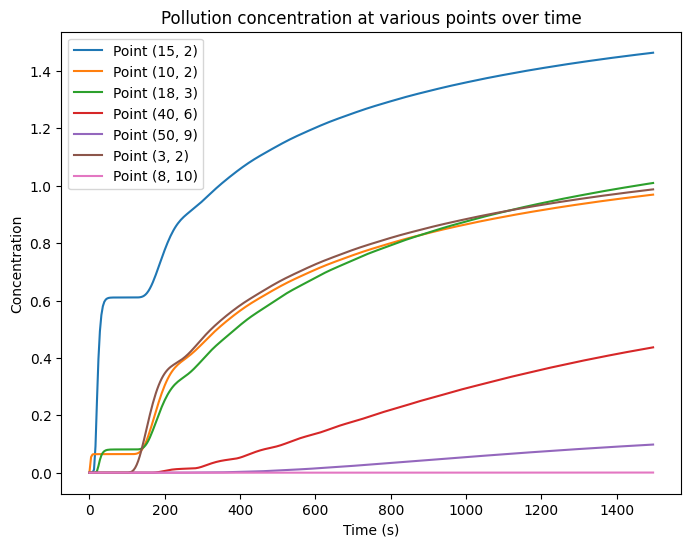

In [ ]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

# Incrreasing the flow speed U0 to 0.5

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.5 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

# Example points to monitor concentration changes
points = [(15, 2),(10,2),(18,3), (40,6),(50,9), (3,2),(8,10)]  # (x, y) coordinates

plt.figure(figsize=(8, 6))
for (px, py) in points:
    i, j = np.argmin(np.abs(x - px)), np.argmin(np.abs(y - py))
    concentration_time_series = [c[i, j] for c in c_save]
    plt.plot(t_save, concentration_time_series, label=f'Point ({px}, {py})')

plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()
plt.title('Pollution concentration at various points over time')
plt.show()

When the flow speed was increased as shown in the plot above, the pollution concentration levels generally showed reduced peaks across most points compared to the original flow speed (first plot). For instance, the concentration at Point (10, 2) peaked at approximately 1.4, significantly lower than its peak in the original flow condition (around 2.6). This suggests that the higher flow velocity led to quicker downstream transport and reduced localized accumulation of pollutants near the source. Furthermore, points further from the source, such as Point (40, 6), exhibited faster response times and earlier transients, as the increased flow expedited the pollutant dispersion and transportation along the river.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


2024-12-27 06:42:49,609 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s


INFO:__main__:Starting main loop


2024-12-27 06:42:49,619 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.906250e+00, dt=3.906250e+00


2024-12-27 06:42:49,678 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e+00, dt=3.906250e+00


INFO:__main__:Iteration=11, Time=4.296875e+01, dt=3.906250e+00


2024-12-27 06:42:49,721 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+01, dt=3.906250e+00


INFO:__main__:Iteration=21, Time=8.203125e+01, dt=3.906250e+00


2024-12-27 06:42:49,763 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+01, dt=3.906250e+00


INFO:__main__:Iteration=31, Time=1.210938e+02, dt=3.906250e+00


2024-12-27 06:42:49,811 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+02, dt=3.906250e+00


INFO:__main__:Iteration=41, Time=1.601562e+02, dt=3.906250e+00


2024-12-27 06:42:49,868 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+02, dt=3.906250e+00


INFO:__main__:Iteration=51, Time=1.992188e+02, dt=3.906250e+00


2024-12-27 06:42:49,912 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+02, dt=3.906250e+00


INFO:__main__:Iteration=61, Time=2.382812e+02, dt=3.906250e+00


2024-12-27 06:42:49,960 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+02, dt=3.906250e+00


INFO:__main__:Iteration=71, Time=2.773438e+02, dt=3.906250e+00


2024-12-27 06:42:50,008 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+02, dt=3.906250e+00


INFO:__main__:Iteration=81, Time=3.164062e+02, dt=3.906250e+00


2024-12-27 06:42:50,049 __main__ 0/1 INFO :: Iteration=81, Time=3.164062e+02, dt=3.906250e+00


INFO:__main__:Iteration=91, Time=3.554688e+02, dt=3.906250e+00


2024-12-27 06:42:50,097 __main__ 0/1 INFO :: Iteration=91, Time=3.554688e+02, dt=3.906250e+00


INFO:__main__:Iteration=101, Time=3.945312e+02, dt=3.906250e+00


2024-12-27 06:42:50,145 __main__ 0/1 INFO :: Iteration=101, Time=3.945312e+02, dt=3.906250e+00


INFO:__main__:Iteration=111, Time=4.335938e+02, dt=3.906250e+00


2024-12-27 06:42:50,195 __main__ 0/1 INFO :: Iteration=111, Time=4.335938e+02, dt=3.906250e+00


INFO:__main__:Iteration=121, Time=4.726562e+02, dt=3.906250e+00


2024-12-27 06:42:50,237 __main__ 0/1 INFO :: Iteration=121, Time=4.726562e+02, dt=3.906250e+00


INFO:__main__:Iteration=131, Time=5.117188e+02, dt=3.906250e+00


2024-12-27 06:42:50,279 __main__ 0/1 INFO :: Iteration=131, Time=5.117188e+02, dt=3.906250e+00


INFO:__main__:Iteration=141, Time=5.507812e+02, dt=3.906250e+00


2024-12-27 06:42:50,320 __main__ 0/1 INFO :: Iteration=141, Time=5.507812e+02, dt=3.906250e+00


INFO:__main__:Iteration=151, Time=5.898438e+02, dt=3.906250e+00


2024-12-27 06:42:50,362 __main__ 0/1 INFO :: Iteration=151, Time=5.898438e+02, dt=3.906250e+00


INFO:__main__:Iteration=161, Time=6.289062e+02, dt=3.906250e+00


2024-12-27 06:42:50,403 __main__ 0/1 INFO :: Iteration=161, Time=6.289062e+02, dt=3.906250e+00


INFO:__main__:Iteration=171, Time=6.679688e+02, dt=3.906250e+00


2024-12-27 06:42:50,444 __main__ 0/1 INFO :: Iteration=171, Time=6.679688e+02, dt=3.906250e+00


INFO:__main__:Iteration=181, Time=7.070312e+02, dt=3.906250e+00


2024-12-27 06:42:50,485 __main__ 0/1 INFO :: Iteration=181, Time=7.070312e+02, dt=3.906250e+00


INFO:__main__:Iteration=191, Time=7.460938e+02, dt=3.906250e+00


2024-12-27 06:42:50,532 __main__ 0/1 INFO :: Iteration=191, Time=7.460938e+02, dt=3.906250e+00


INFO:__main__:Iteration=201, Time=7.851562e+02, dt=3.906250e+00


2024-12-27 06:42:50,583 __main__ 0/1 INFO :: Iteration=201, Time=7.851562e+02, dt=3.906250e+00


INFO:__main__:Iteration=211, Time=8.242188e+02, dt=3.906250e+00


2024-12-27 06:42:50,625 __main__ 0/1 INFO :: Iteration=211, Time=8.242188e+02, dt=3.906250e+00


INFO:__main__:Iteration=221, Time=8.632812e+02, dt=3.906250e+00


2024-12-27 06:42:50,673 __main__ 0/1 INFO :: Iteration=221, Time=8.632812e+02, dt=3.906250e+00


INFO:__main__:Iteration=231, Time=9.023438e+02, dt=3.906250e+00


2024-12-27 06:42:50,716 __main__ 0/1 INFO :: Iteration=231, Time=9.023438e+02, dt=3.906250e+00


INFO:__main__:Iteration=241, Time=9.414062e+02, dt=3.906250e+00


2024-12-27 06:42:50,760 __main__ 0/1 INFO :: Iteration=241, Time=9.414062e+02, dt=3.906250e+00


INFO:__main__:Iteration=251, Time=9.804688e+02, dt=3.906250e+00


2024-12-27 06:42:50,801 __main__ 0/1 INFO :: Iteration=251, Time=9.804688e+02, dt=3.906250e+00


INFO:__main__:Iteration=261, Time=1.019531e+03, dt=3.906250e+00


2024-12-27 06:42:50,844 __main__ 0/1 INFO :: Iteration=261, Time=1.019531e+03, dt=3.906250e+00


INFO:__main__:Iteration=271, Time=1.058594e+03, dt=3.906250e+00


2024-12-27 06:42:50,894 __main__ 0/1 INFO :: Iteration=271, Time=1.058594e+03, dt=3.906250e+00


INFO:__main__:Iteration=281, Time=1.097656e+03, dt=3.906250e+00


2024-12-27 06:42:50,945 __main__ 0/1 INFO :: Iteration=281, Time=1.097656e+03, dt=3.906250e+00


INFO:__main__:Iteration=291, Time=1.136719e+03, dt=3.906250e+00


2024-12-27 06:42:50,994 __main__ 0/1 INFO :: Iteration=291, Time=1.136719e+03, dt=3.906250e+00


INFO:__main__:Iteration=301, Time=1.175781e+03, dt=3.906250e+00


2024-12-27 06:42:51,042 __main__ 0/1 INFO :: Iteration=301, Time=1.175781e+03, dt=3.906250e+00


INFO:__main__:Iteration=311, Time=1.214844e+03, dt=3.906250e+00


2024-12-27 06:42:51,089 __main__ 0/1 INFO :: Iteration=311, Time=1.214844e+03, dt=3.906250e+00


INFO:__main__:Iteration=321, Time=1.253906e+03, dt=3.906250e+00


2024-12-27 06:42:51,147 __main__ 0/1 INFO :: Iteration=321, Time=1.253906e+03, dt=3.906250e+00


INFO:__main__:Iteration=331, Time=1.292969e+03, dt=3.906250e+00


2024-12-27 06:42:51,199 __main__ 0/1 INFO :: Iteration=331, Time=1.292969e+03, dt=3.906250e+00


INFO:__main__:Iteration=341, Time=1.332031e+03, dt=3.906250e+00


2024-12-27 06:42:51,246 __main__ 0/1 INFO :: Iteration=341, Time=1.332031e+03, dt=3.906250e+00


INFO:__main__:Iteration=351, Time=1.371094e+03, dt=3.906250e+00


2024-12-27 06:42:51,303 __main__ 0/1 INFO :: Iteration=351, Time=1.371094e+03, dt=3.906250e+00


INFO:__main__:Iteration=361, Time=1.410156e+03, dt=3.906250e+00


2024-12-27 06:42:51,348 __main__ 0/1 INFO :: Iteration=361, Time=1.410156e+03, dt=3.906250e+00


INFO:__main__:Iteration=371, Time=1.449219e+03, dt=3.906250e+00


2024-12-27 06:42:51,391 __main__ 0/1 INFO :: Iteration=371, Time=1.449219e+03, dt=3.906250e+00


INFO:__main__:Iteration=381, Time=1.488281e+03, dt=3.906250e+00


2024-12-27 06:42:51,433 __main__ 0/1 INFO :: Iteration=381, Time=1.488281e+03, dt=3.906250e+00


INFO:solvers:Simulation stop time reached.


2024-12-27 06:42:51,451 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 384


2024-12-27 06:42:51,462 solvers 0/1 INFO :: Final iteration: 384


INFO:solvers:Final sim time: 1500.0


2024-12-27 06:42:51,467 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.5304 sec


2024-12-27 06:42:51,471 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5304 sec


INFO:solvers:Warmup time (iter 0-10): 0.08823 sec


2024-12-27 06:42:51,473 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.08823 sec


INFO:solvers:Run time (iter 10-end): 1.744 sec


2024-12-27 06:42:51,478 solvers 0/1 INFO :: Run time (iter 10-end): 1.744 sec


INFO:solvers:CPU time (iter 10-end): 0.0004845 cpu-hr


2024-12-27 06:42:51,480 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0004845 cpu-hr


INFO:solvers:Speed: 3.718e+06 mode-stages/cpu-sec


2024-12-27 06:42:51,485 solvers 0/1 INFO :: Speed: 3.718e+06 mode-stages/cpu-sec


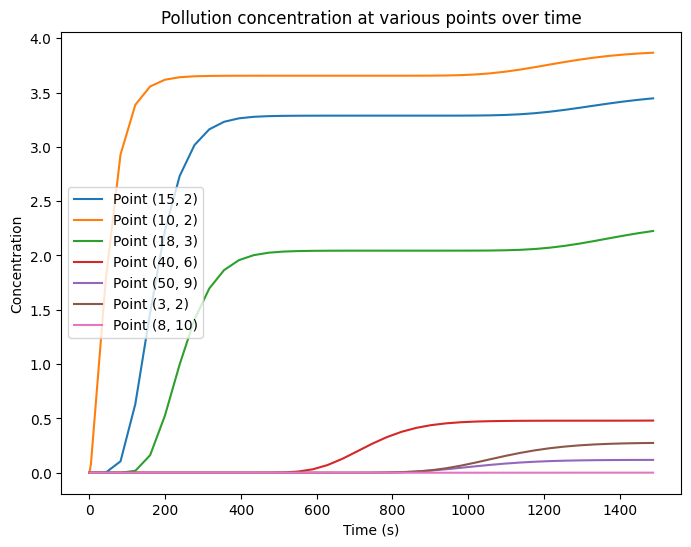

In [ ]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

# Decreasing the flow speed U0 to 0.05

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.05 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

# Example points to monitor concentration changes
points = [(15, 2),(10,2),(18,3), (40,6),(50,9), (3,2),(8,10)]  # (x, y) coordinates

plt.figure(figsize=(8, 6))
for (px, py) in points:
    i, j = np.argmin(np.abs(x - px)), np.argmin(np.abs(y - py))
    concentration_time_series = [c[i, j] for c in c_save]
    plt.plot(t_save, concentration_time_series, label=f'Point ({px}, {py})')

plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()
plt.title('Pollution concentration at various points over time')
plt.show()

When the flow speed was slowed to 0.005, the pollution concentration at Point (10, 2) peaked at approximately 3.7, significantly higher than its peak under the original flow speed. This observation suggests that reduced flow velocity allows more pollutants to accumulate due to slower advection and greater reliance on diffusion, particularly at locations closer to the source. For other points, such as (18, 3) and (40, 6), the slower flow led to extended transient periods, indicating delayed pollutant arrival and dispersion. Also, slower flow velocity led to slower downstream transport and increased localized accumulation of pollutants, which led to generally higher concentration levels across most points compared to the original flow speed.

These comparisons underscore the importance of flow velocity in pollutant dynamics. Faster flow velocities promote downstream transport, reducing localized concentrations near the source, while slower velocities allow pollutants to stay, increasing the concentration near the source but delaying the contamination of distant locations.

### Investigation of How the Pollution Level Depends on $\kappa$

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


2024-12-27 06:52:19,533 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


INFO:__main__:Starting main loop


2024-12-27 06:52:19,542 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.906250e-01, dt=3.906250e-01


2024-12-27 06:52:19,581 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e-01, dt=3.906250e-01


INFO:__main__:Iteration=11, Time=4.296875e+00, dt=3.906250e-01


2024-12-27 06:52:19,613 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+00, dt=3.906250e-01


INFO:__main__:Iteration=21, Time=8.203125e+00, dt=3.906250e-01


2024-12-27 06:52:19,643 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+00, dt=3.906250e-01


INFO:__main__:Iteration=31, Time=1.210938e+01, dt=3.906250e-01


2024-12-27 06:52:19,683 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+01, dt=3.906250e-01


INFO:__main__:Iteration=41, Time=1.601562e+01, dt=3.906250e-01


2024-12-27 06:52:19,711 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+01, dt=3.906250e-01


INFO:__main__:Iteration=51, Time=1.992188e+01, dt=3.906250e-01


2024-12-27 06:52:19,742 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+01, dt=3.906250e-01


INFO:__main__:Iteration=61, Time=2.382812e+01, dt=3.906250e-01


2024-12-27 06:52:19,772 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+01, dt=3.906250e-01


INFO:__main__:Iteration=71, Time=2.773438e+01, dt=3.906250e-01


2024-12-27 06:52:19,868 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+01, dt=3.906250e-01


INFO:__main__:Iteration=81, Time=3.164062e+01, dt=3.906250e-01


2024-12-27 06:52:19,948 __main__ 0/1 INFO :: Iteration=81, Time=3.164062e+01, dt=3.906250e-01


INFO:__main__:Iteration=91, Time=3.554688e+01, dt=3.906250e-01


2024-12-27 06:52:19,997 __main__ 0/1 INFO :: Iteration=91, Time=3.554688e+01, dt=3.906250e-01


INFO:__main__:Iteration=101, Time=3.945312e+01, dt=3.906250e-01


2024-12-27 06:52:20,041 __main__ 0/1 INFO :: Iteration=101, Time=3.945312e+01, dt=3.906250e-01


INFO:__main__:Iteration=111, Time=4.335938e+01, dt=3.906250e-01


2024-12-27 06:52:20,087 __main__ 0/1 INFO :: Iteration=111, Time=4.335938e+01, dt=3.906250e-01


INFO:__main__:Iteration=121, Time=4.726562e+01, dt=3.906250e-01


2024-12-27 06:52:20,133 __main__ 0/1 INFO :: Iteration=121, Time=4.726562e+01, dt=3.906250e-01


INFO:__main__:Iteration=131, Time=5.117188e+01, dt=3.906250e-01


2024-12-27 06:52:20,177 __main__ 0/1 INFO :: Iteration=131, Time=5.117188e+01, dt=3.906250e-01


INFO:__main__:Iteration=141, Time=5.507812e+01, dt=3.906250e-01


2024-12-27 06:52:20,226 __main__ 0/1 INFO :: Iteration=141, Time=5.507812e+01, dt=3.906250e-01


INFO:__main__:Iteration=151, Time=5.898438e+01, dt=3.906250e-01


2024-12-27 06:52:20,269 __main__ 0/1 INFO :: Iteration=151, Time=5.898438e+01, dt=3.906250e-01


INFO:__main__:Iteration=161, Time=6.289062e+01, dt=3.906250e-01


2024-12-27 06:52:20,316 __main__ 0/1 INFO :: Iteration=161, Time=6.289062e+01, dt=3.906250e-01


INFO:__main__:Iteration=171, Time=6.679688e+01, dt=3.906250e-01


2024-12-27 06:52:20,356 __main__ 0/1 INFO :: Iteration=171, Time=6.679688e+01, dt=3.906250e-01


INFO:__main__:Iteration=181, Time=7.070312e+01, dt=3.906250e-01


2024-12-27 06:52:20,397 __main__ 0/1 INFO :: Iteration=181, Time=7.070312e+01, dt=3.906250e-01


INFO:__main__:Iteration=191, Time=7.460938e+01, dt=3.906250e-01


2024-12-27 06:52:20,438 __main__ 0/1 INFO :: Iteration=191, Time=7.460938e+01, dt=3.906250e-01


INFO:__main__:Iteration=201, Time=7.851562e+01, dt=3.906250e-01


2024-12-27 06:52:20,483 __main__ 0/1 INFO :: Iteration=201, Time=7.851562e+01, dt=3.906250e-01


INFO:__main__:Iteration=211, Time=8.242188e+01, dt=3.906250e-01


2024-12-27 06:52:20,523 __main__ 0/1 INFO :: Iteration=211, Time=8.242188e+01, dt=3.906250e-01


INFO:__main__:Iteration=221, Time=8.632812e+01, dt=3.906250e-01


2024-12-27 06:52:20,563 __main__ 0/1 INFO :: Iteration=221, Time=8.632812e+01, dt=3.906250e-01


INFO:__main__:Iteration=231, Time=9.023438e+01, dt=3.906250e-01


2024-12-27 06:52:20,605 __main__ 0/1 INFO :: Iteration=231, Time=9.023438e+01, dt=3.906250e-01


INFO:__main__:Iteration=241, Time=9.414062e+01, dt=3.906250e-01


2024-12-27 06:52:20,645 __main__ 0/1 INFO :: Iteration=241, Time=9.414062e+01, dt=3.906250e-01


INFO:__main__:Iteration=251, Time=9.804688e+01, dt=3.906250e-01


2024-12-27 06:52:20,696 __main__ 0/1 INFO :: Iteration=251, Time=9.804688e+01, dt=3.906250e-01


INFO:__main__:Iteration=261, Time=1.019531e+02, dt=3.906250e-01


2024-12-27 06:52:20,752 __main__ 0/1 INFO :: Iteration=261, Time=1.019531e+02, dt=3.906250e-01


INFO:__main__:Iteration=271, Time=1.058594e+02, dt=3.906250e-01


2024-12-27 06:52:20,796 __main__ 0/1 INFO :: Iteration=271, Time=1.058594e+02, dt=3.906250e-01


INFO:__main__:Iteration=281, Time=1.097656e+02, dt=3.906250e-01


2024-12-27 06:52:20,841 __main__ 0/1 INFO :: Iteration=281, Time=1.097656e+02, dt=3.906250e-01


INFO:__main__:Iteration=291, Time=1.136719e+02, dt=3.906250e-01


2024-12-27 06:52:20,888 __main__ 0/1 INFO :: Iteration=291, Time=1.136719e+02, dt=3.906250e-01


INFO:__main__:Iteration=301, Time=1.175781e+02, dt=3.906250e-01


2024-12-27 06:52:20,941 __main__ 0/1 INFO :: Iteration=301, Time=1.175781e+02, dt=3.906250e-01


INFO:__main__:Iteration=311, Time=1.214844e+02, dt=3.906250e-01


2024-12-27 06:52:20,993 __main__ 0/1 INFO :: Iteration=311, Time=1.214844e+02, dt=3.906250e-01


INFO:__main__:Iteration=321, Time=1.253906e+02, dt=3.906250e-01


2024-12-27 06:52:21,039 __main__ 0/1 INFO :: Iteration=321, Time=1.253906e+02, dt=3.906250e-01


INFO:__main__:Iteration=331, Time=1.292969e+02, dt=3.906250e-01


2024-12-27 06:52:21,080 __main__ 0/1 INFO :: Iteration=331, Time=1.292969e+02, dt=3.906250e-01


INFO:__main__:Iteration=341, Time=1.332031e+02, dt=3.906250e-01


2024-12-27 06:52:21,126 __main__ 0/1 INFO :: Iteration=341, Time=1.332031e+02, dt=3.906250e-01


INFO:__main__:Iteration=351, Time=1.371094e+02, dt=3.906250e-01


2024-12-27 06:52:21,171 __main__ 0/1 INFO :: Iteration=351, Time=1.371094e+02, dt=3.906250e-01


INFO:__main__:Iteration=361, Time=1.410156e+02, dt=3.906250e-01


2024-12-27 06:52:21,216 __main__ 0/1 INFO :: Iteration=361, Time=1.410156e+02, dt=3.906250e-01


INFO:__main__:Iteration=371, Time=1.449219e+02, dt=3.906250e-01


2024-12-27 06:52:21,258 __main__ 0/1 INFO :: Iteration=371, Time=1.449219e+02, dt=3.906250e-01


INFO:__main__:Iteration=381, Time=1.488281e+02, dt=3.906250e-01


2024-12-27 06:52:21,300 __main__ 0/1 INFO :: Iteration=381, Time=1.488281e+02, dt=3.906250e-01


INFO:__main__:Iteration=391, Time=1.527344e+02, dt=3.906250e-01


2024-12-27 06:52:21,345 __main__ 0/1 INFO :: Iteration=391, Time=1.527344e+02, dt=3.906250e-01


INFO:__main__:Iteration=401, Time=1.566406e+02, dt=3.906250e-01


2024-12-27 06:52:21,389 __main__ 0/1 INFO :: Iteration=401, Time=1.566406e+02, dt=3.906250e-01


INFO:__main__:Iteration=411, Time=1.605469e+02, dt=3.906250e-01


2024-12-27 06:52:21,429 __main__ 0/1 INFO :: Iteration=411, Time=1.605469e+02, dt=3.906250e-01


INFO:__main__:Iteration=421, Time=1.644531e+02, dt=3.906250e-01


2024-12-27 06:52:21,468 __main__ 0/1 INFO :: Iteration=421, Time=1.644531e+02, dt=3.906250e-01


INFO:__main__:Iteration=431, Time=1.683594e+02, dt=3.906250e-01


2024-12-27 06:52:21,507 __main__ 0/1 INFO :: Iteration=431, Time=1.683594e+02, dt=3.906250e-01


INFO:__main__:Iteration=441, Time=1.722656e+02, dt=3.906250e-01


2024-12-27 06:52:21,546 __main__ 0/1 INFO :: Iteration=441, Time=1.722656e+02, dt=3.906250e-01


INFO:__main__:Iteration=451, Time=1.761719e+02, dt=3.906250e-01


2024-12-27 06:52:21,585 __main__ 0/1 INFO :: Iteration=451, Time=1.761719e+02, dt=3.906250e-01


INFO:__main__:Iteration=461, Time=1.800781e+02, dt=3.906250e-01


2024-12-27 06:52:21,625 __main__ 0/1 INFO :: Iteration=461, Time=1.800781e+02, dt=3.906250e-01


INFO:__main__:Iteration=471, Time=1.839844e+02, dt=3.906250e-01


2024-12-27 06:52:21,665 __main__ 0/1 INFO :: Iteration=471, Time=1.839844e+02, dt=3.906250e-01


INFO:__main__:Iteration=481, Time=1.878906e+02, dt=3.906250e-01


2024-12-27 06:52:21,704 __main__ 0/1 INFO :: Iteration=481, Time=1.878906e+02, dt=3.906250e-01


INFO:__main__:Iteration=491, Time=1.917969e+02, dt=3.906250e-01


2024-12-27 06:52:21,747 __main__ 0/1 INFO :: Iteration=491, Time=1.917969e+02, dt=3.906250e-01


INFO:__main__:Iteration=501, Time=1.957031e+02, dt=3.906250e-01


2024-12-27 06:52:21,797 __main__ 0/1 INFO :: Iteration=501, Time=1.957031e+02, dt=3.906250e-01


INFO:__main__:Iteration=511, Time=1.996094e+02, dt=3.906250e-01


2024-12-27 06:52:21,859 __main__ 0/1 INFO :: Iteration=511, Time=1.996094e+02, dt=3.906250e-01


INFO:__main__:Iteration=521, Time=2.035156e+02, dt=3.906250e-01


2024-12-27 06:52:21,908 __main__ 0/1 INFO :: Iteration=521, Time=2.035156e+02, dt=3.906250e-01


INFO:__main__:Iteration=531, Time=2.074219e+02, dt=3.906250e-01


2024-12-27 06:52:21,956 __main__ 0/1 INFO :: Iteration=531, Time=2.074219e+02, dt=3.906250e-01


INFO:__main__:Iteration=541, Time=2.113281e+02, dt=3.906250e-01


2024-12-27 06:52:22,012 __main__ 0/1 INFO :: Iteration=541, Time=2.113281e+02, dt=3.906250e-01


INFO:__main__:Iteration=551, Time=2.152344e+02, dt=3.906250e-01


2024-12-27 06:52:22,056 __main__ 0/1 INFO :: Iteration=551, Time=2.152344e+02, dt=3.906250e-01


INFO:__main__:Iteration=561, Time=2.191406e+02, dt=3.906250e-01


2024-12-27 06:52:22,097 __main__ 0/1 INFO :: Iteration=561, Time=2.191406e+02, dt=3.906250e-01


INFO:__main__:Iteration=571, Time=2.230469e+02, dt=3.906250e-01


2024-12-27 06:52:22,137 __main__ 0/1 INFO :: Iteration=571, Time=2.230469e+02, dt=3.906250e-01


INFO:__main__:Iteration=581, Time=2.269531e+02, dt=3.906250e-01


2024-12-27 06:52:22,184 __main__ 0/1 INFO :: Iteration=581, Time=2.269531e+02, dt=3.906250e-01


INFO:__main__:Iteration=591, Time=2.308594e+02, dt=3.906250e-01


2024-12-27 06:52:22,226 __main__ 0/1 INFO :: Iteration=591, Time=2.308594e+02, dt=3.906250e-01


INFO:__main__:Iteration=601, Time=2.347656e+02, dt=3.906250e-01


2024-12-27 06:52:22,272 __main__ 0/1 INFO :: Iteration=601, Time=2.347656e+02, dt=3.906250e-01


INFO:__main__:Iteration=611, Time=2.386719e+02, dt=3.906250e-01


2024-12-27 06:52:22,314 __main__ 0/1 INFO :: Iteration=611, Time=2.386719e+02, dt=3.906250e-01


INFO:__main__:Iteration=621, Time=2.425781e+02, dt=3.906250e-01


2024-12-27 06:52:22,358 __main__ 0/1 INFO :: Iteration=621, Time=2.425781e+02, dt=3.906250e-01


INFO:__main__:Iteration=631, Time=2.464844e+02, dt=3.906250e-01


2024-12-27 06:52:22,402 __main__ 0/1 INFO :: Iteration=631, Time=2.464844e+02, dt=3.906250e-01


INFO:__main__:Iteration=641, Time=2.503906e+02, dt=3.906250e-01


2024-12-27 06:52:22,443 __main__ 0/1 INFO :: Iteration=641, Time=2.503906e+02, dt=3.906250e-01


INFO:__main__:Iteration=651, Time=2.542969e+02, dt=3.906250e-01


2024-12-27 06:52:22,485 __main__ 0/1 INFO :: Iteration=651, Time=2.542969e+02, dt=3.906250e-01


INFO:__main__:Iteration=661, Time=2.582031e+02, dt=3.906250e-01


2024-12-27 06:52:22,527 __main__ 0/1 INFO :: Iteration=661, Time=2.582031e+02, dt=3.906250e-01


INFO:__main__:Iteration=671, Time=2.621094e+02, dt=3.906250e-01


2024-12-27 06:52:22,566 __main__ 0/1 INFO :: Iteration=671, Time=2.621094e+02, dt=3.906250e-01


INFO:__main__:Iteration=681, Time=2.660156e+02, dt=3.906250e-01


2024-12-27 06:52:22,603 __main__ 0/1 INFO :: Iteration=681, Time=2.660156e+02, dt=3.906250e-01


INFO:__main__:Iteration=691, Time=2.699219e+02, dt=3.906250e-01


2024-12-27 06:52:22,643 __main__ 0/1 INFO :: Iteration=691, Time=2.699219e+02, dt=3.906250e-01


INFO:__main__:Iteration=701, Time=2.738281e+02, dt=3.906250e-01


2024-12-27 06:52:22,688 __main__ 0/1 INFO :: Iteration=701, Time=2.738281e+02, dt=3.906250e-01


INFO:__main__:Iteration=711, Time=2.777344e+02, dt=3.906250e-01


2024-12-27 06:52:22,731 __main__ 0/1 INFO :: Iteration=711, Time=2.777344e+02, dt=3.906250e-01


INFO:__main__:Iteration=721, Time=2.816406e+02, dt=3.906250e-01


2024-12-27 06:52:22,778 __main__ 0/1 INFO :: Iteration=721, Time=2.816406e+02, dt=3.906250e-01


INFO:__main__:Iteration=731, Time=2.855469e+02, dt=3.906250e-01


2024-12-27 06:52:22,838 __main__ 0/1 INFO :: Iteration=731, Time=2.855469e+02, dt=3.906250e-01


INFO:__main__:Iteration=741, Time=2.894531e+02, dt=3.906250e-01


2024-12-27 06:52:22,899 __main__ 0/1 INFO :: Iteration=741, Time=2.894531e+02, dt=3.906250e-01


INFO:__main__:Iteration=751, Time=2.933594e+02, dt=3.906250e-01


2024-12-27 06:52:22,955 __main__ 0/1 INFO :: Iteration=751, Time=2.933594e+02, dt=3.906250e-01


INFO:__main__:Iteration=761, Time=2.972656e+02, dt=3.906250e-01


2024-12-27 06:52:23,002 __main__ 0/1 INFO :: Iteration=761, Time=2.972656e+02, dt=3.906250e-01


INFO:__main__:Iteration=771, Time=3.011719e+02, dt=3.906250e-01


2024-12-27 06:52:23,056 __main__ 0/1 INFO :: Iteration=771, Time=3.011719e+02, dt=3.906250e-01


INFO:__main__:Iteration=781, Time=3.050781e+02, dt=3.906250e-01


2024-12-27 06:52:23,103 __main__ 0/1 INFO :: Iteration=781, Time=3.050781e+02, dt=3.906250e-01


INFO:__main__:Iteration=791, Time=3.089844e+02, dt=3.906250e-01


2024-12-27 06:52:23,152 __main__ 0/1 INFO :: Iteration=791, Time=3.089844e+02, dt=3.906250e-01


INFO:__main__:Iteration=801, Time=3.128906e+02, dt=3.906250e-01


2024-12-27 06:52:23,199 __main__ 0/1 INFO :: Iteration=801, Time=3.128906e+02, dt=3.906250e-01


INFO:__main__:Iteration=811, Time=3.167969e+02, dt=3.906250e-01


2024-12-27 06:52:23,249 __main__ 0/1 INFO :: Iteration=811, Time=3.167969e+02, dt=3.906250e-01


INFO:__main__:Iteration=821, Time=3.207031e+02, dt=3.906250e-01


2024-12-27 06:52:23,297 __main__ 0/1 INFO :: Iteration=821, Time=3.207031e+02, dt=3.906250e-01


INFO:__main__:Iteration=831, Time=3.246094e+02, dt=3.906250e-01


2024-12-27 06:52:23,347 __main__ 0/1 INFO :: Iteration=831, Time=3.246094e+02, dt=3.906250e-01


INFO:__main__:Iteration=841, Time=3.285156e+02, dt=3.906250e-01


2024-12-27 06:52:23,394 __main__ 0/1 INFO :: Iteration=841, Time=3.285156e+02, dt=3.906250e-01


INFO:__main__:Iteration=851, Time=3.324219e+02, dt=3.906250e-01


2024-12-27 06:52:23,441 __main__ 0/1 INFO :: Iteration=851, Time=3.324219e+02, dt=3.906250e-01


INFO:__main__:Iteration=861, Time=3.363281e+02, dt=3.906250e-01


2024-12-27 06:52:23,485 __main__ 0/1 INFO :: Iteration=861, Time=3.363281e+02, dt=3.906250e-01


INFO:__main__:Iteration=871, Time=3.402344e+02, dt=3.906250e-01


2024-12-27 06:52:23,529 __main__ 0/1 INFO :: Iteration=871, Time=3.402344e+02, dt=3.906250e-01


INFO:__main__:Iteration=881, Time=3.441406e+02, dt=3.906250e-01


2024-12-27 06:52:23,569 __main__ 0/1 INFO :: Iteration=881, Time=3.441406e+02, dt=3.906250e-01


INFO:__main__:Iteration=891, Time=3.480469e+02, dt=3.906250e-01


2024-12-27 06:52:23,608 __main__ 0/1 INFO :: Iteration=891, Time=3.480469e+02, dt=3.906250e-01


INFO:__main__:Iteration=901, Time=3.519531e+02, dt=3.906250e-01


2024-12-27 06:52:23,650 __main__ 0/1 INFO :: Iteration=901, Time=3.519531e+02, dt=3.906250e-01


INFO:__main__:Iteration=911, Time=3.558594e+02, dt=3.906250e-01


2024-12-27 06:52:23,692 __main__ 0/1 INFO :: Iteration=911, Time=3.558594e+02, dt=3.906250e-01


INFO:__main__:Iteration=921, Time=3.597656e+02, dt=3.906250e-01


2024-12-27 06:52:23,735 __main__ 0/1 INFO :: Iteration=921, Time=3.597656e+02, dt=3.906250e-01


INFO:__main__:Iteration=931, Time=3.636719e+02, dt=3.906250e-01


2024-12-27 06:52:23,783 __main__ 0/1 INFO :: Iteration=931, Time=3.636719e+02, dt=3.906250e-01


INFO:__main__:Iteration=941, Time=3.675781e+02, dt=3.906250e-01


2024-12-27 06:52:23,831 __main__ 0/1 INFO :: Iteration=941, Time=3.675781e+02, dt=3.906250e-01


INFO:__main__:Iteration=951, Time=3.714844e+02, dt=3.906250e-01


2024-12-27 06:52:23,878 __main__ 0/1 INFO :: Iteration=951, Time=3.714844e+02, dt=3.906250e-01


INFO:__main__:Iteration=961, Time=3.753906e+02, dt=3.906250e-01


2024-12-27 06:52:23,929 __main__ 0/1 INFO :: Iteration=961, Time=3.753906e+02, dt=3.906250e-01


INFO:__main__:Iteration=971, Time=3.792969e+02, dt=3.906250e-01


2024-12-27 06:52:24,023 __main__ 0/1 INFO :: Iteration=971, Time=3.792969e+02, dt=3.906250e-01


INFO:__main__:Iteration=981, Time=3.832031e+02, dt=3.906250e-01


2024-12-27 06:52:24,148 __main__ 0/1 INFO :: Iteration=981, Time=3.832031e+02, dt=3.906250e-01


INFO:__main__:Iteration=991, Time=3.871094e+02, dt=3.906250e-01


2024-12-27 06:52:24,236 __main__ 0/1 INFO :: Iteration=991, Time=3.871094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1001, Time=3.910156e+02, dt=3.906250e-01


2024-12-27 06:52:24,319 __main__ 0/1 INFO :: Iteration=1001, Time=3.910156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1011, Time=3.949219e+02, dt=3.906250e-01


2024-12-27 06:52:24,397 __main__ 0/1 INFO :: Iteration=1011, Time=3.949219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1021, Time=3.988281e+02, dt=3.906250e-01


2024-12-27 06:52:24,456 __main__ 0/1 INFO :: Iteration=1021, Time=3.988281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1031, Time=4.027344e+02, dt=3.906250e-01


2024-12-27 06:52:24,525 __main__ 0/1 INFO :: Iteration=1031, Time=4.027344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1041, Time=4.066406e+02, dt=3.906250e-01


2024-12-27 06:52:24,577 __main__ 0/1 INFO :: Iteration=1041, Time=4.066406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1051, Time=4.105469e+02, dt=3.906250e-01


2024-12-27 06:52:24,636 __main__ 0/1 INFO :: Iteration=1051, Time=4.105469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1061, Time=4.144531e+02, dt=3.906250e-01


2024-12-27 06:52:24,685 __main__ 0/1 INFO :: Iteration=1061, Time=4.144531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1071, Time=4.183594e+02, dt=3.906250e-01


2024-12-27 06:52:24,744 __main__ 0/1 INFO :: Iteration=1071, Time=4.183594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1081, Time=4.222656e+02, dt=3.906250e-01


2024-12-27 06:52:24,799 __main__ 0/1 INFO :: Iteration=1081, Time=4.222656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1091, Time=4.261719e+02, dt=3.906250e-01


2024-12-27 06:52:24,872 __main__ 0/1 INFO :: Iteration=1091, Time=4.261719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1101, Time=4.300781e+02, dt=3.906250e-01


2024-12-27 06:52:24,932 __main__ 0/1 INFO :: Iteration=1101, Time=4.300781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1111, Time=4.339844e+02, dt=3.906250e-01


2024-12-27 06:52:24,985 __main__ 0/1 INFO :: Iteration=1111, Time=4.339844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1121, Time=4.378906e+02, dt=3.906250e-01


2024-12-27 06:52:25,050 __main__ 0/1 INFO :: Iteration=1121, Time=4.378906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1131, Time=4.417969e+02, dt=3.906250e-01


2024-12-27 06:52:25,084 __main__ 0/1 INFO :: Iteration=1131, Time=4.417969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1141, Time=4.457031e+02, dt=3.906250e-01


2024-12-27 06:52:25,114 __main__ 0/1 INFO :: Iteration=1141, Time=4.457031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1151, Time=4.496094e+02, dt=3.906250e-01


2024-12-27 06:52:25,147 __main__ 0/1 INFO :: Iteration=1151, Time=4.496094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1161, Time=4.535156e+02, dt=3.906250e-01


2024-12-27 06:52:25,179 __main__ 0/1 INFO :: Iteration=1161, Time=4.535156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1171, Time=4.574219e+02, dt=3.906250e-01


2024-12-27 06:52:25,212 __main__ 0/1 INFO :: Iteration=1171, Time=4.574219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1181, Time=4.613281e+02, dt=3.906250e-01


2024-12-27 06:52:25,242 __main__ 0/1 INFO :: Iteration=1181, Time=4.613281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1191, Time=4.652344e+02, dt=3.906250e-01


2024-12-27 06:52:25,275 __main__ 0/1 INFO :: Iteration=1191, Time=4.652344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1201, Time=4.691406e+02, dt=3.906250e-01


2024-12-27 06:52:25,306 __main__ 0/1 INFO :: Iteration=1201, Time=4.691406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1211, Time=4.730469e+02, dt=3.906250e-01


2024-12-27 06:52:25,337 __main__ 0/1 INFO :: Iteration=1211, Time=4.730469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1221, Time=4.769531e+02, dt=3.906250e-01


2024-12-27 06:52:25,369 __main__ 0/1 INFO :: Iteration=1221, Time=4.769531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1231, Time=4.808594e+02, dt=3.906250e-01


2024-12-27 06:52:25,401 __main__ 0/1 INFO :: Iteration=1231, Time=4.808594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1241, Time=4.847656e+02, dt=3.906250e-01


2024-12-27 06:52:25,433 __main__ 0/1 INFO :: Iteration=1241, Time=4.847656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1251, Time=4.886719e+02, dt=3.906250e-01


2024-12-27 06:52:25,466 __main__ 0/1 INFO :: Iteration=1251, Time=4.886719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1261, Time=4.925781e+02, dt=3.906250e-01


2024-12-27 06:52:25,501 __main__ 0/1 INFO :: Iteration=1261, Time=4.925781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1271, Time=4.964844e+02, dt=3.906250e-01


2024-12-27 06:52:25,550 __main__ 0/1 INFO :: Iteration=1271, Time=4.964844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1281, Time=5.003906e+02, dt=3.906250e-01


2024-12-27 06:52:25,594 __main__ 0/1 INFO :: Iteration=1281, Time=5.003906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1291, Time=5.042969e+02, dt=3.906250e-01


2024-12-27 06:52:25,641 __main__ 0/1 INFO :: Iteration=1291, Time=5.042969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1301, Time=5.082031e+02, dt=3.906250e-01


2024-12-27 06:52:25,675 __main__ 0/1 INFO :: Iteration=1301, Time=5.082031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1311, Time=5.121094e+02, dt=3.906250e-01


2024-12-27 06:52:25,706 __main__ 0/1 INFO :: Iteration=1311, Time=5.121094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1321, Time=5.160156e+02, dt=3.906250e-01


2024-12-27 06:52:25,740 __main__ 0/1 INFO :: Iteration=1321, Time=5.160156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1331, Time=5.199219e+02, dt=3.906250e-01


2024-12-27 06:52:25,775 __main__ 0/1 INFO :: Iteration=1331, Time=5.199219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1341, Time=5.238281e+02, dt=3.906250e-01


2024-12-27 06:52:25,818 __main__ 0/1 INFO :: Iteration=1341, Time=5.238281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1351, Time=5.277344e+02, dt=3.906250e-01


2024-12-27 06:52:25,858 __main__ 0/1 INFO :: Iteration=1351, Time=5.277344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1361, Time=5.316406e+02, dt=3.906250e-01


2024-12-27 06:52:25,922 __main__ 0/1 INFO :: Iteration=1361, Time=5.316406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1371, Time=5.355469e+02, dt=3.906250e-01


2024-12-27 06:52:25,987 __main__ 0/1 INFO :: Iteration=1371, Time=5.355469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1381, Time=5.394531e+02, dt=3.906250e-01


2024-12-27 06:52:26,082 __main__ 0/1 INFO :: Iteration=1381, Time=5.394531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1391, Time=5.433594e+02, dt=3.906250e-01


2024-12-27 06:52:26,159 __main__ 0/1 INFO :: Iteration=1391, Time=5.433594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1401, Time=5.472656e+02, dt=3.906250e-01


2024-12-27 06:52:26,221 __main__ 0/1 INFO :: Iteration=1401, Time=5.472656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1411, Time=5.511719e+02, dt=3.906250e-01


2024-12-27 06:52:26,275 __main__ 0/1 INFO :: Iteration=1411, Time=5.511719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1421, Time=5.550781e+02, dt=3.906250e-01


2024-12-27 06:52:26,318 __main__ 0/1 INFO :: Iteration=1421, Time=5.550781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1431, Time=5.589844e+02, dt=3.906250e-01


2024-12-27 06:52:26,363 __main__ 0/1 INFO :: Iteration=1431, Time=5.589844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1441, Time=5.628906e+02, dt=3.906250e-01


2024-12-27 06:52:26,413 __main__ 0/1 INFO :: Iteration=1441, Time=5.628906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1451, Time=5.667969e+02, dt=3.906250e-01


2024-12-27 06:52:26,462 __main__ 0/1 INFO :: Iteration=1451, Time=5.667969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1461, Time=5.707031e+02, dt=3.906250e-01


2024-12-27 06:52:26,508 __main__ 0/1 INFO :: Iteration=1461, Time=5.707031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1471, Time=5.746094e+02, dt=3.906250e-01


2024-12-27 06:52:26,554 __main__ 0/1 INFO :: Iteration=1471, Time=5.746094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1481, Time=5.785156e+02, dt=3.906250e-01


2024-12-27 06:52:26,601 __main__ 0/1 INFO :: Iteration=1481, Time=5.785156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1491, Time=5.824219e+02, dt=3.906250e-01


2024-12-27 06:52:26,660 __main__ 0/1 INFO :: Iteration=1491, Time=5.824219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1501, Time=5.863281e+02, dt=3.906250e-01


2024-12-27 06:52:26,703 __main__ 0/1 INFO :: Iteration=1501, Time=5.863281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1511, Time=5.902344e+02, dt=3.906250e-01


2024-12-27 06:52:26,734 __main__ 0/1 INFO :: Iteration=1511, Time=5.902344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1521, Time=5.941406e+02, dt=3.906250e-01


2024-12-27 06:52:26,768 __main__ 0/1 INFO :: Iteration=1521, Time=5.941406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1531, Time=5.980469e+02, dt=3.906250e-01


2024-12-27 06:52:26,809 __main__ 0/1 INFO :: Iteration=1531, Time=5.980469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1541, Time=6.019531e+02, dt=3.906250e-01


2024-12-27 06:52:26,848 __main__ 0/1 INFO :: Iteration=1541, Time=6.019531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1551, Time=6.058594e+02, dt=3.906250e-01


2024-12-27 06:52:26,891 __main__ 0/1 INFO :: Iteration=1551, Time=6.058594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1561, Time=6.097656e+02, dt=3.906250e-01


2024-12-27 06:52:26,932 __main__ 0/1 INFO :: Iteration=1561, Time=6.097656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1571, Time=6.136719e+02, dt=3.906250e-01


2024-12-27 06:52:26,974 __main__ 0/1 INFO :: Iteration=1571, Time=6.136719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1581, Time=6.175781e+02, dt=3.906250e-01


2024-12-27 06:52:27,009 __main__ 0/1 INFO :: Iteration=1581, Time=6.175781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1591, Time=6.214844e+02, dt=3.906250e-01


2024-12-27 06:52:27,041 __main__ 0/1 INFO :: Iteration=1591, Time=6.214844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1601, Time=6.253906e+02, dt=3.906250e-01


2024-12-27 06:52:27,080 __main__ 0/1 INFO :: Iteration=1601, Time=6.253906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1611, Time=6.292969e+02, dt=3.906250e-01


2024-12-27 06:52:27,111 __main__ 0/1 INFO :: Iteration=1611, Time=6.292969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1621, Time=6.332031e+02, dt=3.906250e-01


2024-12-27 06:52:27,154 __main__ 0/1 INFO :: Iteration=1621, Time=6.332031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1631, Time=6.371094e+02, dt=3.906250e-01


2024-12-27 06:52:27,186 __main__ 0/1 INFO :: Iteration=1631, Time=6.371094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1641, Time=6.410156e+02, dt=3.906250e-01


2024-12-27 06:52:27,220 __main__ 0/1 INFO :: Iteration=1641, Time=6.410156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1651, Time=6.449219e+02, dt=3.906250e-01


2024-12-27 06:52:27,253 __main__ 0/1 INFO :: Iteration=1651, Time=6.449219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1661, Time=6.488281e+02, dt=3.906250e-01


2024-12-27 06:52:27,283 __main__ 0/1 INFO :: Iteration=1661, Time=6.488281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1671, Time=6.527344e+02, dt=3.906250e-01


2024-12-27 06:52:27,317 __main__ 0/1 INFO :: Iteration=1671, Time=6.527344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1681, Time=6.566406e+02, dt=3.906250e-01


2024-12-27 06:52:27,349 __main__ 0/1 INFO :: Iteration=1681, Time=6.566406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1691, Time=6.605469e+02, dt=3.906250e-01


2024-12-27 06:52:27,380 __main__ 0/1 INFO :: Iteration=1691, Time=6.605469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1701, Time=6.644531e+02, dt=3.906250e-01


2024-12-27 06:52:27,412 __main__ 0/1 INFO :: Iteration=1701, Time=6.644531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1711, Time=6.683594e+02, dt=3.906250e-01


2024-12-27 06:52:27,444 __main__ 0/1 INFO :: Iteration=1711, Time=6.683594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1721, Time=6.722656e+02, dt=3.906250e-01


2024-12-27 06:52:27,488 __main__ 0/1 INFO :: Iteration=1721, Time=6.722656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1731, Time=6.761719e+02, dt=3.906250e-01


2024-12-27 06:52:27,537 __main__ 0/1 INFO :: Iteration=1731, Time=6.761719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1741, Time=6.800781e+02, dt=3.906250e-01


2024-12-27 06:52:27,584 __main__ 0/1 INFO :: Iteration=1741, Time=6.800781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1751, Time=6.839844e+02, dt=3.906250e-01


2024-12-27 06:52:27,618 __main__ 0/1 INFO :: Iteration=1751, Time=6.839844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1761, Time=6.878906e+02, dt=3.906250e-01


2024-12-27 06:52:27,656 __main__ 0/1 INFO :: Iteration=1761, Time=6.878906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1771, Time=6.917969e+02, dt=3.906250e-01


2024-12-27 06:52:27,690 __main__ 0/1 INFO :: Iteration=1771, Time=6.917969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1781, Time=6.957031e+02, dt=3.906250e-01


2024-12-27 06:52:27,723 __main__ 0/1 INFO :: Iteration=1781, Time=6.957031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1791, Time=6.996094e+02, dt=3.906250e-01


2024-12-27 06:52:27,755 __main__ 0/1 INFO :: Iteration=1791, Time=6.996094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1801, Time=7.035156e+02, dt=3.906250e-01


2024-12-27 06:52:27,791 __main__ 0/1 INFO :: Iteration=1801, Time=7.035156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1811, Time=7.074219e+02, dt=3.906250e-01


2024-12-27 06:52:27,834 __main__ 0/1 INFO :: Iteration=1811, Time=7.074219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1821, Time=7.113281e+02, dt=3.906250e-01


2024-12-27 06:52:27,877 __main__ 0/1 INFO :: Iteration=1821, Time=7.113281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1831, Time=7.152344e+02, dt=3.906250e-01


2024-12-27 06:52:27,914 __main__ 0/1 INFO :: Iteration=1831, Time=7.152344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1841, Time=7.191406e+02, dt=3.906250e-01


2024-12-27 06:52:27,956 __main__ 0/1 INFO :: Iteration=1841, Time=7.191406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1851, Time=7.230469e+02, dt=3.906250e-01


2024-12-27 06:52:28,003 __main__ 0/1 INFO :: Iteration=1851, Time=7.230469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1861, Time=7.269531e+02, dt=3.906250e-01


2024-12-27 06:52:28,045 __main__ 0/1 INFO :: Iteration=1861, Time=7.269531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1871, Time=7.308594e+02, dt=3.906250e-01


2024-12-27 06:52:28,083 __main__ 0/1 INFO :: Iteration=1871, Time=7.308594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1881, Time=7.347656e+02, dt=3.906250e-01


2024-12-27 06:52:28,124 __main__ 0/1 INFO :: Iteration=1881, Time=7.347656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1891, Time=7.386719e+02, dt=3.906250e-01


2024-12-27 06:52:28,205 __main__ 0/1 INFO :: Iteration=1891, Time=7.386719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1901, Time=7.425781e+02, dt=3.906250e-01


2024-12-27 06:52:28,249 __main__ 0/1 INFO :: Iteration=1901, Time=7.425781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1911, Time=7.464844e+02, dt=3.906250e-01


2024-12-27 06:52:28,280 __main__ 0/1 INFO :: Iteration=1911, Time=7.464844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1921, Time=7.503906e+02, dt=3.906250e-01


2024-12-27 06:52:28,313 __main__ 0/1 INFO :: Iteration=1921, Time=7.503906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1931, Time=7.542969e+02, dt=3.906250e-01


2024-12-27 06:52:28,348 __main__ 0/1 INFO :: Iteration=1931, Time=7.542969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1941, Time=7.582031e+02, dt=3.906250e-01


2024-12-27 06:52:28,383 __main__ 0/1 INFO :: Iteration=1941, Time=7.582031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1951, Time=7.621094e+02, dt=3.906250e-01


2024-12-27 06:52:28,415 __main__ 0/1 INFO :: Iteration=1951, Time=7.621094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1961, Time=7.660156e+02, dt=3.906250e-01


2024-12-27 06:52:28,472 __main__ 0/1 INFO :: Iteration=1961, Time=7.660156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1971, Time=7.699219e+02, dt=3.906250e-01


2024-12-27 06:52:28,536 __main__ 0/1 INFO :: Iteration=1971, Time=7.699219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1981, Time=7.738281e+02, dt=3.906250e-01


2024-12-27 06:52:28,587 __main__ 0/1 INFO :: Iteration=1981, Time=7.738281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1991, Time=7.777344e+02, dt=3.906250e-01


2024-12-27 06:52:28,641 __main__ 0/1 INFO :: Iteration=1991, Time=7.777344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2001, Time=7.816406e+02, dt=3.906250e-01


2024-12-27 06:52:28,699 __main__ 0/1 INFO :: Iteration=2001, Time=7.816406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2011, Time=7.855469e+02, dt=3.906250e-01


2024-12-27 06:52:28,754 __main__ 0/1 INFO :: Iteration=2011, Time=7.855469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2021, Time=7.894531e+02, dt=3.906250e-01


2024-12-27 06:52:28,830 __main__ 0/1 INFO :: Iteration=2021, Time=7.894531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2031, Time=7.933594e+02, dt=3.906250e-01


2024-12-27 06:52:28,903 __main__ 0/1 INFO :: Iteration=2031, Time=7.933594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2041, Time=7.972656e+02, dt=3.906250e-01


2024-12-27 06:52:28,969 __main__ 0/1 INFO :: Iteration=2041, Time=7.972656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2051, Time=8.011719e+02, dt=3.906250e-01


2024-12-27 06:52:29,019 __main__ 0/1 INFO :: Iteration=2051, Time=8.011719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2061, Time=8.050781e+02, dt=3.906250e-01


2024-12-27 06:52:29,068 __main__ 0/1 INFO :: Iteration=2061, Time=8.050781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2071, Time=8.089844e+02, dt=3.906250e-01


2024-12-27 06:52:29,117 __main__ 0/1 INFO :: Iteration=2071, Time=8.089844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2081, Time=8.128906e+02, dt=3.906250e-01


2024-12-27 06:52:29,171 __main__ 0/1 INFO :: Iteration=2081, Time=8.128906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2091, Time=8.167969e+02, dt=3.906250e-01


2024-12-27 06:52:29,229 __main__ 0/1 INFO :: Iteration=2091, Time=8.167969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2101, Time=8.207031e+02, dt=3.906250e-01


2024-12-27 06:52:29,262 __main__ 0/1 INFO :: Iteration=2101, Time=8.207031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2111, Time=8.246094e+02, dt=3.906250e-01


2024-12-27 06:52:29,296 __main__ 0/1 INFO :: Iteration=2111, Time=8.246094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2121, Time=8.285156e+02, dt=3.906250e-01


2024-12-27 06:52:29,327 __main__ 0/1 INFO :: Iteration=2121, Time=8.285156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2131, Time=8.324219e+02, dt=3.906250e-01


2024-12-27 06:52:29,360 __main__ 0/1 INFO :: Iteration=2131, Time=8.324219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2141, Time=8.363281e+02, dt=3.906250e-01


2024-12-27 06:52:29,394 __main__ 0/1 INFO :: Iteration=2141, Time=8.363281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2151, Time=8.402344e+02, dt=3.906250e-01


2024-12-27 06:52:29,437 __main__ 0/1 INFO :: Iteration=2151, Time=8.402344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2161, Time=8.441406e+02, dt=3.906250e-01


2024-12-27 06:52:29,493 __main__ 0/1 INFO :: Iteration=2161, Time=8.441406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2171, Time=8.480469e+02, dt=3.906250e-01


2024-12-27 06:52:29,544 __main__ 0/1 INFO :: Iteration=2171, Time=8.480469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2181, Time=8.519531e+02, dt=3.906250e-01


2024-12-27 06:52:29,603 __main__ 0/1 INFO :: Iteration=2181, Time=8.519531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2191, Time=8.558594e+02, dt=3.906250e-01


2024-12-27 06:52:29,636 __main__ 0/1 INFO :: Iteration=2191, Time=8.558594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2201, Time=8.597656e+02, dt=3.906250e-01


2024-12-27 06:52:29,668 __main__ 0/1 INFO :: Iteration=2201, Time=8.597656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2211, Time=8.636719e+02, dt=3.906250e-01


2024-12-27 06:52:29,701 __main__ 0/1 INFO :: Iteration=2211, Time=8.636719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2221, Time=8.675781e+02, dt=3.906250e-01


2024-12-27 06:52:29,733 __main__ 0/1 INFO :: Iteration=2221, Time=8.675781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2231, Time=8.714844e+02, dt=3.906250e-01


2024-12-27 06:52:29,766 __main__ 0/1 INFO :: Iteration=2231, Time=8.714844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2241, Time=8.753906e+02, dt=3.906250e-01


2024-12-27 06:52:29,810 __main__ 0/1 INFO :: Iteration=2241, Time=8.753906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2251, Time=8.792969e+02, dt=3.906250e-01


2024-12-27 06:52:29,849 __main__ 0/1 INFO :: Iteration=2251, Time=8.792969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2261, Time=8.832031e+02, dt=3.906250e-01


2024-12-27 06:52:29,924 __main__ 0/1 INFO :: Iteration=2261, Time=8.832031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2271, Time=8.871094e+02, dt=3.906250e-01


2024-12-27 06:52:29,987 __main__ 0/1 INFO :: Iteration=2271, Time=8.871094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2281, Time=8.910156e+02, dt=3.906250e-01


2024-12-27 06:52:30,066 __main__ 0/1 INFO :: Iteration=2281, Time=8.910156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2291, Time=8.949219e+02, dt=3.906250e-01


2024-12-27 06:52:30,119 __main__ 0/1 INFO :: Iteration=2291, Time=8.949219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2301, Time=8.988281e+02, dt=3.906250e-01


2024-12-27 06:52:30,176 __main__ 0/1 INFO :: Iteration=2301, Time=8.988281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2311, Time=9.027344e+02, dt=3.906250e-01


2024-12-27 06:52:30,244 __main__ 0/1 INFO :: Iteration=2311, Time=9.027344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2321, Time=9.066406e+02, dt=3.906250e-01


2024-12-27 06:52:30,304 __main__ 0/1 INFO :: Iteration=2321, Time=9.066406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2331, Time=9.105469e+02, dt=3.906250e-01


2024-12-27 06:52:30,366 __main__ 0/1 INFO :: Iteration=2331, Time=9.105469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2341, Time=9.144531e+02, dt=3.906250e-01


2024-12-27 06:52:30,415 __main__ 0/1 INFO :: Iteration=2341, Time=9.144531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2351, Time=9.183594e+02, dt=3.906250e-01


2024-12-27 06:52:30,466 __main__ 0/1 INFO :: Iteration=2351, Time=9.183594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2361, Time=9.222656e+02, dt=3.906250e-01


2024-12-27 06:52:30,522 __main__ 0/1 INFO :: Iteration=2361, Time=9.222656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2371, Time=9.261719e+02, dt=3.906250e-01


2024-12-27 06:52:30,578 __main__ 0/1 INFO :: Iteration=2371, Time=9.261719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2381, Time=9.300781e+02, dt=3.906250e-01


2024-12-27 06:52:30,636 __main__ 0/1 INFO :: Iteration=2381, Time=9.300781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2391, Time=9.339844e+02, dt=3.906250e-01


2024-12-27 06:52:30,673 __main__ 0/1 INFO :: Iteration=2391, Time=9.339844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2401, Time=9.378906e+02, dt=3.906250e-01


2024-12-27 06:52:30,709 __main__ 0/1 INFO :: Iteration=2401, Time=9.378906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2411, Time=9.417969e+02, dt=3.906250e-01


2024-12-27 06:52:30,741 __main__ 0/1 INFO :: Iteration=2411, Time=9.417969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2421, Time=9.457031e+02, dt=3.906250e-01


2024-12-27 06:52:30,775 __main__ 0/1 INFO :: Iteration=2421, Time=9.457031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2431, Time=9.496094e+02, dt=3.906250e-01


2024-12-27 06:52:30,819 __main__ 0/1 INFO :: Iteration=2431, Time=9.496094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2441, Time=9.535156e+02, dt=3.906250e-01


2024-12-27 06:52:30,862 __main__ 0/1 INFO :: Iteration=2441, Time=9.535156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2451, Time=9.574219e+02, dt=3.906250e-01


2024-12-27 06:52:30,903 __main__ 0/1 INFO :: Iteration=2451, Time=9.574219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2461, Time=9.613281e+02, dt=3.906250e-01


2024-12-27 06:52:30,943 __main__ 0/1 INFO :: Iteration=2461, Time=9.613281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2471, Time=9.652344e+02, dt=3.906250e-01


2024-12-27 06:52:30,984 __main__ 0/1 INFO :: Iteration=2471, Time=9.652344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2481, Time=9.691406e+02, dt=3.906250e-01


2024-12-27 06:52:31,021 __main__ 0/1 INFO :: Iteration=2481, Time=9.691406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2491, Time=9.730469e+02, dt=3.906250e-01


2024-12-27 06:52:31,070 __main__ 0/1 INFO :: Iteration=2491, Time=9.730469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2501, Time=9.769531e+02, dt=3.906250e-01


2024-12-27 06:52:31,122 __main__ 0/1 INFO :: Iteration=2501, Time=9.769531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2511, Time=9.808594e+02, dt=3.906250e-01


2024-12-27 06:52:31,165 __main__ 0/1 INFO :: Iteration=2511, Time=9.808594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2521, Time=9.847656e+02, dt=3.906250e-01


2024-12-27 06:52:31,211 __main__ 0/1 INFO :: Iteration=2521, Time=9.847656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2531, Time=9.886719e+02, dt=3.906250e-01


2024-12-27 06:52:31,266 __main__ 0/1 INFO :: Iteration=2531, Time=9.886719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2541, Time=9.925781e+02, dt=3.906250e-01


2024-12-27 06:52:31,334 __main__ 0/1 INFO :: Iteration=2541, Time=9.925781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2551, Time=9.964844e+02, dt=3.906250e-01


2024-12-27 06:52:31,399 __main__ 0/1 INFO :: Iteration=2551, Time=9.964844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2561, Time=1.000391e+03, dt=3.906250e-01


2024-12-27 06:52:31,451 __main__ 0/1 INFO :: Iteration=2561, Time=1.000391e+03, dt=3.906250e-01


INFO:__main__:Iteration=2571, Time=1.004297e+03, dt=3.906250e-01


2024-12-27 06:52:31,498 __main__ 0/1 INFO :: Iteration=2571, Time=1.004297e+03, dt=3.906250e-01


INFO:__main__:Iteration=2581, Time=1.008203e+03, dt=3.906250e-01


2024-12-27 06:52:31,530 __main__ 0/1 INFO :: Iteration=2581, Time=1.008203e+03, dt=3.906250e-01


INFO:__main__:Iteration=2591, Time=1.012109e+03, dt=3.906250e-01


2024-12-27 06:52:31,566 __main__ 0/1 INFO :: Iteration=2591, Time=1.012109e+03, dt=3.906250e-01


INFO:__main__:Iteration=2601, Time=1.016016e+03, dt=3.906250e-01


2024-12-27 06:52:31,598 __main__ 0/1 INFO :: Iteration=2601, Time=1.016016e+03, dt=3.906250e-01


INFO:__main__:Iteration=2611, Time=1.019922e+03, dt=3.906250e-01


2024-12-27 06:52:31,630 __main__ 0/1 INFO :: Iteration=2611, Time=1.019922e+03, dt=3.906250e-01


INFO:__main__:Iteration=2621, Time=1.023828e+03, dt=3.906250e-01


2024-12-27 06:52:31,664 __main__ 0/1 INFO :: Iteration=2621, Time=1.023828e+03, dt=3.906250e-01


INFO:__main__:Iteration=2631, Time=1.027734e+03, dt=3.906250e-01


2024-12-27 06:52:31,699 __main__ 0/1 INFO :: Iteration=2631, Time=1.027734e+03, dt=3.906250e-01


INFO:__main__:Iteration=2641, Time=1.031641e+03, dt=3.906250e-01


2024-12-27 06:52:31,745 __main__ 0/1 INFO :: Iteration=2641, Time=1.031641e+03, dt=3.906250e-01


INFO:__main__:Iteration=2651, Time=1.035547e+03, dt=3.906250e-01


2024-12-27 06:52:31,790 __main__ 0/1 INFO :: Iteration=2651, Time=1.035547e+03, dt=3.906250e-01


INFO:__main__:Iteration=2661, Time=1.039453e+03, dt=3.906250e-01


2024-12-27 06:52:31,848 __main__ 0/1 INFO :: Iteration=2661, Time=1.039453e+03, dt=3.906250e-01


INFO:__main__:Iteration=2671, Time=1.043359e+03, dt=3.906250e-01


2024-12-27 06:52:31,934 __main__ 0/1 INFO :: Iteration=2671, Time=1.043359e+03, dt=3.906250e-01


INFO:__main__:Iteration=2681, Time=1.047266e+03, dt=3.906250e-01


2024-12-27 06:52:31,995 __main__ 0/1 INFO :: Iteration=2681, Time=1.047266e+03, dt=3.906250e-01


INFO:__main__:Iteration=2691, Time=1.051172e+03, dt=3.906250e-01


2024-12-27 06:52:32,042 __main__ 0/1 INFO :: Iteration=2691, Time=1.051172e+03, dt=3.906250e-01


INFO:__main__:Iteration=2701, Time=1.055078e+03, dt=3.906250e-01


2024-12-27 06:52:32,080 __main__ 0/1 INFO :: Iteration=2701, Time=1.055078e+03, dt=3.906250e-01


INFO:__main__:Iteration=2711, Time=1.058984e+03, dt=3.906250e-01


2024-12-27 06:52:32,112 __main__ 0/1 INFO :: Iteration=2711, Time=1.058984e+03, dt=3.906250e-01


INFO:__main__:Iteration=2721, Time=1.062891e+03, dt=3.906250e-01


2024-12-27 06:52:32,147 __main__ 0/1 INFO :: Iteration=2721, Time=1.062891e+03, dt=3.906250e-01


INFO:__main__:Iteration=2731, Time=1.066797e+03, dt=3.906250e-01


2024-12-27 06:52:32,179 __main__ 0/1 INFO :: Iteration=2731, Time=1.066797e+03, dt=3.906250e-01


INFO:__main__:Iteration=2741, Time=1.070703e+03, dt=3.906250e-01


2024-12-27 06:52:32,215 __main__ 0/1 INFO :: Iteration=2741, Time=1.070703e+03, dt=3.906250e-01


INFO:__main__:Iteration=2751, Time=1.074609e+03, dt=3.906250e-01


2024-12-27 06:52:32,250 __main__ 0/1 INFO :: Iteration=2751, Time=1.074609e+03, dt=3.906250e-01


INFO:__main__:Iteration=2761, Time=1.078516e+03, dt=3.906250e-01


2024-12-27 06:52:32,323 __main__ 0/1 INFO :: Iteration=2761, Time=1.078516e+03, dt=3.906250e-01


INFO:__main__:Iteration=2771, Time=1.082422e+03, dt=3.906250e-01


2024-12-27 06:52:32,393 __main__ 0/1 INFO :: Iteration=2771, Time=1.082422e+03, dt=3.906250e-01


INFO:__main__:Iteration=2781, Time=1.086328e+03, dt=3.906250e-01


2024-12-27 06:52:32,440 __main__ 0/1 INFO :: Iteration=2781, Time=1.086328e+03, dt=3.906250e-01


INFO:__main__:Iteration=2791, Time=1.090234e+03, dt=3.906250e-01


2024-12-27 06:52:32,496 __main__ 0/1 INFO :: Iteration=2791, Time=1.090234e+03, dt=3.906250e-01


INFO:__main__:Iteration=2801, Time=1.094141e+03, dt=3.906250e-01


2024-12-27 06:52:32,552 __main__ 0/1 INFO :: Iteration=2801, Time=1.094141e+03, dt=3.906250e-01


INFO:__main__:Iteration=2811, Time=1.098047e+03, dt=3.906250e-01


2024-12-27 06:52:32,605 __main__ 0/1 INFO :: Iteration=2811, Time=1.098047e+03, dt=3.906250e-01


INFO:__main__:Iteration=2821, Time=1.101953e+03, dt=3.906250e-01


2024-12-27 06:52:32,656 __main__ 0/1 INFO :: Iteration=2821, Time=1.101953e+03, dt=3.906250e-01


INFO:__main__:Iteration=2831, Time=1.105859e+03, dt=3.906250e-01


2024-12-27 06:52:32,707 __main__ 0/1 INFO :: Iteration=2831, Time=1.105859e+03, dt=3.906250e-01


INFO:__main__:Iteration=2841, Time=1.109766e+03, dt=3.906250e-01


2024-12-27 06:52:32,742 __main__ 0/1 INFO :: Iteration=2841, Time=1.109766e+03, dt=3.906250e-01


INFO:__main__:Iteration=2851, Time=1.113672e+03, dt=3.906250e-01


2024-12-27 06:52:32,777 __main__ 0/1 INFO :: Iteration=2851, Time=1.113672e+03, dt=3.906250e-01


INFO:__main__:Iteration=2861, Time=1.117578e+03, dt=3.906250e-01


2024-12-27 06:52:32,819 __main__ 0/1 INFO :: Iteration=2861, Time=1.117578e+03, dt=3.906250e-01


INFO:__main__:Iteration=2871, Time=1.121484e+03, dt=3.906250e-01


2024-12-27 06:52:32,869 __main__ 0/1 INFO :: Iteration=2871, Time=1.121484e+03, dt=3.906250e-01


INFO:__main__:Iteration=2881, Time=1.125391e+03, dt=3.906250e-01


2024-12-27 06:52:32,911 __main__ 0/1 INFO :: Iteration=2881, Time=1.125391e+03, dt=3.906250e-01


INFO:__main__:Iteration=2891, Time=1.129297e+03, dt=3.906250e-01


2024-12-27 06:52:32,954 __main__ 0/1 INFO :: Iteration=2891, Time=1.129297e+03, dt=3.906250e-01


INFO:__main__:Iteration=2901, Time=1.133203e+03, dt=3.906250e-01


2024-12-27 06:52:33,002 __main__ 0/1 INFO :: Iteration=2901, Time=1.133203e+03, dt=3.906250e-01


INFO:__main__:Iteration=2911, Time=1.137109e+03, dt=3.906250e-01


2024-12-27 06:52:33,044 __main__ 0/1 INFO :: Iteration=2911, Time=1.137109e+03, dt=3.906250e-01


INFO:__main__:Iteration=2921, Time=1.141016e+03, dt=3.906250e-01


2024-12-27 06:52:33,088 __main__ 0/1 INFO :: Iteration=2921, Time=1.141016e+03, dt=3.906250e-01


INFO:__main__:Iteration=2931, Time=1.144922e+03, dt=3.906250e-01


2024-12-27 06:52:33,121 __main__ 0/1 INFO :: Iteration=2931, Time=1.144922e+03, dt=3.906250e-01


INFO:__main__:Iteration=2941, Time=1.148828e+03, dt=3.906250e-01


2024-12-27 06:52:33,155 __main__ 0/1 INFO :: Iteration=2941, Time=1.148828e+03, dt=3.906250e-01


INFO:__main__:Iteration=2951, Time=1.152734e+03, dt=3.906250e-01


2024-12-27 06:52:33,189 __main__ 0/1 INFO :: Iteration=2951, Time=1.152734e+03, dt=3.906250e-01


INFO:__main__:Iteration=2961, Time=1.156641e+03, dt=3.906250e-01


2024-12-27 06:52:33,228 __main__ 0/1 INFO :: Iteration=2961, Time=1.156641e+03, dt=3.906250e-01


INFO:__main__:Iteration=2971, Time=1.160547e+03, dt=3.906250e-01


2024-12-27 06:52:33,260 __main__ 0/1 INFO :: Iteration=2971, Time=1.160547e+03, dt=3.906250e-01


INFO:__main__:Iteration=2981, Time=1.164453e+03, dt=3.906250e-01


2024-12-27 06:52:33,293 __main__ 0/1 INFO :: Iteration=2981, Time=1.164453e+03, dt=3.906250e-01


INFO:__main__:Iteration=2991, Time=1.168359e+03, dt=3.906250e-01


2024-12-27 06:52:33,330 __main__ 0/1 INFO :: Iteration=2991, Time=1.168359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3001, Time=1.172266e+03, dt=3.906250e-01


2024-12-27 06:52:33,364 __main__ 0/1 INFO :: Iteration=3001, Time=1.172266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3011, Time=1.176172e+03, dt=3.906250e-01


2024-12-27 06:52:33,410 __main__ 0/1 INFO :: Iteration=3011, Time=1.176172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3021, Time=1.180078e+03, dt=3.906250e-01


2024-12-27 06:52:33,443 __main__ 0/1 INFO :: Iteration=3021, Time=1.180078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3031, Time=1.183984e+03, dt=3.906250e-01


2024-12-27 06:52:33,494 __main__ 0/1 INFO :: Iteration=3031, Time=1.183984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3041, Time=1.187891e+03, dt=3.906250e-01


2024-12-27 06:52:33,529 __main__ 0/1 INFO :: Iteration=3041, Time=1.187891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3051, Time=1.191797e+03, dt=3.906250e-01


2024-12-27 06:52:33,567 __main__ 0/1 INFO :: Iteration=3051, Time=1.191797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3061, Time=1.195703e+03, dt=3.906250e-01


2024-12-27 06:52:33,600 __main__ 0/1 INFO :: Iteration=3061, Time=1.195703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3071, Time=1.199609e+03, dt=3.906250e-01


2024-12-27 06:52:33,641 __main__ 0/1 INFO :: Iteration=3071, Time=1.199609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3081, Time=1.203516e+03, dt=3.906250e-01


2024-12-27 06:52:33,677 __main__ 0/1 INFO :: Iteration=3081, Time=1.203516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3091, Time=1.207422e+03, dt=3.906250e-01


2024-12-27 06:52:33,713 __main__ 0/1 INFO :: Iteration=3091, Time=1.207422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3101, Time=1.211328e+03, dt=3.906250e-01


2024-12-27 06:52:33,765 __main__ 0/1 INFO :: Iteration=3101, Time=1.211328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3111, Time=1.215234e+03, dt=3.906250e-01


2024-12-27 06:52:33,842 __main__ 0/1 INFO :: Iteration=3111, Time=1.215234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3121, Time=1.219141e+03, dt=3.906250e-01


2024-12-27 06:52:33,897 __main__ 0/1 INFO :: Iteration=3121, Time=1.219141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3131, Time=1.223047e+03, dt=3.906250e-01


2024-12-27 06:52:33,949 __main__ 0/1 INFO :: Iteration=3131, Time=1.223047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3141, Time=1.226953e+03, dt=3.906250e-01


2024-12-27 06:52:34,025 __main__ 0/1 INFO :: Iteration=3141, Time=1.226953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3151, Time=1.230859e+03, dt=3.906250e-01


2024-12-27 06:52:34,101 __main__ 0/1 INFO :: Iteration=3151, Time=1.230859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3161, Time=1.234766e+03, dt=3.906250e-01


2024-12-27 06:52:34,153 __main__ 0/1 INFO :: Iteration=3161, Time=1.234766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3171, Time=1.238672e+03, dt=3.906250e-01


2024-12-27 06:52:34,215 __main__ 0/1 INFO :: Iteration=3171, Time=1.238672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3181, Time=1.242578e+03, dt=3.906250e-01


2024-12-27 06:52:34,269 __main__ 0/1 INFO :: Iteration=3181, Time=1.242578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3191, Time=1.246484e+03, dt=3.906250e-01


2024-12-27 06:52:34,330 __main__ 0/1 INFO :: Iteration=3191, Time=1.246484e+03, dt=3.906250e-01


INFO:__main__:Iteration=3201, Time=1.250391e+03, dt=3.906250e-01


2024-12-27 06:52:34,381 __main__ 0/1 INFO :: Iteration=3201, Time=1.250391e+03, dt=3.906250e-01


INFO:__main__:Iteration=3211, Time=1.254297e+03, dt=3.906250e-01


2024-12-27 06:52:34,443 __main__ 0/1 INFO :: Iteration=3211, Time=1.254297e+03, dt=3.906250e-01


INFO:__main__:Iteration=3221, Time=1.258203e+03, dt=3.906250e-01


2024-12-27 06:52:34,500 __main__ 0/1 INFO :: Iteration=3221, Time=1.258203e+03, dt=3.906250e-01


INFO:__main__:Iteration=3231, Time=1.262109e+03, dt=3.906250e-01


2024-12-27 06:52:34,548 __main__ 0/1 INFO :: Iteration=3231, Time=1.262109e+03, dt=3.906250e-01


INFO:__main__:Iteration=3241, Time=1.266016e+03, dt=3.906250e-01


2024-12-27 06:52:34,591 __main__ 0/1 INFO :: Iteration=3241, Time=1.266016e+03, dt=3.906250e-01


INFO:__main__:Iteration=3251, Time=1.269922e+03, dt=3.906250e-01


2024-12-27 06:52:34,634 __main__ 0/1 INFO :: Iteration=3251, Time=1.269922e+03, dt=3.906250e-01


INFO:__main__:Iteration=3261, Time=1.273828e+03, dt=3.906250e-01


2024-12-27 06:52:34,681 __main__ 0/1 INFO :: Iteration=3261, Time=1.273828e+03, dt=3.906250e-01


INFO:__main__:Iteration=3271, Time=1.277734e+03, dt=3.906250e-01


2024-12-27 06:52:34,728 __main__ 0/1 INFO :: Iteration=3271, Time=1.277734e+03, dt=3.906250e-01


INFO:__main__:Iteration=3281, Time=1.281641e+03, dt=3.906250e-01


2024-12-27 06:52:34,844 __main__ 0/1 INFO :: Iteration=3281, Time=1.281641e+03, dt=3.906250e-01


INFO:__main__:Iteration=3291, Time=1.285547e+03, dt=3.906250e-01


2024-12-27 06:52:34,922 __main__ 0/1 INFO :: Iteration=3291, Time=1.285547e+03, dt=3.906250e-01


INFO:__main__:Iteration=3301, Time=1.289453e+03, dt=3.906250e-01


2024-12-27 06:52:35,014 __main__ 0/1 INFO :: Iteration=3301, Time=1.289453e+03, dt=3.906250e-01


INFO:__main__:Iteration=3311, Time=1.293359e+03, dt=3.906250e-01


2024-12-27 06:52:35,086 __main__ 0/1 INFO :: Iteration=3311, Time=1.293359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3321, Time=1.297266e+03, dt=3.906250e-01


2024-12-27 06:52:35,165 __main__ 0/1 INFO :: Iteration=3321, Time=1.297266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3331, Time=1.301172e+03, dt=3.906250e-01


2024-12-27 06:52:35,217 __main__ 0/1 INFO :: Iteration=3331, Time=1.301172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3341, Time=1.305078e+03, dt=3.906250e-01


2024-12-27 06:52:35,290 __main__ 0/1 INFO :: Iteration=3341, Time=1.305078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3351, Time=1.308984e+03, dt=3.906250e-01


2024-12-27 06:52:35,351 __main__ 0/1 INFO :: Iteration=3351, Time=1.308984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3361, Time=1.312891e+03, dt=3.906250e-01


2024-12-27 06:52:35,413 __main__ 0/1 INFO :: Iteration=3361, Time=1.312891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3371, Time=1.316797e+03, dt=3.906250e-01


2024-12-27 06:52:35,480 __main__ 0/1 INFO :: Iteration=3371, Time=1.316797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3381, Time=1.320703e+03, dt=3.906250e-01


2024-12-27 06:52:35,564 __main__ 0/1 INFO :: Iteration=3381, Time=1.320703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3391, Time=1.324609e+03, dt=3.906250e-01


2024-12-27 06:52:35,653 __main__ 0/1 INFO :: Iteration=3391, Time=1.324609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3401, Time=1.328516e+03, dt=3.906250e-01


2024-12-27 06:52:35,754 __main__ 0/1 INFO :: Iteration=3401, Time=1.328516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3411, Time=1.332422e+03, dt=3.906250e-01


2024-12-27 06:52:35,833 __main__ 0/1 INFO :: Iteration=3411, Time=1.332422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3421, Time=1.336328e+03, dt=3.906250e-01


2024-12-27 06:52:35,936 __main__ 0/1 INFO :: Iteration=3421, Time=1.336328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3431, Time=1.340234e+03, dt=3.906250e-01


2024-12-27 06:52:36,042 __main__ 0/1 INFO :: Iteration=3431, Time=1.340234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3441, Time=1.344141e+03, dt=3.906250e-01


2024-12-27 06:52:36,155 __main__ 0/1 INFO :: Iteration=3441, Time=1.344141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3451, Time=1.348047e+03, dt=3.906250e-01


2024-12-27 06:52:36,231 __main__ 0/1 INFO :: Iteration=3451, Time=1.348047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3461, Time=1.351953e+03, dt=3.906250e-01


2024-12-27 06:52:36,336 __main__ 0/1 INFO :: Iteration=3461, Time=1.351953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3471, Time=1.355859e+03, dt=3.906250e-01


2024-12-27 06:52:36,422 __main__ 0/1 INFO :: Iteration=3471, Time=1.355859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3481, Time=1.359766e+03, dt=3.906250e-01


2024-12-27 06:52:36,479 __main__ 0/1 INFO :: Iteration=3481, Time=1.359766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3491, Time=1.363672e+03, dt=3.906250e-01


2024-12-27 06:52:36,549 __main__ 0/1 INFO :: Iteration=3491, Time=1.363672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3501, Time=1.367578e+03, dt=3.906250e-01


2024-12-27 06:52:36,626 __main__ 0/1 INFO :: Iteration=3501, Time=1.367578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3511, Time=1.371484e+03, dt=3.906250e-01


2024-12-27 06:52:36,689 __main__ 0/1 INFO :: Iteration=3511, Time=1.371484e+03, dt=3.906250e-01


INFO:__main__:Iteration=3521, Time=1.375391e+03, dt=3.906250e-01


2024-12-27 06:52:36,734 __main__ 0/1 INFO :: Iteration=3521, Time=1.375391e+03, dt=3.906250e-01


INFO:__main__:Iteration=3531, Time=1.379297e+03, dt=3.906250e-01


2024-12-27 06:52:36,786 __main__ 0/1 INFO :: Iteration=3531, Time=1.379297e+03, dt=3.906250e-01


INFO:__main__:Iteration=3541, Time=1.383203e+03, dt=3.906250e-01


2024-12-27 06:52:36,837 __main__ 0/1 INFO :: Iteration=3541, Time=1.383203e+03, dt=3.906250e-01


INFO:__main__:Iteration=3551, Time=1.387109e+03, dt=3.906250e-01


2024-12-27 06:52:36,903 __main__ 0/1 INFO :: Iteration=3551, Time=1.387109e+03, dt=3.906250e-01


INFO:__main__:Iteration=3561, Time=1.391016e+03, dt=3.906250e-01


2024-12-27 06:52:37,010 __main__ 0/1 INFO :: Iteration=3561, Time=1.391016e+03, dt=3.906250e-01


INFO:__main__:Iteration=3571, Time=1.394922e+03, dt=3.906250e-01


2024-12-27 06:52:37,119 __main__ 0/1 INFO :: Iteration=3571, Time=1.394922e+03, dt=3.906250e-01


INFO:__main__:Iteration=3581, Time=1.398828e+03, dt=3.906250e-01


2024-12-27 06:52:37,209 __main__ 0/1 INFO :: Iteration=3581, Time=1.398828e+03, dt=3.906250e-01


INFO:__main__:Iteration=3591, Time=1.402734e+03, dt=3.906250e-01


2024-12-27 06:52:37,323 __main__ 0/1 INFO :: Iteration=3591, Time=1.402734e+03, dt=3.906250e-01


INFO:__main__:Iteration=3601, Time=1.406641e+03, dt=3.906250e-01


2024-12-27 06:52:37,389 __main__ 0/1 INFO :: Iteration=3601, Time=1.406641e+03, dt=3.906250e-01


INFO:__main__:Iteration=3611, Time=1.410547e+03, dt=3.906250e-01


2024-12-27 06:52:37,475 __main__ 0/1 INFO :: Iteration=3611, Time=1.410547e+03, dt=3.906250e-01


INFO:__main__:Iteration=3621, Time=1.414453e+03, dt=3.906250e-01


2024-12-27 06:52:37,532 __main__ 0/1 INFO :: Iteration=3621, Time=1.414453e+03, dt=3.906250e-01


INFO:__main__:Iteration=3631, Time=1.418359e+03, dt=3.906250e-01


2024-12-27 06:52:37,614 __main__ 0/1 INFO :: Iteration=3631, Time=1.418359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3641, Time=1.422266e+03, dt=3.906250e-01


2024-12-27 06:52:37,700 __main__ 0/1 INFO :: Iteration=3641, Time=1.422266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3651, Time=1.426172e+03, dt=3.906250e-01


2024-12-27 06:52:37,774 __main__ 0/1 INFO :: Iteration=3651, Time=1.426172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3661, Time=1.430078e+03, dt=3.906250e-01


2024-12-27 06:52:37,864 __main__ 0/1 INFO :: Iteration=3661, Time=1.430078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3671, Time=1.433984e+03, dt=3.906250e-01


2024-12-27 06:52:37,985 __main__ 0/1 INFO :: Iteration=3671, Time=1.433984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3681, Time=1.437891e+03, dt=3.906250e-01


2024-12-27 06:52:38,056 __main__ 0/1 INFO :: Iteration=3681, Time=1.437891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3691, Time=1.441797e+03, dt=3.906250e-01


2024-12-27 06:52:38,139 __main__ 0/1 INFO :: Iteration=3691, Time=1.441797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3701, Time=1.445703e+03, dt=3.906250e-01


2024-12-27 06:52:38,230 __main__ 0/1 INFO :: Iteration=3701, Time=1.445703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3711, Time=1.449609e+03, dt=3.906250e-01


2024-12-27 06:52:38,291 __main__ 0/1 INFO :: Iteration=3711, Time=1.449609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3721, Time=1.453516e+03, dt=3.906250e-01


2024-12-27 06:52:38,338 __main__ 0/1 INFO :: Iteration=3721, Time=1.453516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3731, Time=1.457422e+03, dt=3.906250e-01


2024-12-27 06:52:38,391 __main__ 0/1 INFO :: Iteration=3731, Time=1.457422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3741, Time=1.461328e+03, dt=3.906250e-01


2024-12-27 06:52:38,436 __main__ 0/1 INFO :: Iteration=3741, Time=1.461328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3751, Time=1.465234e+03, dt=3.906250e-01


2024-12-27 06:52:38,485 __main__ 0/1 INFO :: Iteration=3751, Time=1.465234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3761, Time=1.469141e+03, dt=3.906250e-01


2024-12-27 06:52:38,527 __main__ 0/1 INFO :: Iteration=3761, Time=1.469141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3771, Time=1.473047e+03, dt=3.906250e-01


2024-12-27 06:52:38,567 __main__ 0/1 INFO :: Iteration=3771, Time=1.473047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3781, Time=1.476953e+03, dt=3.906250e-01


2024-12-27 06:52:38,611 __main__ 0/1 INFO :: Iteration=3781, Time=1.476953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3791, Time=1.480859e+03, dt=3.906250e-01


2024-12-27 06:52:38,652 __main__ 0/1 INFO :: Iteration=3791, Time=1.480859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3801, Time=1.484766e+03, dt=3.906250e-01


2024-12-27 06:52:38,694 __main__ 0/1 INFO :: Iteration=3801, Time=1.484766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3811, Time=1.488672e+03, dt=3.906250e-01


2024-12-27 06:52:38,760 __main__ 0/1 INFO :: Iteration=3811, Time=1.488672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3821, Time=1.492578e+03, dt=3.906250e-01


2024-12-27 06:52:38,851 __main__ 0/1 INFO :: Iteration=3821, Time=1.492578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3831, Time=1.496484e+03, dt=3.906250e-01


2024-12-27 06:52:38,895 __main__ 0/1 INFO :: Iteration=3831, Time=1.496484e+03, dt=3.906250e-01


INFO:solvers:Simulation stop time reached.


2024-12-27 06:52:38,935 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 3840


2024-12-27 06:52:38,940 solvers 0/1 INFO :: Final iteration: 3840


INFO:solvers:Final sim time: 1500.0


2024-12-27 06:52:38,944 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2894 sec


2024-12-27 06:52:38,947 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2894 sec


INFO:solvers:Warmup time (iter 0-10): 0.06033 sec


2024-12-27 06:52:38,949 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06033 sec


INFO:solvers:Run time (iter 10-end): 19.33 sec


2024-12-27 06:52:38,952 solvers 0/1 INFO :: Run time (iter 10-end): 19.33 sec


INFO:solvers:CPU time (iter 10-end): 0.005369 cpu-hr


2024-12-27 06:52:38,955 solvers 0/1 INFO :: CPU time (iter 10-end): 0.005369 cpu-hr


INFO:solvers:Speed: 3.436e+06 mode-stages/cpu-sec


2024-12-27 06:52:38,959 solvers 0/1 INFO :: Speed: 3.436e+06 mode-stages/cpu-sec


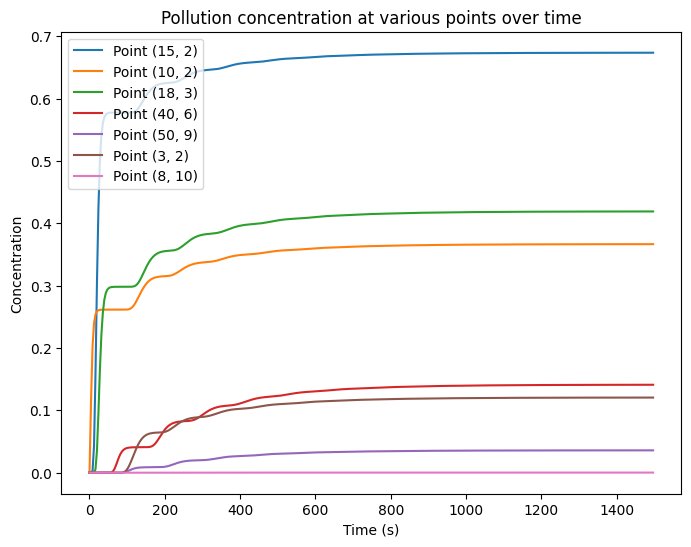

In [ ]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

# Increasing kappa to 0.05

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.5 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 5e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

# Example points to monitor concentration changes
points = [(15, 2),(10,2),(18,3), (40,6),(50,9), (3,2),(8,10)]  # (x, y) coordinates

plt.figure(figsize=(8, 6))
for (px, py) in points:
    i, j = np.argmin(np.abs(x - px)), np.argmin(np.abs(y - py))
    concentration_time_series = [c[i, j] for c in c_save]
    plt.plot(t_save, concentration_time_series, label=f'Point ({px}, {py})')

plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()
plt.title('Pollution concentration at various points over time')
plt.show()

When the diffusion coefficient $\kappa$ was increased, the pollution concentration curves showed smoother transitions and less pronounced peaks. For example, at Point (10, 2), the concentration reached approximately 0.7, which is significantly lower than the peak in the original plot (around 2.6). This behavior indicates that higher diffusion facilitates a more even spread of pollutants across the river, reducing localized accumulation near the source. Moreover, distant points such as (40, 6) and (50, 9) experienced faster pollution arrival due to enhanced diffusion, which accelerated the pollutant's dispersion downstream.


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s


2024-12-27 07:14:50,897 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s


INFO:__main__:Starting main loop


2024-12-27 07:14:50,905 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.906250e-01, dt=3.906250e-01


2024-12-27 07:14:50,951 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e-01, dt=3.906250e-01


INFO:__main__:Iteration=11, Time=4.296875e+00, dt=3.906250e-01


2024-12-27 07:14:50,991 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+00, dt=3.906250e-01


INFO:__main__:Iteration=21, Time=8.203125e+00, dt=3.906250e-01


2024-12-27 07:14:51,025 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+00, dt=3.906250e-01


INFO:__main__:Iteration=31, Time=1.210938e+01, dt=3.906250e-01


2024-12-27 07:14:51,056 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+01, dt=3.906250e-01


INFO:__main__:Iteration=41, Time=1.601562e+01, dt=3.906250e-01


2024-12-27 07:14:51,088 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+01, dt=3.906250e-01


INFO:__main__:Iteration=51, Time=1.992188e+01, dt=3.906250e-01


2024-12-27 07:14:51,121 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+01, dt=3.906250e-01


INFO:__main__:Iteration=61, Time=2.382812e+01, dt=3.906250e-01


2024-12-27 07:14:51,152 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+01, dt=3.906250e-01


INFO:__main__:Iteration=71, Time=2.773438e+01, dt=3.906250e-01


2024-12-27 07:14:51,183 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+01, dt=3.906250e-01


INFO:__main__:Iteration=81, Time=3.164062e+01, dt=3.906250e-01


2024-12-27 07:14:51,215 __main__ 0/1 INFO :: Iteration=81, Time=3.164062e+01, dt=3.906250e-01


INFO:__main__:Iteration=91, Time=3.554688e+01, dt=3.906250e-01


2024-12-27 07:14:51,250 __main__ 0/1 INFO :: Iteration=91, Time=3.554688e+01, dt=3.906250e-01


INFO:__main__:Iteration=101, Time=3.945312e+01, dt=3.906250e-01


2024-12-27 07:14:51,283 __main__ 0/1 INFO :: Iteration=101, Time=3.945312e+01, dt=3.906250e-01


INFO:__main__:Iteration=111, Time=4.335938e+01, dt=3.906250e-01


2024-12-27 07:14:51,316 __main__ 0/1 INFO :: Iteration=111, Time=4.335938e+01, dt=3.906250e-01


INFO:__main__:Iteration=121, Time=4.726562e+01, dt=3.906250e-01


2024-12-27 07:14:51,349 __main__ 0/1 INFO :: Iteration=121, Time=4.726562e+01, dt=3.906250e-01


INFO:__main__:Iteration=131, Time=5.117188e+01, dt=3.906250e-01


2024-12-27 07:14:51,382 __main__ 0/1 INFO :: Iteration=131, Time=5.117188e+01, dt=3.906250e-01


INFO:__main__:Iteration=141, Time=5.507812e+01, dt=3.906250e-01


2024-12-27 07:14:51,418 __main__ 0/1 INFO :: Iteration=141, Time=5.507812e+01, dt=3.906250e-01


INFO:__main__:Iteration=151, Time=5.898438e+01, dt=3.906250e-01


2024-12-27 07:14:51,450 __main__ 0/1 INFO :: Iteration=151, Time=5.898438e+01, dt=3.906250e-01


INFO:__main__:Iteration=161, Time=6.289062e+01, dt=3.906250e-01


2024-12-27 07:14:51,482 __main__ 0/1 INFO :: Iteration=161, Time=6.289062e+01, dt=3.906250e-01


INFO:__main__:Iteration=171, Time=6.679688e+01, dt=3.906250e-01


2024-12-27 07:14:51,517 __main__ 0/1 INFO :: Iteration=171, Time=6.679688e+01, dt=3.906250e-01


INFO:__main__:Iteration=181, Time=7.070312e+01, dt=3.906250e-01


2024-12-27 07:14:51,550 __main__ 0/1 INFO :: Iteration=181, Time=7.070312e+01, dt=3.906250e-01


INFO:__main__:Iteration=191, Time=7.460938e+01, dt=3.906250e-01


2024-12-27 07:14:51,584 __main__ 0/1 INFO :: Iteration=191, Time=7.460938e+01, dt=3.906250e-01


INFO:__main__:Iteration=201, Time=7.851562e+01, dt=3.906250e-01


2024-12-27 07:14:51,622 __main__ 0/1 INFO :: Iteration=201, Time=7.851562e+01, dt=3.906250e-01


INFO:__main__:Iteration=211, Time=8.242188e+01, dt=3.906250e-01


2024-12-27 07:14:51,654 __main__ 0/1 INFO :: Iteration=211, Time=8.242188e+01, dt=3.906250e-01


INFO:__main__:Iteration=221, Time=8.632812e+01, dt=3.906250e-01


2024-12-27 07:14:51,686 __main__ 0/1 INFO :: Iteration=221, Time=8.632812e+01, dt=3.906250e-01


INFO:__main__:Iteration=231, Time=9.023438e+01, dt=3.906250e-01


2024-12-27 07:14:51,719 __main__ 0/1 INFO :: Iteration=231, Time=9.023438e+01, dt=3.906250e-01


INFO:__main__:Iteration=241, Time=9.414062e+01, dt=3.906250e-01


2024-12-27 07:14:51,749 __main__ 0/1 INFO :: Iteration=241, Time=9.414062e+01, dt=3.906250e-01


INFO:__main__:Iteration=251, Time=9.804688e+01, dt=3.906250e-01


2024-12-27 07:14:51,784 __main__ 0/1 INFO :: Iteration=251, Time=9.804688e+01, dt=3.906250e-01


INFO:__main__:Iteration=261, Time=1.019531e+02, dt=3.906250e-01


2024-12-27 07:14:51,823 __main__ 0/1 INFO :: Iteration=261, Time=1.019531e+02, dt=3.906250e-01


INFO:__main__:Iteration=271, Time=1.058594e+02, dt=3.906250e-01


2024-12-27 07:14:51,860 __main__ 0/1 INFO :: Iteration=271, Time=1.058594e+02, dt=3.906250e-01


INFO:__main__:Iteration=281, Time=1.097656e+02, dt=3.906250e-01


2024-12-27 07:14:51,901 __main__ 0/1 INFO :: Iteration=281, Time=1.097656e+02, dt=3.906250e-01


INFO:__main__:Iteration=291, Time=1.136719e+02, dt=3.906250e-01


2024-12-27 07:14:51,940 __main__ 0/1 INFO :: Iteration=291, Time=1.136719e+02, dt=3.906250e-01


INFO:__main__:Iteration=301, Time=1.175781e+02, dt=3.906250e-01


2024-12-27 07:14:51,985 __main__ 0/1 INFO :: Iteration=301, Time=1.175781e+02, dt=3.906250e-01


INFO:__main__:Iteration=311, Time=1.214844e+02, dt=3.906250e-01


2024-12-27 07:14:52,034 __main__ 0/1 INFO :: Iteration=311, Time=1.214844e+02, dt=3.906250e-01


INFO:__main__:Iteration=321, Time=1.253906e+02, dt=3.906250e-01


2024-12-27 07:14:52,082 __main__ 0/1 INFO :: Iteration=321, Time=1.253906e+02, dt=3.906250e-01


INFO:__main__:Iteration=331, Time=1.292969e+02, dt=3.906250e-01


2024-12-27 07:14:52,128 __main__ 0/1 INFO :: Iteration=331, Time=1.292969e+02, dt=3.906250e-01


INFO:__main__:Iteration=341, Time=1.332031e+02, dt=3.906250e-01


2024-12-27 07:14:52,165 __main__ 0/1 INFO :: Iteration=341, Time=1.332031e+02, dt=3.906250e-01


INFO:__main__:Iteration=351, Time=1.371094e+02, dt=3.906250e-01


2024-12-27 07:14:52,205 __main__ 0/1 INFO :: Iteration=351, Time=1.371094e+02, dt=3.906250e-01


INFO:__main__:Iteration=361, Time=1.410156e+02, dt=3.906250e-01


2024-12-27 07:14:52,242 __main__ 0/1 INFO :: Iteration=361, Time=1.410156e+02, dt=3.906250e-01


INFO:__main__:Iteration=371, Time=1.449219e+02, dt=3.906250e-01


2024-12-27 07:14:52,282 __main__ 0/1 INFO :: Iteration=371, Time=1.449219e+02, dt=3.906250e-01


INFO:__main__:Iteration=381, Time=1.488281e+02, dt=3.906250e-01


2024-12-27 07:14:52,320 __main__ 0/1 INFO :: Iteration=381, Time=1.488281e+02, dt=3.906250e-01


INFO:__main__:Iteration=391, Time=1.527344e+02, dt=3.906250e-01


2024-12-27 07:14:52,363 __main__ 0/1 INFO :: Iteration=391, Time=1.527344e+02, dt=3.906250e-01


INFO:__main__:Iteration=401, Time=1.566406e+02, dt=3.906250e-01


2024-12-27 07:14:52,408 __main__ 0/1 INFO :: Iteration=401, Time=1.566406e+02, dt=3.906250e-01


INFO:__main__:Iteration=411, Time=1.605469e+02, dt=3.906250e-01


2024-12-27 07:14:52,449 __main__ 0/1 INFO :: Iteration=411, Time=1.605469e+02, dt=3.906250e-01


INFO:__main__:Iteration=421, Time=1.644531e+02, dt=3.906250e-01


2024-12-27 07:14:52,483 __main__ 0/1 INFO :: Iteration=421, Time=1.644531e+02, dt=3.906250e-01


INFO:__main__:Iteration=431, Time=1.683594e+02, dt=3.906250e-01


2024-12-27 07:14:52,518 __main__ 0/1 INFO :: Iteration=431, Time=1.683594e+02, dt=3.906250e-01


INFO:__main__:Iteration=441, Time=1.722656e+02, dt=3.906250e-01


2024-12-27 07:14:52,548 __main__ 0/1 INFO :: Iteration=441, Time=1.722656e+02, dt=3.906250e-01


INFO:__main__:Iteration=451, Time=1.761719e+02, dt=3.906250e-01


2024-12-27 07:14:52,580 __main__ 0/1 INFO :: Iteration=451, Time=1.761719e+02, dt=3.906250e-01


INFO:__main__:Iteration=461, Time=1.800781e+02, dt=3.906250e-01


2024-12-27 07:14:52,612 __main__ 0/1 INFO :: Iteration=461, Time=1.800781e+02, dt=3.906250e-01


INFO:__main__:Iteration=471, Time=1.839844e+02, dt=3.906250e-01


2024-12-27 07:14:52,647 __main__ 0/1 INFO :: Iteration=471, Time=1.839844e+02, dt=3.906250e-01


INFO:__main__:Iteration=481, Time=1.878906e+02, dt=3.906250e-01


2024-12-27 07:14:52,679 __main__ 0/1 INFO :: Iteration=481, Time=1.878906e+02, dt=3.906250e-01


INFO:__main__:Iteration=491, Time=1.917969e+02, dt=3.906250e-01


2024-12-27 07:14:52,710 __main__ 0/1 INFO :: Iteration=491, Time=1.917969e+02, dt=3.906250e-01


INFO:__main__:Iteration=501, Time=1.957031e+02, dt=3.906250e-01


2024-12-27 07:14:52,744 __main__ 0/1 INFO :: Iteration=501, Time=1.957031e+02, dt=3.906250e-01


INFO:__main__:Iteration=511, Time=1.996094e+02, dt=3.906250e-01


2024-12-27 07:14:52,778 __main__ 0/1 INFO :: Iteration=511, Time=1.996094e+02, dt=3.906250e-01


INFO:__main__:Iteration=521, Time=2.035156e+02, dt=3.906250e-01


2024-12-27 07:14:52,822 __main__ 0/1 INFO :: Iteration=521, Time=2.035156e+02, dt=3.906250e-01


INFO:__main__:Iteration=531, Time=2.074219e+02, dt=3.906250e-01


2024-12-27 07:14:52,863 __main__ 0/1 INFO :: Iteration=531, Time=2.074219e+02, dt=3.906250e-01


INFO:__main__:Iteration=541, Time=2.113281e+02, dt=3.906250e-01


2024-12-27 07:14:52,906 __main__ 0/1 INFO :: Iteration=541, Time=2.113281e+02, dt=3.906250e-01


INFO:__main__:Iteration=551, Time=2.152344e+02, dt=3.906250e-01


2024-12-27 07:14:52,949 __main__ 0/1 INFO :: Iteration=551, Time=2.152344e+02, dt=3.906250e-01


INFO:__main__:Iteration=561, Time=2.191406e+02, dt=3.906250e-01


2024-12-27 07:14:52,988 __main__ 0/1 INFO :: Iteration=561, Time=2.191406e+02, dt=3.906250e-01


INFO:__main__:Iteration=571, Time=2.230469e+02, dt=3.906250e-01


2024-12-27 07:14:53,020 __main__ 0/1 INFO :: Iteration=571, Time=2.230469e+02, dt=3.906250e-01


INFO:__main__:Iteration=581, Time=2.269531e+02, dt=3.906250e-01


2024-12-27 07:14:53,060 __main__ 0/1 INFO :: Iteration=581, Time=2.269531e+02, dt=3.906250e-01


INFO:__main__:Iteration=591, Time=2.308594e+02, dt=3.906250e-01


2024-12-27 07:14:53,106 __main__ 0/1 INFO :: Iteration=591, Time=2.308594e+02, dt=3.906250e-01


INFO:__main__:Iteration=601, Time=2.347656e+02, dt=3.906250e-01


2024-12-27 07:14:53,141 __main__ 0/1 INFO :: Iteration=601, Time=2.347656e+02, dt=3.906250e-01


INFO:__main__:Iteration=611, Time=2.386719e+02, dt=3.906250e-01


2024-12-27 07:14:53,171 __main__ 0/1 INFO :: Iteration=611, Time=2.386719e+02, dt=3.906250e-01


INFO:__main__:Iteration=621, Time=2.425781e+02, dt=3.906250e-01


2024-12-27 07:14:53,207 __main__ 0/1 INFO :: Iteration=621, Time=2.425781e+02, dt=3.906250e-01


INFO:__main__:Iteration=631, Time=2.464844e+02, dt=3.906250e-01


2024-12-27 07:14:53,239 __main__ 0/1 INFO :: Iteration=631, Time=2.464844e+02, dt=3.906250e-01


INFO:__main__:Iteration=641, Time=2.503906e+02, dt=3.906250e-01


2024-12-27 07:14:53,272 __main__ 0/1 INFO :: Iteration=641, Time=2.503906e+02, dt=3.906250e-01


INFO:__main__:Iteration=651, Time=2.542969e+02, dt=3.906250e-01


2024-12-27 07:14:53,305 __main__ 0/1 INFO :: Iteration=651, Time=2.542969e+02, dt=3.906250e-01


INFO:__main__:Iteration=661, Time=2.582031e+02, dt=3.906250e-01


2024-12-27 07:14:53,338 __main__ 0/1 INFO :: Iteration=661, Time=2.582031e+02, dt=3.906250e-01


INFO:__main__:Iteration=671, Time=2.621094e+02, dt=3.906250e-01


2024-12-27 07:14:53,369 __main__ 0/1 INFO :: Iteration=671, Time=2.621094e+02, dt=3.906250e-01


INFO:__main__:Iteration=681, Time=2.660156e+02, dt=3.906250e-01


2024-12-27 07:14:53,399 __main__ 0/1 INFO :: Iteration=681, Time=2.660156e+02, dt=3.906250e-01


INFO:__main__:Iteration=691, Time=2.699219e+02, dt=3.906250e-01


2024-12-27 07:14:53,431 __main__ 0/1 INFO :: Iteration=691, Time=2.699219e+02, dt=3.906250e-01


INFO:__main__:Iteration=701, Time=2.738281e+02, dt=3.906250e-01


2024-12-27 07:14:53,467 __main__ 0/1 INFO :: Iteration=701, Time=2.738281e+02, dt=3.906250e-01


INFO:__main__:Iteration=711, Time=2.777344e+02, dt=3.906250e-01


2024-12-27 07:14:53,500 __main__ 0/1 INFO :: Iteration=711, Time=2.777344e+02, dt=3.906250e-01


INFO:__main__:Iteration=721, Time=2.816406e+02, dt=3.906250e-01


2024-12-27 07:14:53,536 __main__ 0/1 INFO :: Iteration=721, Time=2.816406e+02, dt=3.906250e-01


INFO:__main__:Iteration=731, Time=2.855469e+02, dt=3.906250e-01


2024-12-27 07:14:53,579 __main__ 0/1 INFO :: Iteration=731, Time=2.855469e+02, dt=3.906250e-01


INFO:__main__:Iteration=741, Time=2.894531e+02, dt=3.906250e-01


2024-12-27 07:14:53,610 __main__ 0/1 INFO :: Iteration=741, Time=2.894531e+02, dt=3.906250e-01


INFO:__main__:Iteration=751, Time=2.933594e+02, dt=3.906250e-01


2024-12-27 07:14:53,646 __main__ 0/1 INFO :: Iteration=751, Time=2.933594e+02, dt=3.906250e-01


INFO:__main__:Iteration=761, Time=2.972656e+02, dt=3.906250e-01


2024-12-27 07:14:53,680 __main__ 0/1 INFO :: Iteration=761, Time=2.972656e+02, dt=3.906250e-01


INFO:__main__:Iteration=771, Time=3.011719e+02, dt=3.906250e-01


2024-12-27 07:14:53,712 __main__ 0/1 INFO :: Iteration=771, Time=3.011719e+02, dt=3.906250e-01


INFO:__main__:Iteration=781, Time=3.050781e+02, dt=3.906250e-01


2024-12-27 07:14:53,746 __main__ 0/1 INFO :: Iteration=781, Time=3.050781e+02, dt=3.906250e-01


INFO:__main__:Iteration=791, Time=3.089844e+02, dt=3.906250e-01


2024-12-27 07:14:53,779 __main__ 0/1 INFO :: Iteration=791, Time=3.089844e+02, dt=3.906250e-01


INFO:__main__:Iteration=801, Time=3.128906e+02, dt=3.906250e-01


2024-12-27 07:14:53,825 __main__ 0/1 INFO :: Iteration=801, Time=3.128906e+02, dt=3.906250e-01


INFO:__main__:Iteration=811, Time=3.167969e+02, dt=3.906250e-01


2024-12-27 07:14:53,866 __main__ 0/1 INFO :: Iteration=811, Time=3.167969e+02, dt=3.906250e-01


INFO:__main__:Iteration=821, Time=3.207031e+02, dt=3.906250e-01


2024-12-27 07:14:53,918 __main__ 0/1 INFO :: Iteration=821, Time=3.207031e+02, dt=3.906250e-01


INFO:__main__:Iteration=831, Time=3.246094e+02, dt=3.906250e-01


2024-12-27 07:14:53,962 __main__ 0/1 INFO :: Iteration=831, Time=3.246094e+02, dt=3.906250e-01


INFO:__main__:Iteration=841, Time=3.285156e+02, dt=3.906250e-01


2024-12-27 07:14:54,003 __main__ 0/1 INFO :: Iteration=841, Time=3.285156e+02, dt=3.906250e-01


INFO:__main__:Iteration=851, Time=3.324219e+02, dt=3.906250e-01


2024-12-27 07:14:54,045 __main__ 0/1 INFO :: Iteration=851, Time=3.324219e+02, dt=3.906250e-01


INFO:__main__:Iteration=861, Time=3.363281e+02, dt=3.906250e-01


2024-12-27 07:14:54,091 __main__ 0/1 INFO :: Iteration=861, Time=3.363281e+02, dt=3.906250e-01


INFO:__main__:Iteration=871, Time=3.402344e+02, dt=3.906250e-01


2024-12-27 07:14:54,147 __main__ 0/1 INFO :: Iteration=871, Time=3.402344e+02, dt=3.906250e-01


INFO:__main__:Iteration=881, Time=3.441406e+02, dt=3.906250e-01


2024-12-27 07:14:54,197 __main__ 0/1 INFO :: Iteration=881, Time=3.441406e+02, dt=3.906250e-01


INFO:__main__:Iteration=891, Time=3.480469e+02, dt=3.906250e-01


2024-12-27 07:14:54,240 __main__ 0/1 INFO :: Iteration=891, Time=3.480469e+02, dt=3.906250e-01


INFO:__main__:Iteration=901, Time=3.519531e+02, dt=3.906250e-01


2024-12-27 07:14:54,275 __main__ 0/1 INFO :: Iteration=901, Time=3.519531e+02, dt=3.906250e-01


INFO:__main__:Iteration=911, Time=3.558594e+02, dt=3.906250e-01


2024-12-27 07:14:54,316 __main__ 0/1 INFO :: Iteration=911, Time=3.558594e+02, dt=3.906250e-01


INFO:__main__:Iteration=921, Time=3.597656e+02, dt=3.906250e-01


2024-12-27 07:14:54,348 __main__ 0/1 INFO :: Iteration=921, Time=3.597656e+02, dt=3.906250e-01


INFO:__main__:Iteration=931, Time=3.636719e+02, dt=3.906250e-01


2024-12-27 07:14:54,379 __main__ 0/1 INFO :: Iteration=931, Time=3.636719e+02, dt=3.906250e-01


INFO:__main__:Iteration=941, Time=3.675781e+02, dt=3.906250e-01


2024-12-27 07:14:54,411 __main__ 0/1 INFO :: Iteration=941, Time=3.675781e+02, dt=3.906250e-01


INFO:__main__:Iteration=951, Time=3.714844e+02, dt=3.906250e-01


2024-12-27 07:14:54,447 __main__ 0/1 INFO :: Iteration=951, Time=3.714844e+02, dt=3.906250e-01


INFO:__main__:Iteration=961, Time=3.753906e+02, dt=3.906250e-01


2024-12-27 07:14:54,481 __main__ 0/1 INFO :: Iteration=961, Time=3.753906e+02, dt=3.906250e-01


INFO:__main__:Iteration=971, Time=3.792969e+02, dt=3.906250e-01


2024-12-27 07:14:54,516 __main__ 0/1 INFO :: Iteration=971, Time=3.792969e+02, dt=3.906250e-01


INFO:__main__:Iteration=981, Time=3.832031e+02, dt=3.906250e-01


2024-12-27 07:14:54,549 __main__ 0/1 INFO :: Iteration=981, Time=3.832031e+02, dt=3.906250e-01


INFO:__main__:Iteration=991, Time=3.871094e+02, dt=3.906250e-01


2024-12-27 07:14:54,581 __main__ 0/1 INFO :: Iteration=991, Time=3.871094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1001, Time=3.910156e+02, dt=3.906250e-01


2024-12-27 07:14:54,616 __main__ 0/1 INFO :: Iteration=1001, Time=3.910156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1011, Time=3.949219e+02, dt=3.906250e-01


2024-12-27 07:14:54,647 __main__ 0/1 INFO :: Iteration=1011, Time=3.949219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1021, Time=3.988281e+02, dt=3.906250e-01


2024-12-27 07:14:54,679 __main__ 0/1 INFO :: Iteration=1021, Time=3.988281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1031, Time=4.027344e+02, dt=3.906250e-01


2024-12-27 07:14:54,717 __main__ 0/1 INFO :: Iteration=1031, Time=4.027344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1041, Time=4.066406e+02, dt=3.906250e-01


2024-12-27 07:14:54,755 __main__ 0/1 INFO :: Iteration=1041, Time=4.066406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1051, Time=4.105469e+02, dt=3.906250e-01


2024-12-27 07:14:54,795 __main__ 0/1 INFO :: Iteration=1051, Time=4.105469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1061, Time=4.144531e+02, dt=3.906250e-01


2024-12-27 07:14:54,836 __main__ 0/1 INFO :: Iteration=1061, Time=4.144531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1071, Time=4.183594e+02, dt=3.906250e-01


2024-12-27 07:14:54,874 __main__ 0/1 INFO :: Iteration=1071, Time=4.183594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1081, Time=4.222656e+02, dt=3.906250e-01


2024-12-27 07:14:54,915 __main__ 0/1 INFO :: Iteration=1081, Time=4.222656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1091, Time=4.261719e+02, dt=3.906250e-01


2024-12-27 07:14:54,960 __main__ 0/1 INFO :: Iteration=1091, Time=4.261719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1101, Time=4.300781e+02, dt=3.906250e-01


2024-12-27 07:14:55,003 __main__ 0/1 INFO :: Iteration=1101, Time=4.300781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1111, Time=4.339844e+02, dt=3.906250e-01


2024-12-27 07:14:55,045 __main__ 0/1 INFO :: Iteration=1111, Time=4.339844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1121, Time=4.378906e+02, dt=3.906250e-01


2024-12-27 07:14:55,078 __main__ 0/1 INFO :: Iteration=1121, Time=4.378906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1131, Time=4.417969e+02, dt=3.906250e-01


2024-12-27 07:14:55,113 __main__ 0/1 INFO :: Iteration=1131, Time=4.417969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1141, Time=4.457031e+02, dt=3.906250e-01


2024-12-27 07:14:55,152 __main__ 0/1 INFO :: Iteration=1141, Time=4.457031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1151, Time=4.496094e+02, dt=3.906250e-01


2024-12-27 07:14:55,188 __main__ 0/1 INFO :: Iteration=1151, Time=4.496094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1161, Time=4.535156e+02, dt=3.906250e-01


2024-12-27 07:14:55,221 __main__ 0/1 INFO :: Iteration=1161, Time=4.535156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1171, Time=4.574219e+02, dt=3.906250e-01


2024-12-27 07:14:55,253 __main__ 0/1 INFO :: Iteration=1171, Time=4.574219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1181, Time=4.613281e+02, dt=3.906250e-01


2024-12-27 07:14:55,285 __main__ 0/1 INFO :: Iteration=1181, Time=4.613281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1191, Time=4.652344e+02, dt=3.906250e-01


2024-12-27 07:14:55,317 __main__ 0/1 INFO :: Iteration=1191, Time=4.652344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1201, Time=4.691406e+02, dt=3.906250e-01


2024-12-27 07:14:55,351 __main__ 0/1 INFO :: Iteration=1201, Time=4.691406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1211, Time=4.730469e+02, dt=3.906250e-01


2024-12-27 07:14:55,384 __main__ 0/1 INFO :: Iteration=1211, Time=4.730469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1221, Time=4.769531e+02, dt=3.906250e-01


2024-12-27 07:14:55,416 __main__ 0/1 INFO :: Iteration=1221, Time=4.769531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1231, Time=4.808594e+02, dt=3.906250e-01


2024-12-27 07:14:55,450 __main__ 0/1 INFO :: Iteration=1231, Time=4.808594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1241, Time=4.847656e+02, dt=3.906250e-01


2024-12-27 07:14:55,485 __main__ 0/1 INFO :: Iteration=1241, Time=4.847656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1251, Time=4.886719e+02, dt=3.906250e-01


2024-12-27 07:14:55,524 __main__ 0/1 INFO :: Iteration=1251, Time=4.886719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1261, Time=4.925781e+02, dt=3.906250e-01


2024-12-27 07:14:55,557 __main__ 0/1 INFO :: Iteration=1261, Time=4.925781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1271, Time=4.964844e+02, dt=3.906250e-01


2024-12-27 07:14:55,587 __main__ 0/1 INFO :: Iteration=1271, Time=4.964844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1281, Time=5.003906e+02, dt=3.906250e-01


2024-12-27 07:14:55,619 __main__ 0/1 INFO :: Iteration=1281, Time=5.003906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1291, Time=5.042969e+02, dt=3.906250e-01


2024-12-27 07:14:55,655 __main__ 0/1 INFO :: Iteration=1291, Time=5.042969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1301, Time=5.082031e+02, dt=3.906250e-01


2024-12-27 07:14:55,689 __main__ 0/1 INFO :: Iteration=1301, Time=5.082031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1311, Time=5.121094e+02, dt=3.906250e-01


2024-12-27 07:14:55,721 __main__ 0/1 INFO :: Iteration=1311, Time=5.121094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1321, Time=5.160156e+02, dt=3.906250e-01


2024-12-27 07:14:55,756 __main__ 0/1 INFO :: Iteration=1321, Time=5.160156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1331, Time=5.199219e+02, dt=3.906250e-01


2024-12-27 07:14:55,798 __main__ 0/1 INFO :: Iteration=1331, Time=5.199219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1341, Time=5.238281e+02, dt=3.906250e-01


2024-12-27 07:14:55,841 __main__ 0/1 INFO :: Iteration=1341, Time=5.238281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1351, Time=5.277344e+02, dt=3.906250e-01


2024-12-27 07:14:55,886 __main__ 0/1 INFO :: Iteration=1351, Time=5.277344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1361, Time=5.316406e+02, dt=3.906250e-01


2024-12-27 07:14:55,933 __main__ 0/1 INFO :: Iteration=1361, Time=5.316406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1371, Time=5.355469e+02, dt=3.906250e-01


2024-12-27 07:14:55,973 __main__ 0/1 INFO :: Iteration=1371, Time=5.355469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1381, Time=5.394531e+02, dt=3.906250e-01


2024-12-27 07:14:56,016 __main__ 0/1 INFO :: Iteration=1381, Time=5.394531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1391, Time=5.433594e+02, dt=3.906250e-01


2024-12-27 07:14:56,055 __main__ 0/1 INFO :: Iteration=1391, Time=5.433594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1401, Time=5.472656e+02, dt=3.906250e-01


2024-12-27 07:14:56,105 __main__ 0/1 INFO :: Iteration=1401, Time=5.472656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1411, Time=5.511719e+02, dt=3.906250e-01


2024-12-27 07:14:56,148 __main__ 0/1 INFO :: Iteration=1411, Time=5.511719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1421, Time=5.550781e+02, dt=3.906250e-01


2024-12-27 07:14:56,201 __main__ 0/1 INFO :: Iteration=1421, Time=5.550781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1431, Time=5.589844e+02, dt=3.906250e-01


2024-12-27 07:14:56,240 __main__ 0/1 INFO :: Iteration=1431, Time=5.589844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1441, Time=5.628906e+02, dt=3.906250e-01


2024-12-27 07:14:56,272 __main__ 0/1 INFO :: Iteration=1441, Time=5.628906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1451, Time=5.667969e+02, dt=3.906250e-01


2024-12-27 07:14:56,305 __main__ 0/1 INFO :: Iteration=1451, Time=5.667969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1461, Time=5.707031e+02, dt=3.906250e-01


2024-12-27 07:14:56,340 __main__ 0/1 INFO :: Iteration=1461, Time=5.707031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1471, Time=5.746094e+02, dt=3.906250e-01


2024-12-27 07:14:56,372 __main__ 0/1 INFO :: Iteration=1471, Time=5.746094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1481, Time=5.785156e+02, dt=3.906250e-01


2024-12-27 07:14:56,403 __main__ 0/1 INFO :: Iteration=1481, Time=5.785156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1491, Time=5.824219e+02, dt=3.906250e-01


2024-12-27 07:14:56,436 __main__ 0/1 INFO :: Iteration=1491, Time=5.824219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1501, Time=5.863281e+02, dt=3.906250e-01


2024-12-27 07:14:56,473 __main__ 0/1 INFO :: Iteration=1501, Time=5.863281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1511, Time=5.902344e+02, dt=3.906250e-01


2024-12-27 07:14:56,505 __main__ 0/1 INFO :: Iteration=1511, Time=5.902344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1521, Time=5.941406e+02, dt=3.906250e-01


2024-12-27 07:14:56,541 __main__ 0/1 INFO :: Iteration=1521, Time=5.941406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1531, Time=5.980469e+02, dt=3.906250e-01


2024-12-27 07:14:56,575 __main__ 0/1 INFO :: Iteration=1531, Time=5.980469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1541, Time=6.019531e+02, dt=3.906250e-01


2024-12-27 07:14:56,607 __main__ 0/1 INFO :: Iteration=1541, Time=6.019531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1551, Time=6.058594e+02, dt=3.906250e-01


2024-12-27 07:14:56,641 __main__ 0/1 INFO :: Iteration=1551, Time=6.058594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1561, Time=6.097656e+02, dt=3.906250e-01


2024-12-27 07:14:56,675 __main__ 0/1 INFO :: Iteration=1561, Time=6.097656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1571, Time=6.136719e+02, dt=3.906250e-01


2024-12-27 07:14:56,711 __main__ 0/1 INFO :: Iteration=1571, Time=6.136719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1581, Time=6.175781e+02, dt=3.906250e-01


2024-12-27 07:14:56,743 __main__ 0/1 INFO :: Iteration=1581, Time=6.175781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1591, Time=6.214844e+02, dt=3.906250e-01


2024-12-27 07:14:56,781 __main__ 0/1 INFO :: Iteration=1591, Time=6.214844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1601, Time=6.253906e+02, dt=3.906250e-01


2024-12-27 07:14:56,825 __main__ 0/1 INFO :: Iteration=1601, Time=6.253906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1611, Time=6.292969e+02, dt=3.906250e-01


2024-12-27 07:14:56,865 __main__ 0/1 INFO :: Iteration=1611, Time=6.292969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1621, Time=6.332031e+02, dt=3.906250e-01


2024-12-27 07:14:56,908 __main__ 0/1 INFO :: Iteration=1621, Time=6.332031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1631, Time=6.371094e+02, dt=3.906250e-01


2024-12-27 07:14:56,949 __main__ 0/1 INFO :: Iteration=1631, Time=6.371094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1641, Time=6.410156e+02, dt=3.906250e-01


2024-12-27 07:14:56,989 __main__ 0/1 INFO :: Iteration=1641, Time=6.410156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1651, Time=6.449219e+02, dt=3.906250e-01


2024-12-27 07:14:57,035 __main__ 0/1 INFO :: Iteration=1651, Time=6.449219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1661, Time=6.488281e+02, dt=3.906250e-01


2024-12-27 07:14:57,082 __main__ 0/1 INFO :: Iteration=1661, Time=6.488281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1671, Time=6.527344e+02, dt=3.906250e-01


2024-12-27 07:14:57,117 __main__ 0/1 INFO :: Iteration=1671, Time=6.527344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1681, Time=6.566406e+02, dt=3.906250e-01


2024-12-27 07:14:57,149 __main__ 0/1 INFO :: Iteration=1681, Time=6.566406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1691, Time=6.605469e+02, dt=3.906250e-01


2024-12-27 07:14:57,182 __main__ 0/1 INFO :: Iteration=1691, Time=6.605469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1701, Time=6.644531e+02, dt=3.906250e-01


2024-12-27 07:14:57,227 __main__ 0/1 INFO :: Iteration=1701, Time=6.644531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1711, Time=6.683594e+02, dt=3.906250e-01


2024-12-27 07:14:57,264 __main__ 0/1 INFO :: Iteration=1711, Time=6.683594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1721, Time=6.722656e+02, dt=3.906250e-01


2024-12-27 07:14:57,301 __main__ 0/1 INFO :: Iteration=1721, Time=6.722656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1731, Time=6.761719e+02, dt=3.906250e-01


2024-12-27 07:14:57,334 __main__ 0/1 INFO :: Iteration=1731, Time=6.761719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1741, Time=6.800781e+02, dt=3.906250e-01


2024-12-27 07:14:57,369 __main__ 0/1 INFO :: Iteration=1741, Time=6.800781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1751, Time=6.839844e+02, dt=3.906250e-01


2024-12-27 07:14:57,402 __main__ 0/1 INFO :: Iteration=1751, Time=6.839844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1761, Time=6.878906e+02, dt=3.906250e-01


2024-12-27 07:14:57,438 __main__ 0/1 INFO :: Iteration=1761, Time=6.878906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1771, Time=6.917969e+02, dt=3.906250e-01


2024-12-27 07:14:57,471 __main__ 0/1 INFO :: Iteration=1771, Time=6.917969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1781, Time=6.957031e+02, dt=3.906250e-01


2024-12-27 07:14:57,518 __main__ 0/1 INFO :: Iteration=1781, Time=6.957031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1791, Time=6.996094e+02, dt=3.906250e-01


2024-12-27 07:14:57,571 __main__ 0/1 INFO :: Iteration=1791, Time=6.996094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1801, Time=7.035156e+02, dt=3.906250e-01


2024-12-27 07:14:57,620 __main__ 0/1 INFO :: Iteration=1801, Time=7.035156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1811, Time=7.074219e+02, dt=3.906250e-01


2024-12-27 07:14:57,662 __main__ 0/1 INFO :: Iteration=1811, Time=7.074219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1821, Time=7.113281e+02, dt=3.906250e-01


2024-12-27 07:14:57,703 __main__ 0/1 INFO :: Iteration=1821, Time=7.113281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1831, Time=7.152344e+02, dt=3.906250e-01


2024-12-27 07:14:57,744 __main__ 0/1 INFO :: Iteration=1831, Time=7.152344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1841, Time=7.191406e+02, dt=3.906250e-01


2024-12-27 07:14:57,794 __main__ 0/1 INFO :: Iteration=1841, Time=7.191406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1851, Time=7.230469e+02, dt=3.906250e-01


2024-12-27 07:14:57,837 __main__ 0/1 INFO :: Iteration=1851, Time=7.230469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1861, Time=7.269531e+02, dt=3.906250e-01


2024-12-27 07:14:57,891 __main__ 0/1 INFO :: Iteration=1861, Time=7.269531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1871, Time=7.308594e+02, dt=3.906250e-01


2024-12-27 07:14:57,938 __main__ 0/1 INFO :: Iteration=1871, Time=7.308594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1881, Time=7.347656e+02, dt=3.906250e-01


2024-12-27 07:14:58,000 __main__ 0/1 INFO :: Iteration=1881, Time=7.347656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1891, Time=7.386719e+02, dt=3.906250e-01


2024-12-27 07:14:58,054 __main__ 0/1 INFO :: Iteration=1891, Time=7.386719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1901, Time=7.425781e+02, dt=3.906250e-01


2024-12-27 07:14:58,114 __main__ 0/1 INFO :: Iteration=1901, Time=7.425781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1911, Time=7.464844e+02, dt=3.906250e-01


2024-12-27 07:14:58,164 __main__ 0/1 INFO :: Iteration=1911, Time=7.464844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1921, Time=7.503906e+02, dt=3.906250e-01


2024-12-27 07:14:58,231 __main__ 0/1 INFO :: Iteration=1921, Time=7.503906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1931, Time=7.542969e+02, dt=3.906250e-01


2024-12-27 07:14:58,285 __main__ 0/1 INFO :: Iteration=1931, Time=7.542969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1941, Time=7.582031e+02, dt=3.906250e-01


2024-12-27 07:14:58,336 __main__ 0/1 INFO :: Iteration=1941, Time=7.582031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1951, Time=7.621094e+02, dt=3.906250e-01


2024-12-27 07:14:58,377 __main__ 0/1 INFO :: Iteration=1951, Time=7.621094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1961, Time=7.660156e+02, dt=3.906250e-01


2024-12-27 07:14:58,419 __main__ 0/1 INFO :: Iteration=1961, Time=7.660156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1971, Time=7.699219e+02, dt=3.906250e-01


2024-12-27 07:14:58,461 __main__ 0/1 INFO :: Iteration=1971, Time=7.699219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1981, Time=7.738281e+02, dt=3.906250e-01


2024-12-27 07:14:58,506 __main__ 0/1 INFO :: Iteration=1981, Time=7.738281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1991, Time=7.777344e+02, dt=3.906250e-01


2024-12-27 07:14:58,551 __main__ 0/1 INFO :: Iteration=1991, Time=7.777344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2001, Time=7.816406e+02, dt=3.906250e-01


2024-12-27 07:14:58,594 __main__ 0/1 INFO :: Iteration=2001, Time=7.816406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2011, Time=7.855469e+02, dt=3.906250e-01


2024-12-27 07:14:58,636 __main__ 0/1 INFO :: Iteration=2011, Time=7.855469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2021, Time=7.894531e+02, dt=3.906250e-01


2024-12-27 07:14:58,678 __main__ 0/1 INFO :: Iteration=2021, Time=7.894531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2031, Time=7.933594e+02, dt=3.906250e-01


2024-12-27 07:14:58,719 __main__ 0/1 INFO :: Iteration=2031, Time=7.933594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2041, Time=7.972656e+02, dt=3.906250e-01


2024-12-27 07:14:58,762 __main__ 0/1 INFO :: Iteration=2041, Time=7.972656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2051, Time=8.011719e+02, dt=3.906250e-01


2024-12-27 07:14:58,819 __main__ 0/1 INFO :: Iteration=2051, Time=8.011719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2061, Time=8.050781e+02, dt=3.906250e-01


2024-12-27 07:14:58,864 __main__ 0/1 INFO :: Iteration=2061, Time=8.050781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2071, Time=8.089844e+02, dt=3.906250e-01


2024-12-27 07:14:58,910 __main__ 0/1 INFO :: Iteration=2071, Time=8.089844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2081, Time=8.128906e+02, dt=3.906250e-01


2024-12-27 07:14:58,958 __main__ 0/1 INFO :: Iteration=2081, Time=8.128906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2091, Time=8.167969e+02, dt=3.906250e-01


2024-12-27 07:14:59,004 __main__ 0/1 INFO :: Iteration=2091, Time=8.167969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2101, Time=8.207031e+02, dt=3.906250e-01


2024-12-27 07:14:59,047 __main__ 0/1 INFO :: Iteration=2101, Time=8.207031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2111, Time=8.246094e+02, dt=3.906250e-01


2024-12-27 07:14:59,091 __main__ 0/1 INFO :: Iteration=2111, Time=8.246094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2121, Time=8.285156e+02, dt=3.906250e-01


2024-12-27 07:14:59,135 __main__ 0/1 INFO :: Iteration=2121, Time=8.285156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2131, Time=8.324219e+02, dt=3.906250e-01


2024-12-27 07:14:59,177 __main__ 0/1 INFO :: Iteration=2131, Time=8.324219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2141, Time=8.363281e+02, dt=3.906250e-01


2024-12-27 07:14:59,219 __main__ 0/1 INFO :: Iteration=2141, Time=8.363281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2151, Time=8.402344e+02, dt=3.906250e-01


2024-12-27 07:14:59,259 __main__ 0/1 INFO :: Iteration=2151, Time=8.402344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2161, Time=8.441406e+02, dt=3.906250e-01


2024-12-27 07:14:59,303 __main__ 0/1 INFO :: Iteration=2161, Time=8.441406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2171, Time=8.480469e+02, dt=3.906250e-01


2024-12-27 07:14:59,343 __main__ 0/1 INFO :: Iteration=2171, Time=8.480469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2181, Time=8.519531e+02, dt=3.906250e-01


2024-12-27 07:14:59,394 __main__ 0/1 INFO :: Iteration=2181, Time=8.519531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2191, Time=8.558594e+02, dt=3.906250e-01


2024-12-27 07:14:59,443 __main__ 0/1 INFO :: Iteration=2191, Time=8.558594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2201, Time=8.597656e+02, dt=3.906250e-01


2024-12-27 07:14:59,493 __main__ 0/1 INFO :: Iteration=2201, Time=8.597656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2211, Time=8.636719e+02, dt=3.906250e-01


2024-12-27 07:14:59,551 __main__ 0/1 INFO :: Iteration=2211, Time=8.636719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2221, Time=8.675781e+02, dt=3.906250e-01


2024-12-27 07:14:59,607 __main__ 0/1 INFO :: Iteration=2221, Time=8.675781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2231, Time=8.714844e+02, dt=3.906250e-01


2024-12-27 07:14:59,655 __main__ 0/1 INFO :: Iteration=2231, Time=8.714844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2241, Time=8.753906e+02, dt=3.906250e-01


2024-12-27 07:14:59,705 __main__ 0/1 INFO :: Iteration=2241, Time=8.753906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2251, Time=8.792969e+02, dt=3.906250e-01


2024-12-27 07:14:59,754 __main__ 0/1 INFO :: Iteration=2251, Time=8.792969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2261, Time=8.832031e+02, dt=3.906250e-01


2024-12-27 07:14:59,815 __main__ 0/1 INFO :: Iteration=2261, Time=8.832031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2271, Time=8.871094e+02, dt=3.906250e-01


2024-12-27 07:14:59,864 __main__ 0/1 INFO :: Iteration=2271, Time=8.871094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2281, Time=8.910156e+02, dt=3.906250e-01


2024-12-27 07:14:59,909 __main__ 0/1 INFO :: Iteration=2281, Time=8.910156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2291, Time=8.949219e+02, dt=3.906250e-01


2024-12-27 07:14:59,958 __main__ 0/1 INFO :: Iteration=2291, Time=8.949219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2301, Time=8.988281e+02, dt=3.906250e-01


2024-12-27 07:15:00,003 __main__ 0/1 INFO :: Iteration=2301, Time=8.988281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2311, Time=9.027344e+02, dt=3.906250e-01


2024-12-27 07:15:00,042 __main__ 0/1 INFO :: Iteration=2311, Time=9.027344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2321, Time=9.066406e+02, dt=3.906250e-01


2024-12-27 07:15:00,084 __main__ 0/1 INFO :: Iteration=2321, Time=9.066406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2331, Time=9.105469e+02, dt=3.906250e-01


2024-12-27 07:15:00,123 __main__ 0/1 INFO :: Iteration=2331, Time=9.105469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2341, Time=9.144531e+02, dt=3.906250e-01


2024-12-27 07:15:00,164 __main__ 0/1 INFO :: Iteration=2341, Time=9.144531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2351, Time=9.183594e+02, dt=3.906250e-01


2024-12-27 07:15:00,205 __main__ 0/1 INFO :: Iteration=2351, Time=9.183594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2361, Time=9.222656e+02, dt=3.906250e-01


2024-12-27 07:15:00,246 __main__ 0/1 INFO :: Iteration=2361, Time=9.222656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2371, Time=9.261719e+02, dt=3.906250e-01


2024-12-27 07:15:00,286 __main__ 0/1 INFO :: Iteration=2371, Time=9.261719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2381, Time=9.300781e+02, dt=3.906250e-01


2024-12-27 07:15:00,329 __main__ 0/1 INFO :: Iteration=2381, Time=9.300781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2391, Time=9.339844e+02, dt=3.906250e-01


2024-12-27 07:15:00,369 __main__ 0/1 INFO :: Iteration=2391, Time=9.339844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2401, Time=9.378906e+02, dt=3.906250e-01


2024-12-27 07:15:00,419 __main__ 0/1 INFO :: Iteration=2401, Time=9.378906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2411, Time=9.417969e+02, dt=3.906250e-01


2024-12-27 07:15:00,478 __main__ 0/1 INFO :: Iteration=2411, Time=9.417969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2421, Time=9.457031e+02, dt=3.906250e-01


2024-12-27 07:15:00,523 __main__ 0/1 INFO :: Iteration=2421, Time=9.457031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2431, Time=9.496094e+02, dt=3.906250e-01


2024-12-27 07:15:00,581 __main__ 0/1 INFO :: Iteration=2431, Time=9.496094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2441, Time=9.535156e+02, dt=3.906250e-01


2024-12-27 07:15:00,628 __main__ 0/1 INFO :: Iteration=2441, Time=9.535156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2451, Time=9.574219e+02, dt=3.906250e-01


2024-12-27 07:15:00,682 __main__ 0/1 INFO :: Iteration=2451, Time=9.574219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2461, Time=9.613281e+02, dt=3.906250e-01


2024-12-27 07:15:00,729 __main__ 0/1 INFO :: Iteration=2461, Time=9.613281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2471, Time=9.652344e+02, dt=3.906250e-01


2024-12-27 07:15:00,784 __main__ 0/1 INFO :: Iteration=2471, Time=9.652344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2481, Time=9.691406e+02, dt=3.906250e-01


2024-12-27 07:15:00,853 __main__ 0/1 INFO :: Iteration=2481, Time=9.691406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2491, Time=9.730469e+02, dt=3.906250e-01


2024-12-27 07:15:00,925 __main__ 0/1 INFO :: Iteration=2491, Time=9.730469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2501, Time=9.769531e+02, dt=3.906250e-01


2024-12-27 07:15:00,994 __main__ 0/1 INFO :: Iteration=2501, Time=9.769531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2511, Time=9.808594e+02, dt=3.906250e-01


2024-12-27 07:15:01,041 __main__ 0/1 INFO :: Iteration=2511, Time=9.808594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2521, Time=9.847656e+02, dt=3.906250e-01


2024-12-27 07:15:01,094 __main__ 0/1 INFO :: Iteration=2521, Time=9.847656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2531, Time=9.886719e+02, dt=3.906250e-01


2024-12-27 07:15:01,145 __main__ 0/1 INFO :: Iteration=2531, Time=9.886719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2541, Time=9.925781e+02, dt=3.906250e-01


2024-12-27 07:15:01,193 __main__ 0/1 INFO :: Iteration=2541, Time=9.925781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2551, Time=9.964844e+02, dt=3.906250e-01


2024-12-27 07:15:01,252 __main__ 0/1 INFO :: Iteration=2551, Time=9.964844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2561, Time=1.000391e+03, dt=3.906250e-01


2024-12-27 07:15:01,303 __main__ 0/1 INFO :: Iteration=2561, Time=1.000391e+03, dt=3.906250e-01


INFO:__main__:Iteration=2571, Time=1.004297e+03, dt=3.906250e-01


2024-12-27 07:15:01,350 __main__ 0/1 INFO :: Iteration=2571, Time=1.004297e+03, dt=3.906250e-01


INFO:__main__:Iteration=2581, Time=1.008203e+03, dt=3.906250e-01


2024-12-27 07:15:01,395 __main__ 0/1 INFO :: Iteration=2581, Time=1.008203e+03, dt=3.906250e-01


INFO:__main__:Iteration=2591, Time=1.012109e+03, dt=3.906250e-01


2024-12-27 07:15:01,443 __main__ 0/1 INFO :: Iteration=2591, Time=1.012109e+03, dt=3.906250e-01


INFO:__main__:Iteration=2601, Time=1.016016e+03, dt=3.906250e-01


2024-12-27 07:15:01,493 __main__ 0/1 INFO :: Iteration=2601, Time=1.016016e+03, dt=3.906250e-01


INFO:__main__:Iteration=2611, Time=1.019922e+03, dt=3.906250e-01


2024-12-27 07:15:01,534 __main__ 0/1 INFO :: Iteration=2611, Time=1.019922e+03, dt=3.906250e-01


INFO:__main__:Iteration=2621, Time=1.023828e+03, dt=3.906250e-01


2024-12-27 07:15:01,581 __main__ 0/1 INFO :: Iteration=2621, Time=1.023828e+03, dt=3.906250e-01


INFO:__main__:Iteration=2631, Time=1.027734e+03, dt=3.906250e-01


2024-12-27 07:15:01,640 __main__ 0/1 INFO :: Iteration=2631, Time=1.027734e+03, dt=3.906250e-01


INFO:__main__:Iteration=2641, Time=1.031641e+03, dt=3.906250e-01


2024-12-27 07:15:01,689 __main__ 0/1 INFO :: Iteration=2641, Time=1.031641e+03, dt=3.906250e-01


INFO:__main__:Iteration=2651, Time=1.035547e+03, dt=3.906250e-01


2024-12-27 07:15:01,742 __main__ 0/1 INFO :: Iteration=2651, Time=1.035547e+03, dt=3.906250e-01


INFO:__main__:Iteration=2661, Time=1.039453e+03, dt=3.906250e-01


2024-12-27 07:15:01,796 __main__ 0/1 INFO :: Iteration=2661, Time=1.039453e+03, dt=3.906250e-01


INFO:__main__:Iteration=2671, Time=1.043359e+03, dt=3.906250e-01


2024-12-27 07:15:01,847 __main__ 0/1 INFO :: Iteration=2671, Time=1.043359e+03, dt=3.906250e-01


INFO:__main__:Iteration=2681, Time=1.047266e+03, dt=3.906250e-01


2024-12-27 07:15:01,897 __main__ 0/1 INFO :: Iteration=2681, Time=1.047266e+03, dt=3.906250e-01


INFO:__main__:Iteration=2691, Time=1.051172e+03, dt=3.906250e-01


2024-12-27 07:15:01,946 __main__ 0/1 INFO :: Iteration=2691, Time=1.051172e+03, dt=3.906250e-01


INFO:__main__:Iteration=2701, Time=1.055078e+03, dt=3.906250e-01


2024-12-27 07:15:02,013 __main__ 0/1 INFO :: Iteration=2701, Time=1.055078e+03, dt=3.906250e-01


INFO:__main__:Iteration=2711, Time=1.058984e+03, dt=3.906250e-01


2024-12-27 07:15:02,062 __main__ 0/1 INFO :: Iteration=2711, Time=1.058984e+03, dt=3.906250e-01


INFO:__main__:Iteration=2721, Time=1.062891e+03, dt=3.906250e-01


2024-12-27 07:15:02,111 __main__ 0/1 INFO :: Iteration=2721, Time=1.062891e+03, dt=3.906250e-01


INFO:__main__:Iteration=2731, Time=1.066797e+03, dt=3.906250e-01


2024-12-27 07:15:02,167 __main__ 0/1 INFO :: Iteration=2731, Time=1.066797e+03, dt=3.906250e-01


INFO:__main__:Iteration=2741, Time=1.070703e+03, dt=3.906250e-01


2024-12-27 07:15:02,215 __main__ 0/1 INFO :: Iteration=2741, Time=1.070703e+03, dt=3.906250e-01


INFO:__main__:Iteration=2751, Time=1.074609e+03, dt=3.906250e-01


2024-12-27 07:15:02,271 __main__ 0/1 INFO :: Iteration=2751, Time=1.074609e+03, dt=3.906250e-01


INFO:__main__:Iteration=2761, Time=1.078516e+03, dt=3.906250e-01


2024-12-27 07:15:02,324 __main__ 0/1 INFO :: Iteration=2761, Time=1.078516e+03, dt=3.906250e-01


INFO:__main__:Iteration=2771, Time=1.082422e+03, dt=3.906250e-01


2024-12-27 07:15:02,381 __main__ 0/1 INFO :: Iteration=2771, Time=1.082422e+03, dt=3.906250e-01


INFO:__main__:Iteration=2781, Time=1.086328e+03, dt=3.906250e-01


2024-12-27 07:15:02,426 __main__ 0/1 INFO :: Iteration=2781, Time=1.086328e+03, dt=3.906250e-01


INFO:__main__:Iteration=2791, Time=1.090234e+03, dt=3.906250e-01


2024-12-27 07:15:02,474 __main__ 0/1 INFO :: Iteration=2791, Time=1.090234e+03, dt=3.906250e-01


INFO:__main__:Iteration=2801, Time=1.094141e+03, dt=3.906250e-01


2024-12-27 07:15:02,517 __main__ 0/1 INFO :: Iteration=2801, Time=1.094141e+03, dt=3.906250e-01


INFO:__main__:Iteration=2811, Time=1.098047e+03, dt=3.906250e-01


2024-12-27 07:15:02,563 __main__ 0/1 INFO :: Iteration=2811, Time=1.098047e+03, dt=3.906250e-01


INFO:__main__:Iteration=2821, Time=1.101953e+03, dt=3.906250e-01


2024-12-27 07:15:02,600 __main__ 0/1 INFO :: Iteration=2821, Time=1.101953e+03, dt=3.906250e-01


INFO:__main__:Iteration=2831, Time=1.105859e+03, dt=3.906250e-01


2024-12-27 07:15:02,635 __main__ 0/1 INFO :: Iteration=2831, Time=1.105859e+03, dt=3.906250e-01


INFO:__main__:Iteration=2841, Time=1.109766e+03, dt=3.906250e-01


2024-12-27 07:15:02,672 __main__ 0/1 INFO :: Iteration=2841, Time=1.109766e+03, dt=3.906250e-01


INFO:__main__:Iteration=2851, Time=1.113672e+03, dt=3.906250e-01


2024-12-27 07:15:02,709 __main__ 0/1 INFO :: Iteration=2851, Time=1.113672e+03, dt=3.906250e-01


INFO:__main__:Iteration=2861, Time=1.117578e+03, dt=3.906250e-01


2024-12-27 07:15:02,747 __main__ 0/1 INFO :: Iteration=2861, Time=1.117578e+03, dt=3.906250e-01


INFO:__main__:Iteration=2871, Time=1.121484e+03, dt=3.906250e-01


2024-12-27 07:15:02,783 __main__ 0/1 INFO :: Iteration=2871, Time=1.121484e+03, dt=3.906250e-01


INFO:__main__:Iteration=2881, Time=1.125391e+03, dt=3.906250e-01


2024-12-27 07:15:02,829 __main__ 0/1 INFO :: Iteration=2881, Time=1.125391e+03, dt=3.906250e-01


INFO:__main__:Iteration=2891, Time=1.129297e+03, dt=3.906250e-01


2024-12-27 07:15:02,881 __main__ 0/1 INFO :: Iteration=2891, Time=1.129297e+03, dt=3.906250e-01


INFO:__main__:Iteration=2901, Time=1.133203e+03, dt=3.906250e-01


2024-12-27 07:15:02,925 __main__ 0/1 INFO :: Iteration=2901, Time=1.133203e+03, dt=3.906250e-01


INFO:__main__:Iteration=2911, Time=1.137109e+03, dt=3.906250e-01


2024-12-27 07:15:02,972 __main__ 0/1 INFO :: Iteration=2911, Time=1.137109e+03, dt=3.906250e-01


INFO:__main__:Iteration=2921, Time=1.141016e+03, dt=3.906250e-01


2024-12-27 07:15:03,016 __main__ 0/1 INFO :: Iteration=2921, Time=1.141016e+03, dt=3.906250e-01


INFO:__main__:Iteration=2931, Time=1.144922e+03, dt=3.906250e-01


2024-12-27 07:15:03,060 __main__ 0/1 INFO :: Iteration=2931, Time=1.144922e+03, dt=3.906250e-01


INFO:__main__:Iteration=2941, Time=1.148828e+03, dt=3.906250e-01


2024-12-27 07:15:03,107 __main__ 0/1 INFO :: Iteration=2941, Time=1.148828e+03, dt=3.906250e-01


INFO:__main__:Iteration=2951, Time=1.152734e+03, dt=3.906250e-01


2024-12-27 07:15:03,144 __main__ 0/1 INFO :: Iteration=2951, Time=1.152734e+03, dt=3.906250e-01


INFO:__main__:Iteration=2961, Time=1.156641e+03, dt=3.906250e-01


2024-12-27 07:15:03,182 __main__ 0/1 INFO :: Iteration=2961, Time=1.156641e+03, dt=3.906250e-01


INFO:__main__:Iteration=2971, Time=1.160547e+03, dt=3.906250e-01


2024-12-27 07:15:03,222 __main__ 0/1 INFO :: Iteration=2971, Time=1.160547e+03, dt=3.906250e-01


INFO:__main__:Iteration=2981, Time=1.164453e+03, dt=3.906250e-01


2024-12-27 07:15:03,259 __main__ 0/1 INFO :: Iteration=2981, Time=1.164453e+03, dt=3.906250e-01


INFO:__main__:Iteration=2991, Time=1.168359e+03, dt=3.906250e-01


2024-12-27 07:15:03,296 __main__ 0/1 INFO :: Iteration=2991, Time=1.168359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3001, Time=1.172266e+03, dt=3.906250e-01


2024-12-27 07:15:03,332 __main__ 0/1 INFO :: Iteration=3001, Time=1.172266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3011, Time=1.176172e+03, dt=3.906250e-01


2024-12-27 07:15:03,369 __main__ 0/1 INFO :: Iteration=3011, Time=1.176172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3021, Time=1.180078e+03, dt=3.906250e-01


2024-12-27 07:15:03,402 __main__ 0/1 INFO :: Iteration=3021, Time=1.180078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3031, Time=1.183984e+03, dt=3.906250e-01


2024-12-27 07:15:03,437 __main__ 0/1 INFO :: Iteration=3031, Time=1.183984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3041, Time=1.187891e+03, dt=3.906250e-01


2024-12-27 07:15:03,472 __main__ 0/1 INFO :: Iteration=3041, Time=1.187891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3051, Time=1.191797e+03, dt=3.906250e-01


2024-12-27 07:15:03,508 __main__ 0/1 INFO :: Iteration=3051, Time=1.191797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3061, Time=1.195703e+03, dt=3.906250e-01


2024-12-27 07:15:03,545 __main__ 0/1 INFO :: Iteration=3061, Time=1.195703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3071, Time=1.199609e+03, dt=3.906250e-01


2024-12-27 07:15:03,596 __main__ 0/1 INFO :: Iteration=3071, Time=1.199609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3081, Time=1.203516e+03, dt=3.906250e-01


2024-12-27 07:15:03,634 __main__ 0/1 INFO :: Iteration=3081, Time=1.203516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3091, Time=1.207422e+03, dt=3.906250e-01


2024-12-27 07:15:03,669 __main__ 0/1 INFO :: Iteration=3091, Time=1.207422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3101, Time=1.211328e+03, dt=3.906250e-01


2024-12-27 07:15:03,705 __main__ 0/1 INFO :: Iteration=3101, Time=1.211328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3111, Time=1.215234e+03, dt=3.906250e-01


2024-12-27 07:15:03,738 __main__ 0/1 INFO :: Iteration=3111, Time=1.215234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3121, Time=1.219141e+03, dt=3.906250e-01


2024-12-27 07:15:03,786 __main__ 0/1 INFO :: Iteration=3121, Time=1.219141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3131, Time=1.223047e+03, dt=3.906250e-01


2024-12-27 07:15:03,831 __main__ 0/1 INFO :: Iteration=3131, Time=1.223047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3141, Time=1.226953e+03, dt=3.906250e-01


2024-12-27 07:15:03,874 __main__ 0/1 INFO :: Iteration=3141, Time=1.226953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3151, Time=1.230859e+03, dt=3.906250e-01


2024-12-27 07:15:03,920 __main__ 0/1 INFO :: Iteration=3151, Time=1.230859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3161, Time=1.234766e+03, dt=3.906250e-01


2024-12-27 07:15:03,964 __main__ 0/1 INFO :: Iteration=3161, Time=1.234766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3171, Time=1.238672e+03, dt=3.906250e-01


2024-12-27 07:15:04,006 __main__ 0/1 INFO :: Iteration=3171, Time=1.238672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3181, Time=1.242578e+03, dt=3.906250e-01


2024-12-27 07:15:04,050 __main__ 0/1 INFO :: Iteration=3181, Time=1.242578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3191, Time=1.246484e+03, dt=3.906250e-01


2024-12-27 07:15:04,096 __main__ 0/1 INFO :: Iteration=3191, Time=1.246484e+03, dt=3.906250e-01


INFO:__main__:Iteration=3201, Time=1.250391e+03, dt=3.906250e-01


2024-12-27 07:15:04,166 __main__ 0/1 INFO :: Iteration=3201, Time=1.250391e+03, dt=3.906250e-01


INFO:__main__:Iteration=3211, Time=1.254297e+03, dt=3.906250e-01


2024-12-27 07:15:04,211 __main__ 0/1 INFO :: Iteration=3211, Time=1.254297e+03, dt=3.906250e-01


INFO:__main__:Iteration=3221, Time=1.258203e+03, dt=3.906250e-01


2024-12-27 07:15:04,262 __main__ 0/1 INFO :: Iteration=3221, Time=1.258203e+03, dt=3.906250e-01


INFO:__main__:Iteration=3231, Time=1.262109e+03, dt=3.906250e-01


2024-12-27 07:15:04,305 __main__ 0/1 INFO :: Iteration=3231, Time=1.262109e+03, dt=3.906250e-01


INFO:__main__:Iteration=3241, Time=1.266016e+03, dt=3.906250e-01


2024-12-27 07:15:04,343 __main__ 0/1 INFO :: Iteration=3241, Time=1.266016e+03, dt=3.906250e-01


INFO:__main__:Iteration=3251, Time=1.269922e+03, dt=3.906250e-01


2024-12-27 07:15:04,379 __main__ 0/1 INFO :: Iteration=3251, Time=1.269922e+03, dt=3.906250e-01


INFO:__main__:Iteration=3261, Time=1.273828e+03, dt=3.906250e-01


2024-12-27 07:15:04,416 __main__ 0/1 INFO :: Iteration=3261, Time=1.273828e+03, dt=3.906250e-01


INFO:__main__:Iteration=3271, Time=1.277734e+03, dt=3.906250e-01


2024-12-27 07:15:04,455 __main__ 0/1 INFO :: Iteration=3271, Time=1.277734e+03, dt=3.906250e-01


INFO:__main__:Iteration=3281, Time=1.281641e+03, dt=3.906250e-01


2024-12-27 07:15:04,495 __main__ 0/1 INFO :: Iteration=3281, Time=1.281641e+03, dt=3.906250e-01


INFO:__main__:Iteration=3291, Time=1.285547e+03, dt=3.906250e-01


2024-12-27 07:15:04,539 __main__ 0/1 INFO :: Iteration=3291, Time=1.285547e+03, dt=3.906250e-01


INFO:__main__:Iteration=3301, Time=1.289453e+03, dt=3.906250e-01


2024-12-27 07:15:04,576 __main__ 0/1 INFO :: Iteration=3301, Time=1.289453e+03, dt=3.906250e-01


INFO:__main__:Iteration=3311, Time=1.293359e+03, dt=3.906250e-01


2024-12-27 07:15:04,627 __main__ 0/1 INFO :: Iteration=3311, Time=1.293359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3321, Time=1.297266e+03, dt=3.906250e-01


2024-12-27 07:15:04,664 __main__ 0/1 INFO :: Iteration=3321, Time=1.297266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3331, Time=1.301172e+03, dt=3.906250e-01


2024-12-27 07:15:04,699 __main__ 0/1 INFO :: Iteration=3331, Time=1.301172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3341, Time=1.305078e+03, dt=3.906250e-01


2024-12-27 07:15:04,732 __main__ 0/1 INFO :: Iteration=3341, Time=1.305078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3351, Time=1.308984e+03, dt=3.906250e-01


2024-12-27 07:15:04,767 __main__ 0/1 INFO :: Iteration=3351, Time=1.308984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3361, Time=1.312891e+03, dt=3.906250e-01


2024-12-27 07:15:04,810 __main__ 0/1 INFO :: Iteration=3361, Time=1.312891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3371, Time=1.316797e+03, dt=3.906250e-01


2024-12-27 07:15:04,859 __main__ 0/1 INFO :: Iteration=3371, Time=1.316797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3381, Time=1.320703e+03, dt=3.906250e-01


2024-12-27 07:15:04,918 __main__ 0/1 INFO :: Iteration=3381, Time=1.320703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3391, Time=1.324609e+03, dt=3.906250e-01


2024-12-27 07:15:04,968 __main__ 0/1 INFO :: Iteration=3391, Time=1.324609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3401, Time=1.328516e+03, dt=3.906250e-01


2024-12-27 07:15:05,012 __main__ 0/1 INFO :: Iteration=3401, Time=1.328516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3411, Time=1.332422e+03, dt=3.906250e-01


2024-12-27 07:15:05,061 __main__ 0/1 INFO :: Iteration=3411, Time=1.332422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3421, Time=1.336328e+03, dt=3.906250e-01


2024-12-27 07:15:05,101 __main__ 0/1 INFO :: Iteration=3421, Time=1.336328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3431, Time=1.340234e+03, dt=3.906250e-01


2024-12-27 07:15:05,138 __main__ 0/1 INFO :: Iteration=3431, Time=1.340234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3441, Time=1.344141e+03, dt=3.906250e-01


2024-12-27 07:15:05,174 __main__ 0/1 INFO :: Iteration=3441, Time=1.344141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3451, Time=1.348047e+03, dt=3.906250e-01


2024-12-27 07:15:05,210 __main__ 0/1 INFO :: Iteration=3451, Time=1.348047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3461, Time=1.351953e+03, dt=3.906250e-01


2024-12-27 07:15:05,245 __main__ 0/1 INFO :: Iteration=3461, Time=1.351953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3471, Time=1.355859e+03, dt=3.906250e-01


2024-12-27 07:15:05,287 __main__ 0/1 INFO :: Iteration=3471, Time=1.355859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3481, Time=1.359766e+03, dt=3.906250e-01


2024-12-27 07:15:05,323 __main__ 0/1 INFO :: Iteration=3481, Time=1.359766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3491, Time=1.363672e+03, dt=3.906250e-01


2024-12-27 07:15:05,360 __main__ 0/1 INFO :: Iteration=3491, Time=1.363672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3501, Time=1.367578e+03, dt=3.906250e-01


2024-12-27 07:15:05,398 __main__ 0/1 INFO :: Iteration=3501, Time=1.367578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3511, Time=1.371484e+03, dt=3.906250e-01


2024-12-27 07:15:05,437 __main__ 0/1 INFO :: Iteration=3511, Time=1.371484e+03, dt=3.906250e-01


INFO:__main__:Iteration=3521, Time=1.375391e+03, dt=3.906250e-01


2024-12-27 07:15:05,475 __main__ 0/1 INFO :: Iteration=3521, Time=1.375391e+03, dt=3.906250e-01


INFO:__main__:Iteration=3531, Time=1.379297e+03, dt=3.906250e-01


2024-12-27 07:15:05,510 __main__ 0/1 INFO :: Iteration=3531, Time=1.379297e+03, dt=3.906250e-01


INFO:__main__:Iteration=3541, Time=1.383203e+03, dt=3.906250e-01


2024-12-27 07:15:05,549 __main__ 0/1 INFO :: Iteration=3541, Time=1.383203e+03, dt=3.906250e-01


INFO:__main__:Iteration=3551, Time=1.387109e+03, dt=3.906250e-01


2024-12-27 07:15:05,588 __main__ 0/1 INFO :: Iteration=3551, Time=1.387109e+03, dt=3.906250e-01


INFO:__main__:Iteration=3561, Time=1.391016e+03, dt=3.906250e-01


2024-12-27 07:15:05,630 __main__ 0/1 INFO :: Iteration=3561, Time=1.391016e+03, dt=3.906250e-01


INFO:__main__:Iteration=3571, Time=1.394922e+03, dt=3.906250e-01


2024-12-27 07:15:05,684 __main__ 0/1 INFO :: Iteration=3571, Time=1.394922e+03, dt=3.906250e-01


INFO:__main__:Iteration=3581, Time=1.398828e+03, dt=3.906250e-01


2024-12-27 07:15:05,724 __main__ 0/1 INFO :: Iteration=3581, Time=1.398828e+03, dt=3.906250e-01


INFO:__main__:Iteration=3591, Time=1.402734e+03, dt=3.906250e-01


2024-12-27 07:15:05,764 __main__ 0/1 INFO :: Iteration=3591, Time=1.402734e+03, dt=3.906250e-01


INFO:__main__:Iteration=3601, Time=1.406641e+03, dt=3.906250e-01


2024-12-27 07:15:05,816 __main__ 0/1 INFO :: Iteration=3601, Time=1.406641e+03, dt=3.906250e-01


INFO:__main__:Iteration=3611, Time=1.410547e+03, dt=3.906250e-01


2024-12-27 07:15:05,870 __main__ 0/1 INFO :: Iteration=3611, Time=1.410547e+03, dt=3.906250e-01


INFO:__main__:Iteration=3621, Time=1.414453e+03, dt=3.906250e-01


2024-12-27 07:15:05,916 __main__ 0/1 INFO :: Iteration=3621, Time=1.414453e+03, dt=3.906250e-01


INFO:__main__:Iteration=3631, Time=1.418359e+03, dt=3.906250e-01


2024-12-27 07:15:05,964 __main__ 0/1 INFO :: Iteration=3631, Time=1.418359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3641, Time=1.422266e+03, dt=3.906250e-01


2024-12-27 07:15:06,011 __main__ 0/1 INFO :: Iteration=3641, Time=1.422266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3651, Time=1.426172e+03, dt=3.906250e-01


2024-12-27 07:15:06,057 __main__ 0/1 INFO :: Iteration=3651, Time=1.426172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3661, Time=1.430078e+03, dt=3.906250e-01


2024-12-27 07:15:06,107 __main__ 0/1 INFO :: Iteration=3661, Time=1.430078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3671, Time=1.433984e+03, dt=3.906250e-01


2024-12-27 07:15:06,152 __main__ 0/1 INFO :: Iteration=3671, Time=1.433984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3681, Time=1.437891e+03, dt=3.906250e-01


2024-12-27 07:15:06,193 __main__ 0/1 INFO :: Iteration=3681, Time=1.437891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3691, Time=1.441797e+03, dt=3.906250e-01


2024-12-27 07:15:06,233 __main__ 0/1 INFO :: Iteration=3691, Time=1.441797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3701, Time=1.445703e+03, dt=3.906250e-01


2024-12-27 07:15:06,273 __main__ 0/1 INFO :: Iteration=3701, Time=1.445703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3711, Time=1.449609e+03, dt=3.906250e-01


2024-12-27 07:15:06,312 __main__ 0/1 INFO :: Iteration=3711, Time=1.449609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3721, Time=1.453516e+03, dt=3.906250e-01


2024-12-27 07:15:06,348 __main__ 0/1 INFO :: Iteration=3721, Time=1.453516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3731, Time=1.457422e+03, dt=3.906250e-01


2024-12-27 07:15:06,390 __main__ 0/1 INFO :: Iteration=3731, Time=1.457422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3741, Time=1.461328e+03, dt=3.906250e-01


2024-12-27 07:15:06,427 __main__ 0/1 INFO :: Iteration=3741, Time=1.461328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3751, Time=1.465234e+03, dt=3.906250e-01


2024-12-27 07:15:06,466 __main__ 0/1 INFO :: Iteration=3751, Time=1.465234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3761, Time=1.469141e+03, dt=3.906250e-01


2024-12-27 07:15:06,502 __main__ 0/1 INFO :: Iteration=3761, Time=1.469141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3771, Time=1.473047e+03, dt=3.906250e-01


2024-12-27 07:15:06,540 __main__ 0/1 INFO :: Iteration=3771, Time=1.473047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3781, Time=1.476953e+03, dt=3.906250e-01


2024-12-27 07:15:06,576 __main__ 0/1 INFO :: Iteration=3781, Time=1.476953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3791, Time=1.480859e+03, dt=3.906250e-01


2024-12-27 07:15:06,613 __main__ 0/1 INFO :: Iteration=3791, Time=1.480859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3801, Time=1.484766e+03, dt=3.906250e-01


2024-12-27 07:15:06,656 __main__ 0/1 INFO :: Iteration=3801, Time=1.484766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3811, Time=1.488672e+03, dt=3.906250e-01


2024-12-27 07:15:06,702 __main__ 0/1 INFO :: Iteration=3811, Time=1.488672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3821, Time=1.492578e+03, dt=3.906250e-01


2024-12-27 07:15:06,748 __main__ 0/1 INFO :: Iteration=3821, Time=1.492578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3831, Time=1.496484e+03, dt=3.906250e-01


2024-12-27 07:15:06,792 __main__ 0/1 INFO :: Iteration=3831, Time=1.496484e+03, dt=3.906250e-01


INFO:solvers:Simulation stop time reached.


2024-12-27 07:15:06,841 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 3840


2024-12-27 07:15:06,847 solvers 0/1 INFO :: Final iteration: 3840


INFO:solvers:Final sim time: 1500.0


2024-12-27 07:15:06,852 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.5168 sec


2024-12-27 07:15:06,858 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5168 sec


INFO:solvers:Warmup time (iter 0-10): 0.07302 sec


2024-12-27 07:15:06,862 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07302 sec


INFO:solvers:Run time (iter 10-end): 15.86 sec


2024-12-27 07:15:06,869 solvers 0/1 INFO :: Run time (iter 10-end): 15.86 sec


INFO:solvers:CPU time (iter 10-end): 0.004405 cpu-hr


2024-12-27 07:15:06,872 solvers 0/1 INFO :: CPU time (iter 10-end): 0.004405 cpu-hr


INFO:solvers:Speed: 4.188e+06 mode-stages/cpu-sec


2024-12-27 07:15:06,874 solvers 0/1 INFO :: Speed: 4.188e+06 mode-stages/cpu-sec


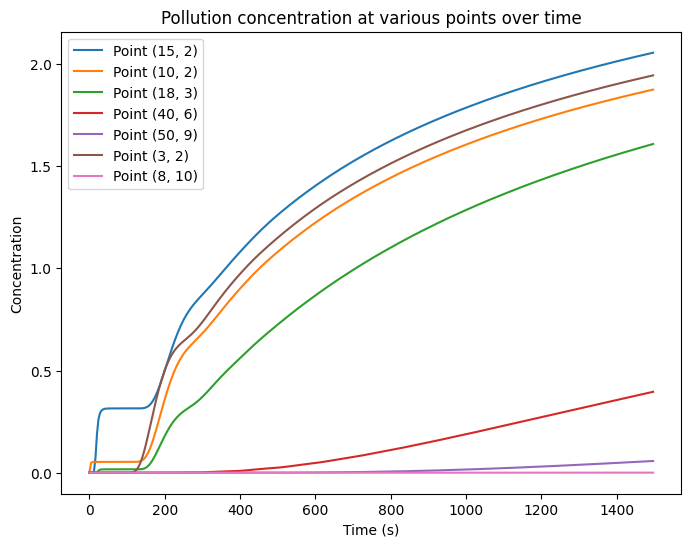

In [ ]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

# Decreasing kappa to 0.005

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.5 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 5e-3 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

# Example points to monitor concentration changes
points = [(15, 2),(10,2),(18,3), (40,6),(50,9), (3,2),(8,10)]  # (x, y) coordinates

plt.figure(figsize=(8, 6))
for (px, py) in points:
    i, j = np.argmin(np.abs(x - px)), np.argmin(np.abs(y - py))
    concentration_time_series = [c[i, j] for c in c_save]
    plt.plot(t_save, concentration_time_series, label=f'Point ({px}, {py})')

plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()
plt.title('Pollution concentration at various points over time')
plt.show()

When $\kappa$ was reduced, the pollution concentration curves exhibited sharper transitions and higher peaks near the source. For instance, at Point (10, 2), the concentration peaked at approximately 2.0, which is still high but lower than in the original flow. This suggests that reduced diffusion limits the pollutant's ability to spread, causing more pronounced accumulation near the source. At farther points such as (40, 6) and (50, 9), pollution arrived more slowly, and the transient periods were extended, as the pollutants depended more heavily on advection for downstream transport.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+00/s


2024-12-27 07:14:33,569 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+00/s


INFO:__main__:Starting main loop


2024-12-27 07:14:33,578 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.906250e-01, dt=3.906250e-01


2024-12-27 07:14:33,623 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e-01, dt=3.906250e-01


INFO:__main__:Iteration=11, Time=4.296875e+00, dt=3.906250e-01


2024-12-27 07:14:33,658 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+00, dt=3.906250e-01


INFO:__main__:Iteration=21, Time=8.203125e+00, dt=3.906250e-01


2024-12-27 07:14:33,687 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+00, dt=3.906250e-01


INFO:__main__:Iteration=31, Time=1.210938e+01, dt=3.906250e-01


2024-12-27 07:14:33,716 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+01, dt=3.906250e-01


INFO:__main__:Iteration=41, Time=1.601562e+01, dt=3.906250e-01


2024-12-27 07:14:33,746 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+01, dt=3.906250e-01


INFO:__main__:Iteration=51, Time=1.992188e+01, dt=3.906250e-01


2024-12-27 07:14:33,779 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+01, dt=3.906250e-01


INFO:__main__:Iteration=61, Time=2.382812e+01, dt=3.906250e-01


2024-12-27 07:14:33,819 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+01, dt=3.906250e-01


INFO:__main__:Iteration=71, Time=2.773438e+01, dt=3.906250e-01


2024-12-27 07:14:33,857 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+01, dt=3.906250e-01


INFO:__main__:Iteration=81, Time=3.164062e+01, dt=3.906250e-01


2024-12-27 07:14:33,897 __main__ 0/1 INFO :: Iteration=81, Time=3.164062e+01, dt=3.906250e-01


INFO:__main__:Iteration=91, Time=3.554688e+01, dt=3.906250e-01


2024-12-27 07:14:33,934 __main__ 0/1 INFO :: Iteration=91, Time=3.554688e+01, dt=3.906250e-01


INFO:__main__:Iteration=101, Time=3.945312e+01, dt=3.906250e-01


2024-12-27 07:14:33,978 __main__ 0/1 INFO :: Iteration=101, Time=3.945312e+01, dt=3.906250e-01


INFO:__main__:Iteration=111, Time=4.335938e+01, dt=3.906250e-01


2024-12-27 07:14:34,027 __main__ 0/1 INFO :: Iteration=111, Time=4.335938e+01, dt=3.906250e-01


INFO:__main__:Iteration=121, Time=4.726562e+01, dt=3.906250e-01


2024-12-27 07:14:34,069 __main__ 0/1 INFO :: Iteration=121, Time=4.726562e+01, dt=3.906250e-01


INFO:__main__:Iteration=131, Time=5.117188e+01, dt=3.906250e-01


2024-12-27 07:14:34,113 __main__ 0/1 INFO :: Iteration=131, Time=5.117188e+01, dt=3.906250e-01


INFO:__main__:Iteration=141, Time=5.507812e+01, dt=3.906250e-01


2024-12-27 07:14:34,144 __main__ 0/1 INFO :: Iteration=141, Time=5.507812e+01, dt=3.906250e-01


INFO:__main__:Iteration=151, Time=5.898438e+01, dt=3.906250e-01


2024-12-27 07:14:34,174 __main__ 0/1 INFO :: Iteration=151, Time=5.898438e+01, dt=3.906250e-01


INFO:__main__:Iteration=161, Time=6.289062e+01, dt=3.906250e-01


2024-12-27 07:14:34,205 __main__ 0/1 INFO :: Iteration=161, Time=6.289062e+01, dt=3.906250e-01


INFO:__main__:Iteration=171, Time=6.679688e+01, dt=3.906250e-01


2024-12-27 07:14:34,235 __main__ 0/1 INFO :: Iteration=171, Time=6.679688e+01, dt=3.906250e-01


INFO:__main__:Iteration=181, Time=7.070312e+01, dt=3.906250e-01


2024-12-27 07:14:34,265 __main__ 0/1 INFO :: Iteration=181, Time=7.070312e+01, dt=3.906250e-01


INFO:__main__:Iteration=191, Time=7.460938e+01, dt=3.906250e-01


2024-12-27 07:14:34,297 __main__ 0/1 INFO :: Iteration=191, Time=7.460938e+01, dt=3.906250e-01


INFO:__main__:Iteration=201, Time=7.851562e+01, dt=3.906250e-01


2024-12-27 07:14:34,328 __main__ 0/1 INFO :: Iteration=201, Time=7.851562e+01, dt=3.906250e-01


INFO:__main__:Iteration=211, Time=8.242188e+01, dt=3.906250e-01


2024-12-27 07:14:34,357 __main__ 0/1 INFO :: Iteration=211, Time=8.242188e+01, dt=3.906250e-01


INFO:__main__:Iteration=221, Time=8.632812e+01, dt=3.906250e-01


2024-12-27 07:14:34,389 __main__ 0/1 INFO :: Iteration=221, Time=8.632812e+01, dt=3.906250e-01


INFO:__main__:Iteration=231, Time=9.023438e+01, dt=3.906250e-01


2024-12-27 07:14:34,421 __main__ 0/1 INFO :: Iteration=231, Time=9.023438e+01, dt=3.906250e-01


INFO:__main__:Iteration=241, Time=9.414062e+01, dt=3.906250e-01


2024-12-27 07:14:34,462 __main__ 0/1 INFO :: Iteration=241, Time=9.414062e+01, dt=3.906250e-01


INFO:__main__:Iteration=251, Time=9.804688e+01, dt=3.906250e-01


2024-12-27 07:14:34,495 __main__ 0/1 INFO :: Iteration=251, Time=9.804688e+01, dt=3.906250e-01


INFO:__main__:Iteration=261, Time=1.019531e+02, dt=3.906250e-01


2024-12-27 07:14:34,529 __main__ 0/1 INFO :: Iteration=261, Time=1.019531e+02, dt=3.906250e-01


INFO:__main__:Iteration=271, Time=1.058594e+02, dt=3.906250e-01


2024-12-27 07:14:34,562 __main__ 0/1 INFO :: Iteration=271, Time=1.058594e+02, dt=3.906250e-01


INFO:__main__:Iteration=281, Time=1.097656e+02, dt=3.906250e-01


2024-12-27 07:14:34,592 __main__ 0/1 INFO :: Iteration=281, Time=1.097656e+02, dt=3.906250e-01


INFO:__main__:Iteration=291, Time=1.136719e+02, dt=3.906250e-01


2024-12-27 07:14:34,623 __main__ 0/1 INFO :: Iteration=291, Time=1.136719e+02, dt=3.906250e-01


INFO:__main__:Iteration=301, Time=1.175781e+02, dt=3.906250e-01


2024-12-27 07:14:34,654 __main__ 0/1 INFO :: Iteration=301, Time=1.175781e+02, dt=3.906250e-01


INFO:__main__:Iteration=311, Time=1.214844e+02, dt=3.906250e-01


2024-12-27 07:14:34,685 __main__ 0/1 INFO :: Iteration=311, Time=1.214844e+02, dt=3.906250e-01


INFO:__main__:Iteration=321, Time=1.253906e+02, dt=3.906250e-01


2024-12-27 07:14:34,716 __main__ 0/1 INFO :: Iteration=321, Time=1.253906e+02, dt=3.906250e-01


INFO:__main__:Iteration=331, Time=1.292969e+02, dt=3.906250e-01


2024-12-27 07:14:34,747 __main__ 0/1 INFO :: Iteration=331, Time=1.292969e+02, dt=3.906250e-01


INFO:__main__:Iteration=341, Time=1.332031e+02, dt=3.906250e-01


2024-12-27 07:14:34,785 __main__ 0/1 INFO :: Iteration=341, Time=1.332031e+02, dt=3.906250e-01


INFO:__main__:Iteration=351, Time=1.371094e+02, dt=3.906250e-01


2024-12-27 07:14:34,826 __main__ 0/1 INFO :: Iteration=351, Time=1.371094e+02, dt=3.906250e-01


INFO:__main__:Iteration=361, Time=1.410156e+02, dt=3.906250e-01


2024-12-27 07:14:34,865 __main__ 0/1 INFO :: Iteration=361, Time=1.410156e+02, dt=3.906250e-01


INFO:__main__:Iteration=371, Time=1.449219e+02, dt=3.906250e-01


2024-12-27 07:14:34,903 __main__ 0/1 INFO :: Iteration=371, Time=1.449219e+02, dt=3.906250e-01


INFO:__main__:Iteration=381, Time=1.488281e+02, dt=3.906250e-01


2024-12-27 07:14:34,944 __main__ 0/1 INFO :: Iteration=381, Time=1.488281e+02, dt=3.906250e-01


INFO:__main__:Iteration=391, Time=1.527344e+02, dt=3.906250e-01


2024-12-27 07:14:34,982 __main__ 0/1 INFO :: Iteration=391, Time=1.527344e+02, dt=3.906250e-01


INFO:__main__:Iteration=401, Time=1.566406e+02, dt=3.906250e-01


2024-12-27 07:14:35,026 __main__ 0/1 INFO :: Iteration=401, Time=1.566406e+02, dt=3.906250e-01


INFO:__main__:Iteration=411, Time=1.605469e+02, dt=3.906250e-01


2024-12-27 07:14:35,072 __main__ 0/1 INFO :: Iteration=411, Time=1.605469e+02, dt=3.906250e-01


INFO:__main__:Iteration=421, Time=1.644531e+02, dt=3.906250e-01


2024-12-27 07:14:35,128 __main__ 0/1 INFO :: Iteration=421, Time=1.644531e+02, dt=3.906250e-01


INFO:__main__:Iteration=431, Time=1.683594e+02, dt=3.906250e-01


2024-12-27 07:14:35,186 __main__ 0/1 INFO :: Iteration=431, Time=1.683594e+02, dt=3.906250e-01


INFO:__main__:Iteration=441, Time=1.722656e+02, dt=3.906250e-01


2024-12-27 07:14:35,224 __main__ 0/1 INFO :: Iteration=441, Time=1.722656e+02, dt=3.906250e-01


INFO:__main__:Iteration=451, Time=1.761719e+02, dt=3.906250e-01


2024-12-27 07:14:35,264 __main__ 0/1 INFO :: Iteration=451, Time=1.761719e+02, dt=3.906250e-01


INFO:__main__:Iteration=461, Time=1.800781e+02, dt=3.906250e-01


2024-12-27 07:14:35,307 __main__ 0/1 INFO :: Iteration=461, Time=1.800781e+02, dt=3.906250e-01


INFO:__main__:Iteration=471, Time=1.839844e+02, dt=3.906250e-01


2024-12-27 07:14:35,341 __main__ 0/1 INFO :: Iteration=471, Time=1.839844e+02, dt=3.906250e-01


INFO:__main__:Iteration=481, Time=1.878906e+02, dt=3.906250e-01


2024-12-27 07:14:35,383 __main__ 0/1 INFO :: Iteration=481, Time=1.878906e+02, dt=3.906250e-01


INFO:__main__:Iteration=491, Time=1.917969e+02, dt=3.906250e-01


2024-12-27 07:14:35,418 __main__ 0/1 INFO :: Iteration=491, Time=1.917969e+02, dt=3.906250e-01


INFO:__main__:Iteration=501, Time=1.957031e+02, dt=3.906250e-01


2024-12-27 07:14:35,455 __main__ 0/1 INFO :: Iteration=501, Time=1.957031e+02, dt=3.906250e-01


INFO:__main__:Iteration=511, Time=1.996094e+02, dt=3.906250e-01


2024-12-27 07:14:35,487 __main__ 0/1 INFO :: Iteration=511, Time=1.996094e+02, dt=3.906250e-01


INFO:__main__:Iteration=521, Time=2.035156e+02, dt=3.906250e-01


2024-12-27 07:14:35,523 __main__ 0/1 INFO :: Iteration=521, Time=2.035156e+02, dt=3.906250e-01


INFO:__main__:Iteration=531, Time=2.074219e+02, dt=3.906250e-01


2024-12-27 07:14:35,571 __main__ 0/1 INFO :: Iteration=531, Time=2.074219e+02, dt=3.906250e-01


INFO:__main__:Iteration=541, Time=2.113281e+02, dt=3.906250e-01


2024-12-27 07:14:35,608 __main__ 0/1 INFO :: Iteration=541, Time=2.113281e+02, dt=3.906250e-01


INFO:__main__:Iteration=551, Time=2.152344e+02, dt=3.906250e-01


2024-12-27 07:14:35,645 __main__ 0/1 INFO :: Iteration=551, Time=2.152344e+02, dt=3.906250e-01


INFO:__main__:Iteration=561, Time=2.191406e+02, dt=3.906250e-01


2024-12-27 07:14:35,688 __main__ 0/1 INFO :: Iteration=561, Time=2.191406e+02, dt=3.906250e-01


INFO:__main__:Iteration=571, Time=2.230469e+02, dt=3.906250e-01


2024-12-27 07:14:35,736 __main__ 0/1 INFO :: Iteration=571, Time=2.230469e+02, dt=3.906250e-01


INFO:__main__:Iteration=581, Time=2.269531e+02, dt=3.906250e-01


2024-12-27 07:14:35,789 __main__ 0/1 INFO :: Iteration=581, Time=2.269531e+02, dt=3.906250e-01


INFO:__main__:Iteration=591, Time=2.308594e+02, dt=3.906250e-01


2024-12-27 07:14:35,854 __main__ 0/1 INFO :: Iteration=591, Time=2.308594e+02, dt=3.906250e-01


INFO:__main__:Iteration=601, Time=2.347656e+02, dt=3.906250e-01


2024-12-27 07:14:35,918 __main__ 0/1 INFO :: Iteration=601, Time=2.347656e+02, dt=3.906250e-01


INFO:__main__:Iteration=611, Time=2.386719e+02, dt=3.906250e-01


2024-12-27 07:14:35,976 __main__ 0/1 INFO :: Iteration=611, Time=2.386719e+02, dt=3.906250e-01


INFO:__main__:Iteration=621, Time=2.425781e+02, dt=3.906250e-01


2024-12-27 07:14:36,033 __main__ 0/1 INFO :: Iteration=621, Time=2.425781e+02, dt=3.906250e-01


INFO:__main__:Iteration=631, Time=2.464844e+02, dt=3.906250e-01


2024-12-27 07:14:36,078 __main__ 0/1 INFO :: Iteration=631, Time=2.464844e+02, dt=3.906250e-01


INFO:__main__:Iteration=641, Time=2.503906e+02, dt=3.906250e-01


2024-12-27 07:14:36,119 __main__ 0/1 INFO :: Iteration=641, Time=2.503906e+02, dt=3.906250e-01


INFO:__main__:Iteration=651, Time=2.542969e+02, dt=3.906250e-01


2024-12-27 07:14:36,150 __main__ 0/1 INFO :: Iteration=651, Time=2.542969e+02, dt=3.906250e-01


INFO:__main__:Iteration=661, Time=2.582031e+02, dt=3.906250e-01


2024-12-27 07:14:36,188 __main__ 0/1 INFO :: Iteration=661, Time=2.582031e+02, dt=3.906250e-01


INFO:__main__:Iteration=671, Time=2.621094e+02, dt=3.906250e-01


2024-12-27 07:14:36,242 __main__ 0/1 INFO :: Iteration=671, Time=2.621094e+02, dt=3.906250e-01


INFO:__main__:Iteration=681, Time=2.660156e+02, dt=3.906250e-01


2024-12-27 07:14:36,277 __main__ 0/1 INFO :: Iteration=681, Time=2.660156e+02, dt=3.906250e-01


INFO:__main__:Iteration=691, Time=2.699219e+02, dt=3.906250e-01


2024-12-27 07:14:36,313 __main__ 0/1 INFO :: Iteration=691, Time=2.699219e+02, dt=3.906250e-01


INFO:__main__:Iteration=701, Time=2.738281e+02, dt=3.906250e-01


2024-12-27 07:14:36,344 __main__ 0/1 INFO :: Iteration=701, Time=2.738281e+02, dt=3.906250e-01


INFO:__main__:Iteration=711, Time=2.777344e+02, dt=3.906250e-01


2024-12-27 07:14:36,380 __main__ 0/1 INFO :: Iteration=711, Time=2.777344e+02, dt=3.906250e-01


INFO:__main__:Iteration=721, Time=2.816406e+02, dt=3.906250e-01


2024-12-27 07:14:36,412 __main__ 0/1 INFO :: Iteration=721, Time=2.816406e+02, dt=3.906250e-01


INFO:__main__:Iteration=731, Time=2.855469e+02, dt=3.906250e-01


2024-12-27 07:14:36,444 __main__ 0/1 INFO :: Iteration=731, Time=2.855469e+02, dt=3.906250e-01


INFO:__main__:Iteration=741, Time=2.894531e+02, dt=3.906250e-01


2024-12-27 07:14:36,478 __main__ 0/1 INFO :: Iteration=741, Time=2.894531e+02, dt=3.906250e-01


INFO:__main__:Iteration=751, Time=2.933594e+02, dt=3.906250e-01


2024-12-27 07:14:36,515 __main__ 0/1 INFO :: Iteration=751, Time=2.933594e+02, dt=3.906250e-01


INFO:__main__:Iteration=761, Time=2.972656e+02, dt=3.906250e-01


2024-12-27 07:14:36,552 __main__ 0/1 INFO :: Iteration=761, Time=2.972656e+02, dt=3.906250e-01


INFO:__main__:Iteration=771, Time=3.011719e+02, dt=3.906250e-01


2024-12-27 07:14:36,590 __main__ 0/1 INFO :: Iteration=771, Time=3.011719e+02, dt=3.906250e-01


INFO:__main__:Iteration=781, Time=3.050781e+02, dt=3.906250e-01


2024-12-27 07:14:36,627 __main__ 0/1 INFO :: Iteration=781, Time=3.050781e+02, dt=3.906250e-01


INFO:__main__:Iteration=791, Time=3.089844e+02, dt=3.906250e-01


2024-12-27 07:14:36,660 __main__ 0/1 INFO :: Iteration=791, Time=3.089844e+02, dt=3.906250e-01


INFO:__main__:Iteration=801, Time=3.128906e+02, dt=3.906250e-01


2024-12-27 07:14:36,696 __main__ 0/1 INFO :: Iteration=801, Time=3.128906e+02, dt=3.906250e-01


INFO:__main__:Iteration=811, Time=3.167969e+02, dt=3.906250e-01


2024-12-27 07:14:36,727 __main__ 0/1 INFO :: Iteration=811, Time=3.167969e+02, dt=3.906250e-01


INFO:__main__:Iteration=821, Time=3.207031e+02, dt=3.906250e-01


2024-12-27 07:14:36,760 __main__ 0/1 INFO :: Iteration=821, Time=3.207031e+02, dt=3.906250e-01


INFO:__main__:Iteration=831, Time=3.246094e+02, dt=3.906250e-01


2024-12-27 07:14:36,798 __main__ 0/1 INFO :: Iteration=831, Time=3.246094e+02, dt=3.906250e-01


INFO:__main__:Iteration=841, Time=3.285156e+02, dt=3.906250e-01


2024-12-27 07:14:36,838 __main__ 0/1 INFO :: Iteration=841, Time=3.285156e+02, dt=3.906250e-01


INFO:__main__:Iteration=851, Time=3.324219e+02, dt=3.906250e-01


2024-12-27 07:14:36,877 __main__ 0/1 INFO :: Iteration=851, Time=3.324219e+02, dt=3.906250e-01


INFO:__main__:Iteration=861, Time=3.363281e+02, dt=3.906250e-01


2024-12-27 07:14:36,919 __main__ 0/1 INFO :: Iteration=861, Time=3.363281e+02, dt=3.906250e-01


INFO:__main__:Iteration=871, Time=3.402344e+02, dt=3.906250e-01


2024-12-27 07:14:36,963 __main__ 0/1 INFO :: Iteration=871, Time=3.402344e+02, dt=3.906250e-01


INFO:__main__:Iteration=881, Time=3.441406e+02, dt=3.906250e-01


2024-12-27 07:14:37,001 __main__ 0/1 INFO :: Iteration=881, Time=3.441406e+02, dt=3.906250e-01


INFO:__main__:Iteration=891, Time=3.480469e+02, dt=3.906250e-01


2024-12-27 07:14:37,037 __main__ 0/1 INFO :: Iteration=891, Time=3.480469e+02, dt=3.906250e-01


INFO:__main__:Iteration=901, Time=3.519531e+02, dt=3.906250e-01


2024-12-27 07:14:37,080 __main__ 0/1 INFO :: Iteration=901, Time=3.519531e+02, dt=3.906250e-01


INFO:__main__:Iteration=911, Time=3.558594e+02, dt=3.906250e-01


2024-12-27 07:14:37,122 __main__ 0/1 INFO :: Iteration=911, Time=3.558594e+02, dt=3.906250e-01


INFO:__main__:Iteration=921, Time=3.597656e+02, dt=3.906250e-01


2024-12-27 07:14:37,170 __main__ 0/1 INFO :: Iteration=921, Time=3.597656e+02, dt=3.906250e-01


INFO:__main__:Iteration=931, Time=3.636719e+02, dt=3.906250e-01


2024-12-27 07:14:37,217 __main__ 0/1 INFO :: Iteration=931, Time=3.636719e+02, dt=3.906250e-01


INFO:__main__:Iteration=941, Time=3.675781e+02, dt=3.906250e-01


2024-12-27 07:14:37,260 __main__ 0/1 INFO :: Iteration=941, Time=3.675781e+02, dt=3.906250e-01


INFO:__main__:Iteration=951, Time=3.714844e+02, dt=3.906250e-01


2024-12-27 07:14:37,298 __main__ 0/1 INFO :: Iteration=951, Time=3.714844e+02, dt=3.906250e-01


INFO:__main__:Iteration=961, Time=3.753906e+02, dt=3.906250e-01


2024-12-27 07:14:37,331 __main__ 0/1 INFO :: Iteration=961, Time=3.753906e+02, dt=3.906250e-01


INFO:__main__:Iteration=971, Time=3.792969e+02, dt=3.906250e-01


2024-12-27 07:14:37,362 __main__ 0/1 INFO :: Iteration=971, Time=3.792969e+02, dt=3.906250e-01


INFO:__main__:Iteration=981, Time=3.832031e+02, dt=3.906250e-01


2024-12-27 07:14:37,403 __main__ 0/1 INFO :: Iteration=981, Time=3.832031e+02, dt=3.906250e-01


INFO:__main__:Iteration=991, Time=3.871094e+02, dt=3.906250e-01


2024-12-27 07:14:37,444 __main__ 0/1 INFO :: Iteration=991, Time=3.871094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1001, Time=3.910156e+02, dt=3.906250e-01


2024-12-27 07:14:37,496 __main__ 0/1 INFO :: Iteration=1001, Time=3.910156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1011, Time=3.949219e+02, dt=3.906250e-01


2024-12-27 07:14:37,538 __main__ 0/1 INFO :: Iteration=1011, Time=3.949219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1021, Time=3.988281e+02, dt=3.906250e-01


2024-12-27 07:14:37,575 __main__ 0/1 INFO :: Iteration=1021, Time=3.988281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1031, Time=4.027344e+02, dt=3.906250e-01


2024-12-27 07:14:37,612 __main__ 0/1 INFO :: Iteration=1031, Time=4.027344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1041, Time=4.066406e+02, dt=3.906250e-01


2024-12-27 07:14:37,646 __main__ 0/1 INFO :: Iteration=1041, Time=4.066406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1051, Time=4.105469e+02, dt=3.906250e-01


2024-12-27 07:14:37,685 __main__ 0/1 INFO :: Iteration=1051, Time=4.105469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1061, Time=4.144531e+02, dt=3.906250e-01


2024-12-27 07:14:37,720 __main__ 0/1 INFO :: Iteration=1061, Time=4.144531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1071, Time=4.183594e+02, dt=3.906250e-01


2024-12-27 07:14:37,752 __main__ 0/1 INFO :: Iteration=1071, Time=4.183594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1081, Time=4.222656e+02, dt=3.906250e-01


2024-12-27 07:14:37,790 __main__ 0/1 INFO :: Iteration=1081, Time=4.222656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1091, Time=4.261719e+02, dt=3.906250e-01


2024-12-27 07:14:37,832 __main__ 0/1 INFO :: Iteration=1091, Time=4.261719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1101, Time=4.300781e+02, dt=3.906250e-01


2024-12-27 07:14:37,875 __main__ 0/1 INFO :: Iteration=1101, Time=4.300781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1111, Time=4.339844e+02, dt=3.906250e-01


2024-12-27 07:14:37,919 __main__ 0/1 INFO :: Iteration=1111, Time=4.339844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1121, Time=4.378906e+02, dt=3.906250e-01


2024-12-27 07:14:37,962 __main__ 0/1 INFO :: Iteration=1121, Time=4.378906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1131, Time=4.417969e+02, dt=3.906250e-01


2024-12-27 07:14:38,002 __main__ 0/1 INFO :: Iteration=1131, Time=4.417969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1141, Time=4.457031e+02, dt=3.906250e-01


2024-12-27 07:14:38,042 __main__ 0/1 INFO :: Iteration=1141, Time=4.457031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1151, Time=4.496094e+02, dt=3.906250e-01


2024-12-27 07:14:38,081 __main__ 0/1 INFO :: Iteration=1151, Time=4.496094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1161, Time=4.535156e+02, dt=3.906250e-01


2024-12-27 07:14:38,123 __main__ 0/1 INFO :: Iteration=1161, Time=4.535156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1171, Time=4.574219e+02, dt=3.906250e-01


2024-12-27 07:14:38,162 __main__ 0/1 INFO :: Iteration=1171, Time=4.574219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1181, Time=4.613281e+02, dt=3.906250e-01


2024-12-27 07:14:38,192 __main__ 0/1 INFO :: Iteration=1181, Time=4.613281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1191, Time=4.652344e+02, dt=3.906250e-01


2024-12-27 07:14:38,228 __main__ 0/1 INFO :: Iteration=1191, Time=4.652344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1201, Time=4.691406e+02, dt=3.906250e-01


2024-12-27 07:14:38,260 __main__ 0/1 INFO :: Iteration=1201, Time=4.691406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1211, Time=4.730469e+02, dt=3.906250e-01


2024-12-27 07:14:38,302 __main__ 0/1 INFO :: Iteration=1211, Time=4.730469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1221, Time=4.769531e+02, dt=3.906250e-01


2024-12-27 07:14:38,345 __main__ 0/1 INFO :: Iteration=1221, Time=4.769531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1231, Time=4.808594e+02, dt=3.906250e-01


2024-12-27 07:14:38,380 __main__ 0/1 INFO :: Iteration=1231, Time=4.808594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1241, Time=4.847656e+02, dt=3.906250e-01


2024-12-27 07:14:38,414 __main__ 0/1 INFO :: Iteration=1241, Time=4.847656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1251, Time=4.886719e+02, dt=3.906250e-01


2024-12-27 07:14:38,447 __main__ 0/1 INFO :: Iteration=1251, Time=4.886719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1261, Time=4.925781e+02, dt=3.906250e-01


2024-12-27 07:14:38,480 __main__ 0/1 INFO :: Iteration=1261, Time=4.925781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1271, Time=4.964844e+02, dt=3.906250e-01


2024-12-27 07:14:38,512 __main__ 0/1 INFO :: Iteration=1271, Time=4.964844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1281, Time=5.003906e+02, dt=3.906250e-01


2024-12-27 07:14:38,550 __main__ 0/1 INFO :: Iteration=1281, Time=5.003906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1291, Time=5.042969e+02, dt=3.906250e-01


2024-12-27 07:14:38,591 __main__ 0/1 INFO :: Iteration=1291, Time=5.042969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1301, Time=5.082031e+02, dt=3.906250e-01


2024-12-27 07:14:38,627 __main__ 0/1 INFO :: Iteration=1301, Time=5.082031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1311, Time=5.121094e+02, dt=3.906250e-01


2024-12-27 07:14:38,663 __main__ 0/1 INFO :: Iteration=1311, Time=5.121094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1321, Time=5.160156e+02, dt=3.906250e-01


2024-12-27 07:14:38,701 __main__ 0/1 INFO :: Iteration=1321, Time=5.160156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1331, Time=5.199219e+02, dt=3.906250e-01


2024-12-27 07:14:38,741 __main__ 0/1 INFO :: Iteration=1331, Time=5.199219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1341, Time=5.238281e+02, dt=3.906250e-01


2024-12-27 07:14:38,780 __main__ 0/1 INFO :: Iteration=1341, Time=5.238281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1351, Time=5.277344e+02, dt=3.906250e-01


2024-12-27 07:14:38,826 __main__ 0/1 INFO :: Iteration=1351, Time=5.277344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1361, Time=5.316406e+02, dt=3.906250e-01


2024-12-27 07:14:38,876 __main__ 0/1 INFO :: Iteration=1361, Time=5.316406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1371, Time=5.355469e+02, dt=3.906250e-01


2024-12-27 07:14:38,918 __main__ 0/1 INFO :: Iteration=1371, Time=5.355469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1381, Time=5.394531e+02, dt=3.906250e-01


2024-12-27 07:14:38,969 __main__ 0/1 INFO :: Iteration=1381, Time=5.394531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1391, Time=5.433594e+02, dt=3.906250e-01


2024-12-27 07:14:39,017 __main__ 0/1 INFO :: Iteration=1391, Time=5.433594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1401, Time=5.472656e+02, dt=3.906250e-01


2024-12-27 07:14:39,071 __main__ 0/1 INFO :: Iteration=1401, Time=5.472656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1411, Time=5.511719e+02, dt=3.906250e-01


2024-12-27 07:14:39,118 __main__ 0/1 INFO :: Iteration=1411, Time=5.511719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1421, Time=5.550781e+02, dt=3.906250e-01


2024-12-27 07:14:39,162 __main__ 0/1 INFO :: Iteration=1421, Time=5.550781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1431, Time=5.589844e+02, dt=3.906250e-01


2024-12-27 07:14:39,206 __main__ 0/1 INFO :: Iteration=1431, Time=5.589844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1441, Time=5.628906e+02, dt=3.906250e-01


2024-12-27 07:14:39,249 __main__ 0/1 INFO :: Iteration=1441, Time=5.628906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1451, Time=5.667969e+02, dt=3.906250e-01


2024-12-27 07:14:39,293 __main__ 0/1 INFO :: Iteration=1451, Time=5.667969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1461, Time=5.707031e+02, dt=3.906250e-01


2024-12-27 07:14:39,351 __main__ 0/1 INFO :: Iteration=1461, Time=5.707031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1471, Time=5.746094e+02, dt=3.906250e-01


2024-12-27 07:14:39,390 __main__ 0/1 INFO :: Iteration=1471, Time=5.746094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1481, Time=5.785156e+02, dt=3.906250e-01


2024-12-27 07:14:39,426 __main__ 0/1 INFO :: Iteration=1481, Time=5.785156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1491, Time=5.824219e+02, dt=3.906250e-01


2024-12-27 07:14:39,461 __main__ 0/1 INFO :: Iteration=1491, Time=5.824219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1501, Time=5.863281e+02, dt=3.906250e-01


2024-12-27 07:14:39,505 __main__ 0/1 INFO :: Iteration=1501, Time=5.863281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1511, Time=5.902344e+02, dt=3.906250e-01


2024-12-27 07:14:39,551 __main__ 0/1 INFO :: Iteration=1511, Time=5.902344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1521, Time=5.941406e+02, dt=3.906250e-01


2024-12-27 07:14:39,600 __main__ 0/1 INFO :: Iteration=1521, Time=5.941406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1531, Time=5.980469e+02, dt=3.906250e-01


2024-12-27 07:14:39,644 __main__ 0/1 INFO :: Iteration=1531, Time=5.980469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1541, Time=6.019531e+02, dt=3.906250e-01


2024-12-27 07:14:39,681 __main__ 0/1 INFO :: Iteration=1541, Time=6.019531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1551, Time=6.058594e+02, dt=3.906250e-01


2024-12-27 07:14:39,718 __main__ 0/1 INFO :: Iteration=1551, Time=6.058594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1561, Time=6.097656e+02, dt=3.906250e-01


2024-12-27 07:14:39,751 __main__ 0/1 INFO :: Iteration=1561, Time=6.097656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1571, Time=6.136719e+02, dt=3.906250e-01


2024-12-27 07:14:39,788 __main__ 0/1 INFO :: Iteration=1571, Time=6.136719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1581, Time=6.175781e+02, dt=3.906250e-01


2024-12-27 07:14:39,828 __main__ 0/1 INFO :: Iteration=1581, Time=6.175781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1591, Time=6.214844e+02, dt=3.906250e-01


2024-12-27 07:14:39,867 __main__ 0/1 INFO :: Iteration=1591, Time=6.214844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1601, Time=6.253906e+02, dt=3.906250e-01


2024-12-27 07:14:39,911 __main__ 0/1 INFO :: Iteration=1601, Time=6.253906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1611, Time=6.292969e+02, dt=3.906250e-01


2024-12-27 07:14:39,959 __main__ 0/1 INFO :: Iteration=1611, Time=6.292969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1621, Time=6.332031e+02, dt=3.906250e-01


2024-12-27 07:14:40,004 __main__ 0/1 INFO :: Iteration=1621, Time=6.332031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1631, Time=6.371094e+02, dt=3.906250e-01


2024-12-27 07:14:40,050 __main__ 0/1 INFO :: Iteration=1631, Time=6.371094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1641, Time=6.410156e+02, dt=3.906250e-01


2024-12-27 07:14:40,084 __main__ 0/1 INFO :: Iteration=1641, Time=6.410156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1651, Time=6.449219e+02, dt=3.906250e-01


2024-12-27 07:14:40,119 __main__ 0/1 INFO :: Iteration=1651, Time=6.449219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1661, Time=6.488281e+02, dt=3.906250e-01


2024-12-27 07:14:40,152 __main__ 0/1 INFO :: Iteration=1661, Time=6.488281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1671, Time=6.527344e+02, dt=3.906250e-01


2024-12-27 07:14:40,185 __main__ 0/1 INFO :: Iteration=1671, Time=6.527344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1681, Time=6.566406e+02, dt=3.906250e-01


2024-12-27 07:14:40,220 __main__ 0/1 INFO :: Iteration=1681, Time=6.566406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1691, Time=6.605469e+02, dt=3.906250e-01


2024-12-27 07:14:40,253 __main__ 0/1 INFO :: Iteration=1691, Time=6.605469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1701, Time=6.644531e+02, dt=3.906250e-01


2024-12-27 07:14:40,290 __main__ 0/1 INFO :: Iteration=1701, Time=6.644531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1711, Time=6.683594e+02, dt=3.906250e-01


2024-12-27 07:14:40,327 __main__ 0/1 INFO :: Iteration=1711, Time=6.683594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1721, Time=6.722656e+02, dt=3.906250e-01


2024-12-27 07:14:40,364 __main__ 0/1 INFO :: Iteration=1721, Time=6.722656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1731, Time=6.761719e+02, dt=3.906250e-01


2024-12-27 07:14:40,409 __main__ 0/1 INFO :: Iteration=1731, Time=6.761719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1741, Time=6.800781e+02, dt=3.906250e-01


2024-12-27 07:14:40,444 __main__ 0/1 INFO :: Iteration=1741, Time=6.800781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1751, Time=6.839844e+02, dt=3.906250e-01


2024-12-27 07:14:40,479 __main__ 0/1 INFO :: Iteration=1751, Time=6.839844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1761, Time=6.878906e+02, dt=3.906250e-01


2024-12-27 07:14:40,513 __main__ 0/1 INFO :: Iteration=1761, Time=6.878906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1771, Time=6.917969e+02, dt=3.906250e-01


2024-12-27 07:14:40,549 __main__ 0/1 INFO :: Iteration=1771, Time=6.917969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1781, Time=6.957031e+02, dt=3.906250e-01


2024-12-27 07:14:40,583 __main__ 0/1 INFO :: Iteration=1781, Time=6.957031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1791, Time=6.996094e+02, dt=3.906250e-01


2024-12-27 07:14:40,617 __main__ 0/1 INFO :: Iteration=1791, Time=6.996094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1801, Time=7.035156e+02, dt=3.906250e-01


2024-12-27 07:14:40,653 __main__ 0/1 INFO :: Iteration=1801, Time=7.035156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1811, Time=7.074219e+02, dt=3.906250e-01


2024-12-27 07:14:40,687 __main__ 0/1 INFO :: Iteration=1811, Time=7.074219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1821, Time=7.113281e+02, dt=3.906250e-01


2024-12-27 07:14:40,721 __main__ 0/1 INFO :: Iteration=1821, Time=7.113281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1831, Time=7.152344e+02, dt=3.906250e-01


2024-12-27 07:14:40,759 __main__ 0/1 INFO :: Iteration=1831, Time=7.152344e+02, dt=3.906250e-01


INFO:__main__:Iteration=1841, Time=7.191406e+02, dt=3.906250e-01


2024-12-27 07:14:40,807 __main__ 0/1 INFO :: Iteration=1841, Time=7.191406e+02, dt=3.906250e-01


INFO:__main__:Iteration=1851, Time=7.230469e+02, dt=3.906250e-01


2024-12-27 07:14:40,851 __main__ 0/1 INFO :: Iteration=1851, Time=7.230469e+02, dt=3.906250e-01


INFO:__main__:Iteration=1861, Time=7.269531e+02, dt=3.906250e-01


2024-12-27 07:14:40,894 __main__ 0/1 INFO :: Iteration=1861, Time=7.269531e+02, dt=3.906250e-01


INFO:__main__:Iteration=1871, Time=7.308594e+02, dt=3.906250e-01


2024-12-27 07:14:40,937 __main__ 0/1 INFO :: Iteration=1871, Time=7.308594e+02, dt=3.906250e-01


INFO:__main__:Iteration=1881, Time=7.347656e+02, dt=3.906250e-01


2024-12-27 07:14:40,980 __main__ 0/1 INFO :: Iteration=1881, Time=7.347656e+02, dt=3.906250e-01


INFO:__main__:Iteration=1891, Time=7.386719e+02, dt=3.906250e-01


2024-12-27 07:14:41,023 __main__ 0/1 INFO :: Iteration=1891, Time=7.386719e+02, dt=3.906250e-01


INFO:__main__:Iteration=1901, Time=7.425781e+02, dt=3.906250e-01


2024-12-27 07:14:41,072 __main__ 0/1 INFO :: Iteration=1901, Time=7.425781e+02, dt=3.906250e-01


INFO:__main__:Iteration=1911, Time=7.464844e+02, dt=3.906250e-01


2024-12-27 07:14:41,113 __main__ 0/1 INFO :: Iteration=1911, Time=7.464844e+02, dt=3.906250e-01


INFO:__main__:Iteration=1921, Time=7.503906e+02, dt=3.906250e-01


2024-12-27 07:14:41,156 __main__ 0/1 INFO :: Iteration=1921, Time=7.503906e+02, dt=3.906250e-01


INFO:__main__:Iteration=1931, Time=7.542969e+02, dt=3.906250e-01


2024-12-27 07:14:41,192 __main__ 0/1 INFO :: Iteration=1931, Time=7.542969e+02, dt=3.906250e-01


INFO:__main__:Iteration=1941, Time=7.582031e+02, dt=3.906250e-01


2024-12-27 07:14:41,228 __main__ 0/1 INFO :: Iteration=1941, Time=7.582031e+02, dt=3.906250e-01


INFO:__main__:Iteration=1951, Time=7.621094e+02, dt=3.906250e-01


2024-12-27 07:14:41,261 __main__ 0/1 INFO :: Iteration=1951, Time=7.621094e+02, dt=3.906250e-01


INFO:__main__:Iteration=1961, Time=7.660156e+02, dt=3.906250e-01


2024-12-27 07:14:41,293 __main__ 0/1 INFO :: Iteration=1961, Time=7.660156e+02, dt=3.906250e-01


INFO:__main__:Iteration=1971, Time=7.699219e+02, dt=3.906250e-01


2024-12-27 07:14:41,333 __main__ 0/1 INFO :: Iteration=1971, Time=7.699219e+02, dt=3.906250e-01


INFO:__main__:Iteration=1981, Time=7.738281e+02, dt=3.906250e-01


2024-12-27 07:14:41,365 __main__ 0/1 INFO :: Iteration=1981, Time=7.738281e+02, dt=3.906250e-01


INFO:__main__:Iteration=1991, Time=7.777344e+02, dt=3.906250e-01


2024-12-27 07:14:41,399 __main__ 0/1 INFO :: Iteration=1991, Time=7.777344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2001, Time=7.816406e+02, dt=3.906250e-01


2024-12-27 07:14:41,447 __main__ 0/1 INFO :: Iteration=2001, Time=7.816406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2011, Time=7.855469e+02, dt=3.906250e-01


2024-12-27 07:14:41,482 __main__ 0/1 INFO :: Iteration=2011, Time=7.855469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2021, Time=7.894531e+02, dt=3.906250e-01


2024-12-27 07:14:41,516 __main__ 0/1 INFO :: Iteration=2021, Time=7.894531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2031, Time=7.933594e+02, dt=3.906250e-01


2024-12-27 07:14:41,549 __main__ 0/1 INFO :: Iteration=2031, Time=7.933594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2041, Time=7.972656e+02, dt=3.906250e-01


2024-12-27 07:14:41,582 __main__ 0/1 INFO :: Iteration=2041, Time=7.972656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2051, Time=8.011719e+02, dt=3.906250e-01


2024-12-27 07:14:41,617 __main__ 0/1 INFO :: Iteration=2051, Time=8.011719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2061, Time=8.050781e+02, dt=3.906250e-01


2024-12-27 07:14:41,651 __main__ 0/1 INFO :: Iteration=2061, Time=8.050781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2071, Time=8.089844e+02, dt=3.906250e-01


2024-12-27 07:14:41,683 __main__ 0/1 INFO :: Iteration=2071, Time=8.089844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2081, Time=8.128906e+02, dt=3.906250e-01


2024-12-27 07:14:41,719 __main__ 0/1 INFO :: Iteration=2081, Time=8.128906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2091, Time=8.167969e+02, dt=3.906250e-01


2024-12-27 07:14:41,753 __main__ 0/1 INFO :: Iteration=2091, Time=8.167969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2101, Time=8.207031e+02, dt=3.906250e-01


2024-12-27 07:14:41,793 __main__ 0/1 INFO :: Iteration=2101, Time=8.207031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2111, Time=8.246094e+02, dt=3.906250e-01


2024-12-27 07:14:41,849 __main__ 0/1 INFO :: Iteration=2111, Time=8.246094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2121, Time=8.285156e+02, dt=3.906250e-01


2024-12-27 07:14:41,894 __main__ 0/1 INFO :: Iteration=2121, Time=8.285156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2131, Time=8.324219e+02, dt=3.906250e-01


2024-12-27 07:14:41,942 __main__ 0/1 INFO :: Iteration=2131, Time=8.324219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2141, Time=8.363281e+02, dt=3.906250e-01


2024-12-27 07:14:42,004 __main__ 0/1 INFO :: Iteration=2141, Time=8.363281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2151, Time=8.402344e+02, dt=3.906250e-01


2024-12-27 07:14:42,052 __main__ 0/1 INFO :: Iteration=2151, Time=8.402344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2161, Time=8.441406e+02, dt=3.906250e-01


2024-12-27 07:14:42,100 __main__ 0/1 INFO :: Iteration=2161, Time=8.441406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2171, Time=8.480469e+02, dt=3.906250e-01


2024-12-27 07:14:42,146 __main__ 0/1 INFO :: Iteration=2171, Time=8.480469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2181, Time=8.519531e+02, dt=3.906250e-01


2024-12-27 07:14:42,189 __main__ 0/1 INFO :: Iteration=2181, Time=8.519531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2191, Time=8.558594e+02, dt=3.906250e-01


2024-12-27 07:14:42,243 __main__ 0/1 INFO :: Iteration=2191, Time=8.558594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2201, Time=8.597656e+02, dt=3.906250e-01


2024-12-27 07:14:42,298 __main__ 0/1 INFO :: Iteration=2201, Time=8.597656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2211, Time=8.636719e+02, dt=3.906250e-01


2024-12-27 07:14:42,344 __main__ 0/1 INFO :: Iteration=2211, Time=8.636719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2221, Time=8.675781e+02, dt=3.906250e-01


2024-12-27 07:14:42,385 __main__ 0/1 INFO :: Iteration=2221, Time=8.675781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2231, Time=8.714844e+02, dt=3.906250e-01


2024-12-27 07:14:42,436 __main__ 0/1 INFO :: Iteration=2231, Time=8.714844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2241, Time=8.753906e+02, dt=3.906250e-01


2024-12-27 07:14:42,495 __main__ 0/1 INFO :: Iteration=2241, Time=8.753906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2251, Time=8.792969e+02, dt=3.906250e-01


2024-12-27 07:14:42,541 __main__ 0/1 INFO :: Iteration=2251, Time=8.792969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2261, Time=8.832031e+02, dt=3.906250e-01


2024-12-27 07:14:42,588 __main__ 0/1 INFO :: Iteration=2261, Time=8.832031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2271, Time=8.871094e+02, dt=3.906250e-01


2024-12-27 07:14:42,634 __main__ 0/1 INFO :: Iteration=2271, Time=8.871094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2281, Time=8.910156e+02, dt=3.906250e-01


2024-12-27 07:14:42,676 __main__ 0/1 INFO :: Iteration=2281, Time=8.910156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2291, Time=8.949219e+02, dt=3.906250e-01


2024-12-27 07:14:42,717 __main__ 0/1 INFO :: Iteration=2291, Time=8.949219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2301, Time=8.988281e+02, dt=3.906250e-01


2024-12-27 07:14:42,763 __main__ 0/1 INFO :: Iteration=2301, Time=8.988281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2311, Time=9.027344e+02, dt=3.906250e-01


2024-12-27 07:14:42,817 __main__ 0/1 INFO :: Iteration=2311, Time=9.027344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2321, Time=9.066406e+02, dt=3.906250e-01


2024-12-27 07:14:42,888 __main__ 0/1 INFO :: Iteration=2321, Time=9.066406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2331, Time=9.105469e+02, dt=3.906250e-01


2024-12-27 07:14:42,948 __main__ 0/1 INFO :: Iteration=2331, Time=9.105469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2341, Time=9.144531e+02, dt=3.906250e-01


2024-12-27 07:14:43,003 __main__ 0/1 INFO :: Iteration=2341, Time=9.144531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2351, Time=9.183594e+02, dt=3.906250e-01


2024-12-27 07:14:43,064 __main__ 0/1 INFO :: Iteration=2351, Time=9.183594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2361, Time=9.222656e+02, dt=3.906250e-01


2024-12-27 07:14:43,107 __main__ 0/1 INFO :: Iteration=2361, Time=9.222656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2371, Time=9.261719e+02, dt=3.906250e-01


2024-12-27 07:14:43,148 __main__ 0/1 INFO :: Iteration=2371, Time=9.261719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2381, Time=9.300781e+02, dt=3.906250e-01


2024-12-27 07:14:43,189 __main__ 0/1 INFO :: Iteration=2381, Time=9.300781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2391, Time=9.339844e+02, dt=3.906250e-01


2024-12-27 07:14:43,242 __main__ 0/1 INFO :: Iteration=2391, Time=9.339844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2401, Time=9.378906e+02, dt=3.906250e-01


2024-12-27 07:14:43,285 __main__ 0/1 INFO :: Iteration=2401, Time=9.378906e+02, dt=3.906250e-01


INFO:__main__:Iteration=2411, Time=9.417969e+02, dt=3.906250e-01


2024-12-27 07:14:43,326 __main__ 0/1 INFO :: Iteration=2411, Time=9.417969e+02, dt=3.906250e-01


INFO:__main__:Iteration=2421, Time=9.457031e+02, dt=3.906250e-01


2024-12-27 07:14:43,368 __main__ 0/1 INFO :: Iteration=2421, Time=9.457031e+02, dt=3.906250e-01


INFO:__main__:Iteration=2431, Time=9.496094e+02, dt=3.906250e-01


2024-12-27 07:14:43,410 __main__ 0/1 INFO :: Iteration=2431, Time=9.496094e+02, dt=3.906250e-01


INFO:__main__:Iteration=2441, Time=9.535156e+02, dt=3.906250e-01


2024-12-27 07:14:43,454 __main__ 0/1 INFO :: Iteration=2441, Time=9.535156e+02, dt=3.906250e-01


INFO:__main__:Iteration=2451, Time=9.574219e+02, dt=3.906250e-01


2024-12-27 07:14:43,494 __main__ 0/1 INFO :: Iteration=2451, Time=9.574219e+02, dt=3.906250e-01


INFO:__main__:Iteration=2461, Time=9.613281e+02, dt=3.906250e-01


2024-12-27 07:14:43,550 __main__ 0/1 INFO :: Iteration=2461, Time=9.613281e+02, dt=3.906250e-01


INFO:__main__:Iteration=2471, Time=9.652344e+02, dt=3.906250e-01


2024-12-27 07:14:43,596 __main__ 0/1 INFO :: Iteration=2471, Time=9.652344e+02, dt=3.906250e-01


INFO:__main__:Iteration=2481, Time=9.691406e+02, dt=3.906250e-01


2024-12-27 07:14:43,637 __main__ 0/1 INFO :: Iteration=2481, Time=9.691406e+02, dt=3.906250e-01


INFO:__main__:Iteration=2491, Time=9.730469e+02, dt=3.906250e-01


2024-12-27 07:14:43,677 __main__ 0/1 INFO :: Iteration=2491, Time=9.730469e+02, dt=3.906250e-01


INFO:__main__:Iteration=2501, Time=9.769531e+02, dt=3.906250e-01


2024-12-27 07:14:43,719 __main__ 0/1 INFO :: Iteration=2501, Time=9.769531e+02, dt=3.906250e-01


INFO:__main__:Iteration=2511, Time=9.808594e+02, dt=3.906250e-01


2024-12-27 07:14:43,759 __main__ 0/1 INFO :: Iteration=2511, Time=9.808594e+02, dt=3.906250e-01


INFO:__main__:Iteration=2521, Time=9.847656e+02, dt=3.906250e-01


2024-12-27 07:14:43,802 __main__ 0/1 INFO :: Iteration=2521, Time=9.847656e+02, dt=3.906250e-01


INFO:__main__:Iteration=2531, Time=9.886719e+02, dt=3.906250e-01


2024-12-27 07:14:43,855 __main__ 0/1 INFO :: Iteration=2531, Time=9.886719e+02, dt=3.906250e-01


INFO:__main__:Iteration=2541, Time=9.925781e+02, dt=3.906250e-01


2024-12-27 07:14:43,907 __main__ 0/1 INFO :: Iteration=2541, Time=9.925781e+02, dt=3.906250e-01


INFO:__main__:Iteration=2551, Time=9.964844e+02, dt=3.906250e-01


2024-12-27 07:14:43,955 __main__ 0/1 INFO :: Iteration=2551, Time=9.964844e+02, dt=3.906250e-01


INFO:__main__:Iteration=2561, Time=1.000391e+03, dt=3.906250e-01


2024-12-27 07:14:44,007 __main__ 0/1 INFO :: Iteration=2561, Time=1.000391e+03, dt=3.906250e-01


INFO:__main__:Iteration=2571, Time=1.004297e+03, dt=3.906250e-01


2024-12-27 07:14:44,065 __main__ 0/1 INFO :: Iteration=2571, Time=1.004297e+03, dt=3.906250e-01


INFO:__main__:Iteration=2581, Time=1.008203e+03, dt=3.906250e-01


2024-12-27 07:14:44,124 __main__ 0/1 INFO :: Iteration=2581, Time=1.008203e+03, dt=3.906250e-01


INFO:__main__:Iteration=2591, Time=1.012109e+03, dt=3.906250e-01


2024-12-27 07:14:44,181 __main__ 0/1 INFO :: Iteration=2591, Time=1.012109e+03, dt=3.906250e-01


INFO:__main__:Iteration=2601, Time=1.016016e+03, dt=3.906250e-01


2024-12-27 07:14:44,235 __main__ 0/1 INFO :: Iteration=2601, Time=1.016016e+03, dt=3.906250e-01


INFO:__main__:Iteration=2611, Time=1.019922e+03, dt=3.906250e-01


2024-12-27 07:14:44,283 __main__ 0/1 INFO :: Iteration=2611, Time=1.019922e+03, dt=3.906250e-01


INFO:__main__:Iteration=2621, Time=1.023828e+03, dt=3.906250e-01


2024-12-27 07:14:44,327 __main__ 0/1 INFO :: Iteration=2621, Time=1.023828e+03, dt=3.906250e-01


INFO:__main__:Iteration=2631, Time=1.027734e+03, dt=3.906250e-01


2024-12-27 07:14:44,368 __main__ 0/1 INFO :: Iteration=2631, Time=1.027734e+03, dt=3.906250e-01


INFO:__main__:Iteration=2641, Time=1.031641e+03, dt=3.906250e-01


2024-12-27 07:14:44,412 __main__ 0/1 INFO :: Iteration=2641, Time=1.031641e+03, dt=3.906250e-01


INFO:__main__:Iteration=2651, Time=1.035547e+03, dt=3.906250e-01


2024-12-27 07:14:44,453 __main__ 0/1 INFO :: Iteration=2651, Time=1.035547e+03, dt=3.906250e-01


INFO:__main__:Iteration=2661, Time=1.039453e+03, dt=3.906250e-01


2024-12-27 07:14:44,494 __main__ 0/1 INFO :: Iteration=2661, Time=1.039453e+03, dt=3.906250e-01


INFO:__main__:Iteration=2671, Time=1.043359e+03, dt=3.906250e-01


2024-12-27 07:14:44,541 __main__ 0/1 INFO :: Iteration=2671, Time=1.043359e+03, dt=3.906250e-01


INFO:__main__:Iteration=2681, Time=1.047266e+03, dt=3.906250e-01


2024-12-27 07:14:44,593 __main__ 0/1 INFO :: Iteration=2681, Time=1.047266e+03, dt=3.906250e-01


INFO:__main__:Iteration=2691, Time=1.051172e+03, dt=3.906250e-01


2024-12-27 07:14:44,646 __main__ 0/1 INFO :: Iteration=2691, Time=1.051172e+03, dt=3.906250e-01


INFO:__main__:Iteration=2701, Time=1.055078e+03, dt=3.906250e-01


2024-12-27 07:14:44,700 __main__ 0/1 INFO :: Iteration=2701, Time=1.055078e+03, dt=3.906250e-01


INFO:__main__:Iteration=2711, Time=1.058984e+03, dt=3.906250e-01


2024-12-27 07:14:44,750 __main__ 0/1 INFO :: Iteration=2711, Time=1.058984e+03, dt=3.906250e-01


INFO:__main__:Iteration=2721, Time=1.062891e+03, dt=3.906250e-01


2024-12-27 07:14:44,798 __main__ 0/1 INFO :: Iteration=2721, Time=1.062891e+03, dt=3.906250e-01


INFO:__main__:Iteration=2731, Time=1.066797e+03, dt=3.906250e-01


2024-12-27 07:14:44,851 __main__ 0/1 INFO :: Iteration=2731, Time=1.066797e+03, dt=3.906250e-01


INFO:__main__:Iteration=2741, Time=1.070703e+03, dt=3.906250e-01


2024-12-27 07:14:44,905 __main__ 0/1 INFO :: Iteration=2741, Time=1.070703e+03, dt=3.906250e-01


INFO:__main__:Iteration=2751, Time=1.074609e+03, dt=3.906250e-01


2024-12-27 07:14:44,954 __main__ 0/1 INFO :: Iteration=2751, Time=1.074609e+03, dt=3.906250e-01


INFO:__main__:Iteration=2761, Time=1.078516e+03, dt=3.906250e-01


2024-12-27 07:14:45,024 __main__ 0/1 INFO :: Iteration=2761, Time=1.078516e+03, dt=3.906250e-01


INFO:__main__:Iteration=2771, Time=1.082422e+03, dt=3.906250e-01


2024-12-27 07:14:45,078 __main__ 0/1 INFO :: Iteration=2771, Time=1.082422e+03, dt=3.906250e-01


INFO:__main__:Iteration=2781, Time=1.086328e+03, dt=3.906250e-01


2024-12-27 07:14:45,121 __main__ 0/1 INFO :: Iteration=2781, Time=1.086328e+03, dt=3.906250e-01


INFO:__main__:Iteration=2791, Time=1.090234e+03, dt=3.906250e-01


2024-12-27 07:14:45,168 __main__ 0/1 INFO :: Iteration=2791, Time=1.090234e+03, dt=3.906250e-01


INFO:__main__:Iteration=2801, Time=1.094141e+03, dt=3.906250e-01


2024-12-27 07:14:45,219 __main__ 0/1 INFO :: Iteration=2801, Time=1.094141e+03, dt=3.906250e-01


INFO:__main__:Iteration=2811, Time=1.098047e+03, dt=3.906250e-01


2024-12-27 07:14:45,259 __main__ 0/1 INFO :: Iteration=2811, Time=1.098047e+03, dt=3.906250e-01


INFO:__main__:Iteration=2821, Time=1.101953e+03, dt=3.906250e-01


2024-12-27 07:14:45,300 __main__ 0/1 INFO :: Iteration=2821, Time=1.101953e+03, dt=3.906250e-01


INFO:__main__:Iteration=2831, Time=1.105859e+03, dt=3.906250e-01


2024-12-27 07:14:45,345 __main__ 0/1 INFO :: Iteration=2831, Time=1.105859e+03, dt=3.906250e-01


INFO:__main__:Iteration=2841, Time=1.109766e+03, dt=3.906250e-01


2024-12-27 07:14:45,395 __main__ 0/1 INFO :: Iteration=2841, Time=1.109766e+03, dt=3.906250e-01


INFO:__main__:Iteration=2851, Time=1.113672e+03, dt=3.906250e-01


2024-12-27 07:14:45,455 __main__ 0/1 INFO :: Iteration=2851, Time=1.113672e+03, dt=3.906250e-01


INFO:__main__:Iteration=2861, Time=1.117578e+03, dt=3.906250e-01


2024-12-27 07:14:45,503 __main__ 0/1 INFO :: Iteration=2861, Time=1.117578e+03, dt=3.906250e-01


INFO:__main__:Iteration=2871, Time=1.121484e+03, dt=3.906250e-01


2024-12-27 07:14:45,548 __main__ 0/1 INFO :: Iteration=2871, Time=1.121484e+03, dt=3.906250e-01


INFO:__main__:Iteration=2881, Time=1.125391e+03, dt=3.906250e-01


2024-12-27 07:14:45,595 __main__ 0/1 INFO :: Iteration=2881, Time=1.125391e+03, dt=3.906250e-01


INFO:__main__:Iteration=2891, Time=1.129297e+03, dt=3.906250e-01


2024-12-27 07:14:45,646 __main__ 0/1 INFO :: Iteration=2891, Time=1.129297e+03, dt=3.906250e-01


INFO:__main__:Iteration=2901, Time=1.133203e+03, dt=3.906250e-01


2024-12-27 07:14:45,703 __main__ 0/1 INFO :: Iteration=2901, Time=1.133203e+03, dt=3.906250e-01


INFO:__main__:Iteration=2911, Time=1.137109e+03, dt=3.906250e-01


2024-12-27 07:14:45,767 __main__ 0/1 INFO :: Iteration=2911, Time=1.137109e+03, dt=3.906250e-01


INFO:__main__:Iteration=2921, Time=1.141016e+03, dt=3.906250e-01


2024-12-27 07:14:45,827 __main__ 0/1 INFO :: Iteration=2921, Time=1.141016e+03, dt=3.906250e-01


INFO:__main__:Iteration=2931, Time=1.144922e+03, dt=3.906250e-01


2024-12-27 07:14:45,882 __main__ 0/1 INFO :: Iteration=2931, Time=1.144922e+03, dt=3.906250e-01


INFO:__main__:Iteration=2941, Time=1.148828e+03, dt=3.906250e-01


2024-12-27 07:14:45,943 __main__ 0/1 INFO :: Iteration=2941, Time=1.148828e+03, dt=3.906250e-01


INFO:__main__:Iteration=2951, Time=1.152734e+03, dt=3.906250e-01


2024-12-27 07:14:46,001 __main__ 0/1 INFO :: Iteration=2951, Time=1.152734e+03, dt=3.906250e-01


INFO:__main__:Iteration=2961, Time=1.156641e+03, dt=3.906250e-01


2024-12-27 07:14:46,050 __main__ 0/1 INFO :: Iteration=2961, Time=1.156641e+03, dt=3.906250e-01


INFO:__main__:Iteration=2971, Time=1.160547e+03, dt=3.906250e-01


2024-12-27 07:14:46,096 __main__ 0/1 INFO :: Iteration=2971, Time=1.160547e+03, dt=3.906250e-01


INFO:__main__:Iteration=2981, Time=1.164453e+03, dt=3.906250e-01


2024-12-27 07:14:46,143 __main__ 0/1 INFO :: Iteration=2981, Time=1.164453e+03, dt=3.906250e-01


INFO:__main__:Iteration=2991, Time=1.168359e+03, dt=3.906250e-01


2024-12-27 07:14:46,189 __main__ 0/1 INFO :: Iteration=2991, Time=1.168359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3001, Time=1.172266e+03, dt=3.906250e-01


2024-12-27 07:14:46,232 __main__ 0/1 INFO :: Iteration=3001, Time=1.172266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3011, Time=1.176172e+03, dt=3.906250e-01


2024-12-27 07:14:46,289 __main__ 0/1 INFO :: Iteration=3011, Time=1.176172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3021, Time=1.180078e+03, dt=3.906250e-01


2024-12-27 07:14:46,338 __main__ 0/1 INFO :: Iteration=3021, Time=1.180078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3031, Time=1.183984e+03, dt=3.906250e-01


2024-12-27 07:14:46,386 __main__ 0/1 INFO :: Iteration=3031, Time=1.183984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3041, Time=1.187891e+03, dt=3.906250e-01


2024-12-27 07:14:46,436 __main__ 0/1 INFO :: Iteration=3041, Time=1.187891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3051, Time=1.191797e+03, dt=3.906250e-01


2024-12-27 07:14:46,485 __main__ 0/1 INFO :: Iteration=3051, Time=1.191797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3061, Time=1.195703e+03, dt=3.906250e-01


2024-12-27 07:14:46,534 __main__ 0/1 INFO :: Iteration=3061, Time=1.195703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3071, Time=1.199609e+03, dt=3.906250e-01


2024-12-27 07:14:46,579 __main__ 0/1 INFO :: Iteration=3071, Time=1.199609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3081, Time=1.203516e+03, dt=3.906250e-01


2024-12-27 07:14:46,622 __main__ 0/1 INFO :: Iteration=3081, Time=1.203516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3091, Time=1.207422e+03, dt=3.906250e-01


2024-12-27 07:14:46,667 __main__ 0/1 INFO :: Iteration=3091, Time=1.207422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3101, Time=1.211328e+03, dt=3.906250e-01


2024-12-27 07:14:46,717 __main__ 0/1 INFO :: Iteration=3101, Time=1.211328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3111, Time=1.215234e+03, dt=3.906250e-01


2024-12-27 07:14:46,778 __main__ 0/1 INFO :: Iteration=3111, Time=1.215234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3121, Time=1.219141e+03, dt=3.906250e-01


2024-12-27 07:14:46,826 __main__ 0/1 INFO :: Iteration=3121, Time=1.219141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3131, Time=1.223047e+03, dt=3.906250e-01


2024-12-27 07:14:46,890 __main__ 0/1 INFO :: Iteration=3131, Time=1.223047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3141, Time=1.226953e+03, dt=3.906250e-01


2024-12-27 07:14:46,939 __main__ 0/1 INFO :: Iteration=3141, Time=1.226953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3151, Time=1.230859e+03, dt=3.906250e-01


2024-12-27 07:14:46,997 __main__ 0/1 INFO :: Iteration=3151, Time=1.230859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3161, Time=1.234766e+03, dt=3.906250e-01


2024-12-27 07:14:47,054 __main__ 0/1 INFO :: Iteration=3161, Time=1.234766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3171, Time=1.238672e+03, dt=3.906250e-01


2024-12-27 07:14:47,126 __main__ 0/1 INFO :: Iteration=3171, Time=1.238672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3181, Time=1.242578e+03, dt=3.906250e-01


2024-12-27 07:14:47,185 __main__ 0/1 INFO :: Iteration=3181, Time=1.242578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3191, Time=1.246484e+03, dt=3.906250e-01


2024-12-27 07:14:47,239 __main__ 0/1 INFO :: Iteration=3191, Time=1.246484e+03, dt=3.906250e-01


INFO:__main__:Iteration=3201, Time=1.250391e+03, dt=3.906250e-01


2024-12-27 07:14:47,298 __main__ 0/1 INFO :: Iteration=3201, Time=1.250391e+03, dt=3.906250e-01


INFO:__main__:Iteration=3211, Time=1.254297e+03, dt=3.906250e-01


2024-12-27 07:14:47,350 __main__ 0/1 INFO :: Iteration=3211, Time=1.254297e+03, dt=3.906250e-01


INFO:__main__:Iteration=3221, Time=1.258203e+03, dt=3.906250e-01


2024-12-27 07:14:47,403 __main__ 0/1 INFO :: Iteration=3221, Time=1.258203e+03, dt=3.906250e-01


INFO:__main__:Iteration=3231, Time=1.262109e+03, dt=3.906250e-01


2024-12-27 07:14:47,447 __main__ 0/1 INFO :: Iteration=3231, Time=1.262109e+03, dt=3.906250e-01


INFO:__main__:Iteration=3241, Time=1.266016e+03, dt=3.906250e-01


2024-12-27 07:14:47,488 __main__ 0/1 INFO :: Iteration=3241, Time=1.266016e+03, dt=3.906250e-01


INFO:__main__:Iteration=3251, Time=1.269922e+03, dt=3.906250e-01


2024-12-27 07:14:47,522 __main__ 0/1 INFO :: Iteration=3251, Time=1.269922e+03, dt=3.906250e-01


INFO:__main__:Iteration=3261, Time=1.273828e+03, dt=3.906250e-01


2024-12-27 07:14:47,564 __main__ 0/1 INFO :: Iteration=3261, Time=1.273828e+03, dt=3.906250e-01


INFO:__main__:Iteration=3271, Time=1.277734e+03, dt=3.906250e-01


2024-12-27 07:14:47,597 __main__ 0/1 INFO :: Iteration=3271, Time=1.277734e+03, dt=3.906250e-01


INFO:__main__:Iteration=3281, Time=1.281641e+03, dt=3.906250e-01


2024-12-27 07:14:47,633 __main__ 0/1 INFO :: Iteration=3281, Time=1.281641e+03, dt=3.906250e-01


INFO:__main__:Iteration=3291, Time=1.285547e+03, dt=3.906250e-01


2024-12-27 07:14:47,666 __main__ 0/1 INFO :: Iteration=3291, Time=1.285547e+03, dt=3.906250e-01


INFO:__main__:Iteration=3301, Time=1.289453e+03, dt=3.906250e-01


2024-12-27 07:14:47,701 __main__ 0/1 INFO :: Iteration=3301, Time=1.289453e+03, dt=3.906250e-01


INFO:__main__:Iteration=3311, Time=1.293359e+03, dt=3.906250e-01


2024-12-27 07:14:47,740 __main__ 0/1 INFO :: Iteration=3311, Time=1.293359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3321, Time=1.297266e+03, dt=3.906250e-01


2024-12-27 07:14:47,781 __main__ 0/1 INFO :: Iteration=3321, Time=1.297266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3331, Time=1.301172e+03, dt=3.906250e-01


2024-12-27 07:14:47,841 __main__ 0/1 INFO :: Iteration=3331, Time=1.301172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3341, Time=1.305078e+03, dt=3.906250e-01


2024-12-27 07:14:47,886 __main__ 0/1 INFO :: Iteration=3341, Time=1.305078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3351, Time=1.308984e+03, dt=3.906250e-01


2024-12-27 07:14:47,935 __main__ 0/1 INFO :: Iteration=3351, Time=1.308984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3361, Time=1.312891e+03, dt=3.906250e-01


2024-12-27 07:14:47,980 __main__ 0/1 INFO :: Iteration=3361, Time=1.312891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3371, Time=1.316797e+03, dt=3.906250e-01


2024-12-27 07:14:48,025 __main__ 0/1 INFO :: Iteration=3371, Time=1.316797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3381, Time=1.320703e+03, dt=3.906250e-01


2024-12-27 07:14:48,069 __main__ 0/1 INFO :: Iteration=3381, Time=1.320703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3391, Time=1.324609e+03, dt=3.906250e-01


2024-12-27 07:14:48,106 __main__ 0/1 INFO :: Iteration=3391, Time=1.324609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3401, Time=1.328516e+03, dt=3.906250e-01


2024-12-27 07:14:48,145 __main__ 0/1 INFO :: Iteration=3401, Time=1.328516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3411, Time=1.332422e+03, dt=3.906250e-01


2024-12-27 07:14:48,180 __main__ 0/1 INFO :: Iteration=3411, Time=1.332422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3421, Time=1.336328e+03, dt=3.906250e-01


2024-12-27 07:14:48,220 __main__ 0/1 INFO :: Iteration=3421, Time=1.336328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3431, Time=1.340234e+03, dt=3.906250e-01


2024-12-27 07:14:48,258 __main__ 0/1 INFO :: Iteration=3431, Time=1.340234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3441, Time=1.344141e+03, dt=3.906250e-01


2024-12-27 07:14:48,293 __main__ 0/1 INFO :: Iteration=3441, Time=1.344141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3451, Time=1.348047e+03, dt=3.906250e-01


2024-12-27 07:14:48,328 __main__ 0/1 INFO :: Iteration=3451, Time=1.348047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3461, Time=1.351953e+03, dt=3.906250e-01


2024-12-27 07:14:48,362 __main__ 0/1 INFO :: Iteration=3461, Time=1.351953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3471, Time=1.355859e+03, dt=3.906250e-01


2024-12-27 07:14:48,400 __main__ 0/1 INFO :: Iteration=3471, Time=1.355859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3481, Time=1.359766e+03, dt=3.906250e-01


2024-12-27 07:14:48,437 __main__ 0/1 INFO :: Iteration=3481, Time=1.359766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3491, Time=1.363672e+03, dt=3.906250e-01


2024-12-27 07:14:48,479 __main__ 0/1 INFO :: Iteration=3491, Time=1.363672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3501, Time=1.367578e+03, dt=3.906250e-01


2024-12-27 07:14:48,515 __main__ 0/1 INFO :: Iteration=3501, Time=1.367578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3511, Time=1.371484e+03, dt=3.906250e-01


2024-12-27 07:14:48,553 __main__ 0/1 INFO :: Iteration=3511, Time=1.371484e+03, dt=3.906250e-01


INFO:__main__:Iteration=3521, Time=1.375391e+03, dt=3.906250e-01


2024-12-27 07:14:48,588 __main__ 0/1 INFO :: Iteration=3521, Time=1.375391e+03, dt=3.906250e-01


INFO:__main__:Iteration=3531, Time=1.379297e+03, dt=3.906250e-01


2024-12-27 07:14:48,627 __main__ 0/1 INFO :: Iteration=3531, Time=1.379297e+03, dt=3.906250e-01


INFO:__main__:Iteration=3541, Time=1.383203e+03, dt=3.906250e-01


2024-12-27 07:14:48,666 __main__ 0/1 INFO :: Iteration=3541, Time=1.383203e+03, dt=3.906250e-01


INFO:__main__:Iteration=3551, Time=1.387109e+03, dt=3.906250e-01


2024-12-27 07:14:48,700 __main__ 0/1 INFO :: Iteration=3551, Time=1.387109e+03, dt=3.906250e-01


INFO:__main__:Iteration=3561, Time=1.391016e+03, dt=3.906250e-01


2024-12-27 07:14:48,734 __main__ 0/1 INFO :: Iteration=3561, Time=1.391016e+03, dt=3.906250e-01


INFO:__main__:Iteration=3571, Time=1.394922e+03, dt=3.906250e-01


2024-12-27 07:14:48,769 __main__ 0/1 INFO :: Iteration=3571, Time=1.394922e+03, dt=3.906250e-01


INFO:__main__:Iteration=3581, Time=1.398828e+03, dt=3.906250e-01


2024-12-27 07:14:48,814 __main__ 0/1 INFO :: Iteration=3581, Time=1.398828e+03, dt=3.906250e-01


INFO:__main__:Iteration=3591, Time=1.402734e+03, dt=3.906250e-01


2024-12-27 07:14:48,862 __main__ 0/1 INFO :: Iteration=3591, Time=1.402734e+03, dt=3.906250e-01


INFO:__main__:Iteration=3601, Time=1.406641e+03, dt=3.906250e-01


2024-12-27 07:14:48,920 __main__ 0/1 INFO :: Iteration=3601, Time=1.406641e+03, dt=3.906250e-01


INFO:__main__:Iteration=3611, Time=1.410547e+03, dt=3.906250e-01


2024-12-27 07:14:48,962 __main__ 0/1 INFO :: Iteration=3611, Time=1.410547e+03, dt=3.906250e-01


INFO:__main__:Iteration=3621, Time=1.414453e+03, dt=3.906250e-01


2024-12-27 07:14:49,003 __main__ 0/1 INFO :: Iteration=3621, Time=1.414453e+03, dt=3.906250e-01


INFO:__main__:Iteration=3631, Time=1.418359e+03, dt=3.906250e-01


2024-12-27 07:14:49,046 __main__ 0/1 INFO :: Iteration=3631, Time=1.418359e+03, dt=3.906250e-01


INFO:__main__:Iteration=3641, Time=1.422266e+03, dt=3.906250e-01


2024-12-27 07:14:49,091 __main__ 0/1 INFO :: Iteration=3641, Time=1.422266e+03, dt=3.906250e-01


INFO:__main__:Iteration=3651, Time=1.426172e+03, dt=3.906250e-01


2024-12-27 07:14:49,141 __main__ 0/1 INFO :: Iteration=3651, Time=1.426172e+03, dt=3.906250e-01


INFO:__main__:Iteration=3661, Time=1.430078e+03, dt=3.906250e-01


2024-12-27 07:14:49,191 __main__ 0/1 INFO :: Iteration=3661, Time=1.430078e+03, dt=3.906250e-01


INFO:__main__:Iteration=3671, Time=1.433984e+03, dt=3.906250e-01


2024-12-27 07:14:49,231 __main__ 0/1 INFO :: Iteration=3671, Time=1.433984e+03, dt=3.906250e-01


INFO:__main__:Iteration=3681, Time=1.437891e+03, dt=3.906250e-01


2024-12-27 07:14:49,268 __main__ 0/1 INFO :: Iteration=3681, Time=1.437891e+03, dt=3.906250e-01


INFO:__main__:Iteration=3691, Time=1.441797e+03, dt=3.906250e-01


2024-12-27 07:14:49,305 __main__ 0/1 INFO :: Iteration=3691, Time=1.441797e+03, dt=3.906250e-01


INFO:__main__:Iteration=3701, Time=1.445703e+03, dt=3.906250e-01


2024-12-27 07:14:49,344 __main__ 0/1 INFO :: Iteration=3701, Time=1.445703e+03, dt=3.906250e-01


INFO:__main__:Iteration=3711, Time=1.449609e+03, dt=3.906250e-01


2024-12-27 07:14:49,383 __main__ 0/1 INFO :: Iteration=3711, Time=1.449609e+03, dt=3.906250e-01


INFO:__main__:Iteration=3721, Time=1.453516e+03, dt=3.906250e-01


2024-12-27 07:14:49,417 __main__ 0/1 INFO :: Iteration=3721, Time=1.453516e+03, dt=3.906250e-01


INFO:__main__:Iteration=3731, Time=1.457422e+03, dt=3.906250e-01


2024-12-27 07:14:49,455 __main__ 0/1 INFO :: Iteration=3731, Time=1.457422e+03, dt=3.906250e-01


INFO:__main__:Iteration=3741, Time=1.461328e+03, dt=3.906250e-01


2024-12-27 07:14:49,493 __main__ 0/1 INFO :: Iteration=3741, Time=1.461328e+03, dt=3.906250e-01


INFO:__main__:Iteration=3751, Time=1.465234e+03, dt=3.906250e-01


2024-12-27 07:14:49,531 __main__ 0/1 INFO :: Iteration=3751, Time=1.465234e+03, dt=3.906250e-01


INFO:__main__:Iteration=3761, Time=1.469141e+03, dt=3.906250e-01


2024-12-27 07:14:49,570 __main__ 0/1 INFO :: Iteration=3761, Time=1.469141e+03, dt=3.906250e-01


INFO:__main__:Iteration=3771, Time=1.473047e+03, dt=3.906250e-01


2024-12-27 07:14:49,610 __main__ 0/1 INFO :: Iteration=3771, Time=1.473047e+03, dt=3.906250e-01


INFO:__main__:Iteration=3781, Time=1.476953e+03, dt=3.906250e-01


2024-12-27 07:14:49,645 __main__ 0/1 INFO :: Iteration=3781, Time=1.476953e+03, dt=3.906250e-01


INFO:__main__:Iteration=3791, Time=1.480859e+03, dt=3.906250e-01


2024-12-27 07:14:49,681 __main__ 0/1 INFO :: Iteration=3791, Time=1.480859e+03, dt=3.906250e-01


INFO:__main__:Iteration=3801, Time=1.484766e+03, dt=3.906250e-01


2024-12-27 07:14:49,717 __main__ 0/1 INFO :: Iteration=3801, Time=1.484766e+03, dt=3.906250e-01


INFO:__main__:Iteration=3811, Time=1.488672e+03, dt=3.906250e-01


2024-12-27 07:14:49,753 __main__ 0/1 INFO :: Iteration=3811, Time=1.488672e+03, dt=3.906250e-01


INFO:__main__:Iteration=3821, Time=1.492578e+03, dt=3.906250e-01


2024-12-27 07:14:49,794 __main__ 0/1 INFO :: Iteration=3821, Time=1.492578e+03, dt=3.906250e-01


INFO:__main__:Iteration=3831, Time=1.496484e+03, dt=3.906250e-01


2024-12-27 07:14:49,841 __main__ 0/1 INFO :: Iteration=3831, Time=1.496484e+03, dt=3.906250e-01


INFO:solvers:Simulation stop time reached.


2024-12-27 07:14:49,881 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 3840


2024-12-27 07:14:49,886 solvers 0/1 INFO :: Final iteration: 3840


INFO:solvers:Final sim time: 1500.0


2024-12-27 07:14:49,890 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2943 sec


2024-12-27 07:14:49,893 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2943 sec


INFO:solvers:Warmup time (iter 0-10): 0.06894 sec


2024-12-27 07:14:49,896 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06894 sec


INFO:solvers:Run time (iter 10-end): 16.23 sec


2024-12-27 07:14:49,899 solvers 0/1 INFO :: Run time (iter 10-end): 16.23 sec


INFO:solvers:CPU time (iter 10-end): 0.004508 cpu-hr


2024-12-27 07:14:49,901 solvers 0/1 INFO :: CPU time (iter 10-end): 0.004508 cpu-hr


INFO:solvers:Speed: 4.092e+06 mode-stages/cpu-sec


2024-12-27 07:14:49,903 solvers 0/1 INFO :: Speed: 4.092e+06 mode-stages/cpu-sec


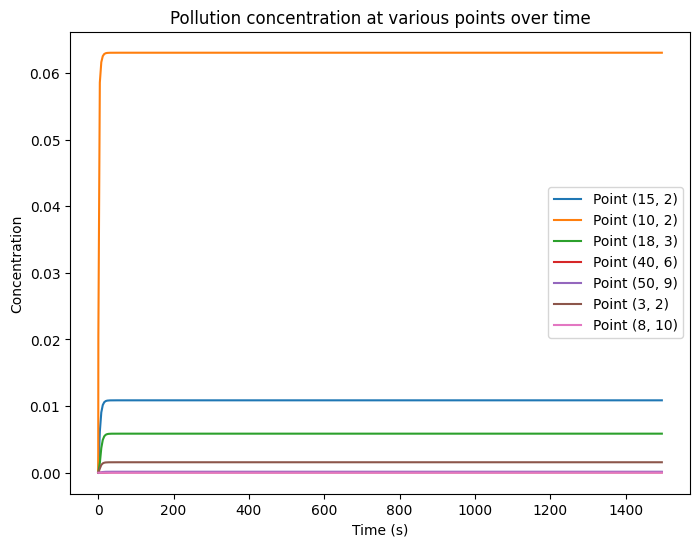

In [ ]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

# Decreasing kappa to 2

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.5 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

# Example points to monitor concentration changes
points = [(15, 2),(10,2),(18,3), (40,6),(50,9), (3,2),(8,10)]  # (x, y) coordinates

plt.figure(figsize=(8, 6))
for (px, py) in points:
    i, j = np.argmin(np.abs(x - px)), np.argmin(np.abs(y - py))
    concentration_time_series = [c[i, j] for c in c_save]
    plt.plot(t_save, concentration_time_series, label=f'Point ({px}, {py})')

plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.legend()
plt.title('Pollution concentration at various points over time')
plt.show()

In the scenario where the diffusion coefficient $ \kappa $ is set to 2 and the Peclet number $ P_e = 0.5 $, the transport of pollutants is dominated by diffusion rather than advection. The resulting pollution concentration profiles reveal several key characteristics.

Firstly, the concentration levels across all points quickly stabilize and reach a uniform steady state. For example, the concentration at Point (10, 2) peaks around 0.06 and remains constant thereafter. This behavior underscores the efficiency of diffusion in rapidly spreading pollutants throughout the system, minimizing spatial variability.

Secondly, the transient phase is brief, with concentrations at all points converging to their steady-state values within a short time frame. This reflects the dominance of diffusion in overcoming concentration gradients, enabling pollutants to disperse evenly across the river.

Thirdly, the overall concentration levels are significantly lower compared to advection-dominated scenarios. Diffusion prevents the accumulation of pollutants near the source by distributing them uniformly across the region. Consequently, localized peaks observed in advection-driven transport are absent in this diffusion-driven regime.

Lastly, the concentration profiles exhibit minimal sensitivity to the distance from the source. Distant points, such as (50, 9), display concentration trends that are nearly identical to those at closer points like (10, 2). This uniformity further highlights the role of diffusion in equalizing pollutant distribution throughout the system.

In summary, under high $ \kappa $ and low $ P_e $, diffusion dominates pollutant transport, resulting in uniform concentration profiles with rapid stabilization and low overall levels. This contrasts sharply with advection-dominated regimes, where pollutant transport is characterized by sharp concentration peaks and greater spatial heterogeneity.


## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.